# Radioactive decay ☢️

In this demo, we will learn how to set radioactive decay in a FESTIM model.

We will set a simple 1D model with one trap.

The sample will be at 300 K and exposed to tritium for a half a year.

After that, the source of tritium will be turned off and the sample will be stored for several half-lives (about 12 years).

## FESTIM model

In [ ]:
import festim as F
import dolfinx
import dolfinx.fem as fem
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import scifem

logger = scifem.solvers.logger
_alpha_kw = scifem.solvers._alpha_kw

class NewtonSolver(scifem.NewtonSolver):
    def solve(self, atol=1e-6, rtol=1e-8, beta=1.0) -> int:
        """Solve the nonlinear problem using Newton's method.

        Args:
            atol: Absolute tolerance for the update.
            rtol: Relative tolerance for the update.
            beta: Damping parameter for the update.

        Returns:
            The number of Newton iterations used to converge.

        Note:
            The tolerance is on the 0-norm of the update.
        """
        i = 1

        while i <= self.max_iterations:
            if self._pre_solve_callback is not None:
                self._pre_solve_callback(self)

            # Pack constants and coefficients
            constants_L = [
                form and dolfinx.cpp.fem.pack_constants(form._cpp_object) for form in self._F
            ]
            coeffs_L = [dolfinx.cpp.fem.pack_coefficients(form._cpp_object) for form in self._F]
            constants_a = [
                [
                    dolfinx.cpp.fem.pack_constants(form._cpp_object)
                    if form is not None
                    else np.array([], dtype=PETSc.ScalarType)
                    for form in forms
                ]
                for forms in self._J
            ]
            coeffs_a = [
                [
                    {} if form is None else dolfinx.cpp.fem.pack_coefficients(form._cpp_object)
                    for form in forms
                ]
                for forms in self._J
            ]

            # Scatter previous solution `w` to `self.x`, the blocked version used for lifting
            dolfinx.cpp.la.petsc.scatter_local_vectors(
                self.x,
                [si.x.petsc_vec.array_r for si in self.w],
                [
                    (
                        si.function_space.dofmap.index_map,
                        si.function_space.dofmap.index_map_bs,
                    )
                    for si in self.w
                ],
            )
            self.x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

            # Assemble F(u_{i-1}) - J(u_D - u_{i-1}) and set du|_bc= u_D - u_{i-1}
            with self.b.localForm() as b_local:
                b_local.set(0.0)
            dolfinx.fem.petsc.assemble_vector_block(
                self.b,
                self._F,
                self._J,
                bcs=self.bcs,
                x0=self.x,
                coeffs_a=coeffs_a,
                constants_a=constants_a,
                coeffs_L=coeffs_L,
                constants_L=constants_L,
                # dolfinx 0.8 compatibility
                # this is called 'scale' in 0.8, 'alpha' in 0.9
                **{_alpha_kw: -1.0},
            )
            self.b.ghostUpdate(PETSc.InsertMode.INSERT_VALUES, PETSc.ScatterMode.FORWARD)

            # Assemble Jacobian
            self.A.zeroEntries()
            dolfinx.fem.petsc.assemble_matrix_block(
                self.A, self._J, bcs=self.bcs, constants=constants_a, coeffs=coeffs_a
            )
            self.A.assemble()

            self._solver.solve(self.b, self.dx)
            if self._error_on_convergence:
                if (status := self._solver.getConvergedReason()) <= 0:
                    raise RuntimeError(f"Linear solver did not converge, got reason: {status}")

            # Update solution
            offset_start = 0
            for s in self.w:
                num_sub_dofs = (
                    s.function_space.dofmap.index_map.size_local
                    * s.function_space.dofmap.index_map_bs
                )
                s.x.petsc_vec.array_w[:num_sub_dofs] -= (
                    beta * self.dx.array_r[offset_start : offset_start + num_sub_dofs]
                )
                s.x.petsc_vec.ghostUpdate(
                    addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
                )
                offset_start += num_sub_dofs

            if self._post_solve_callback is not None:
                self._post_solve_callback(self)

            # Compute norm of update
            residual = self.dx.norm(PETSc.NormType.NORM_2)
            if i == 1:
                self.residual_0 = residual
                relative_residual = float('inf')
            else:
                relative_residual = residual / max(self.residual_0, atol)

            logger.info(
                f"Newton iteration {i}"
                f": r (abs) = {residual} (tol={atol}), "
                f"r (rel) = {relative_residual} (tol={rtol})"
            )
            if relative_residual < rtol or residual < atol:
                return i
            i += 1

        if self._error_on_convergence:
            raise RuntimeError("Newton solver did not converge")
        else:
            return self.max_iterations

class CustomProblem(F.HydrogenTransportProblem):
    def create_solver(self):
        """Creates the solver of the model"""
        # problem = fem.petsc.NonlinearProblem(
        #     self.formulation,
        #     self.u,
        #     bcs=self.bc_forms,
        # )
        # self.solver = NewtonSolver(MPI.COMM_WORLD, problem)
        self.solver = NewtonSolver([self.formulation], J=[], bcs=self.bc_forms, w=self.u)
    
    def iterate(self):
        """Iterates the model for a given time step"""
        if self.show_progress_bar:
            self.progress_bar.update(
                min(self.dt.value, abs(self.settings.final_time - self.t.value))
            )

        # update rtol if it's callable
        if callable(self.settings.rtol):
            rtol = self.settings.rtol(self.t.value)
        # update rtol if it's callable
        if callable(self.settings.atol):
            atol = self.settings.atol(self.t.value)

        self.t.value += self.dt.value

        self.update_time_dependent_values()

        # solve main problem
        nb_its = self.solver.solve(atol, rtol)

        # post processing
        self.post_processing()

        # update previous solution
        self.u_n.x.array[:] = self.u.x.array[:]

        # adapt stepsize
        if self.settings.stepsize.adaptive:
            new_stepsize = self.settings.stepsize.modify_value(
                value=self.dt.value, nb_iterations=nb_its, t=self.t.value
            )
            self.dt.value = new_stepsize

In [ ]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

H = F.Species("H")
trapped_H = F.Species("H_trapped", mobile=False)
my_model.species = [H, trapped_H]

vertices = np.concatenate(
    [
        np.linspace(0, 2e-5, num=1000),
        np.linspace(2e-5, 1e-4, num=300),
        np.linspace(1e-4, 1e-2, num=100),
    ]
)
my_model.mesh = F.Mesh1D(vertices)

volume_subdomain = F.VolumeSubdomain1D(
    id=1, borders=[0, 1e-2], material=F.Material(D_0=1e-7, E_D=0.2)
)
left_boundary = F.SurfaceSubdomain1D(id=1, x=0)
right_boundary = F.SurfaceSubdomain1D(id=2, x=1e-2)
my_model.subdomains = [volume_subdomain, left_boundary, right_boundary]

empty_traps = F.ImplicitSpecies(n=1.3e24, others=[trapped_H])
my_model.reactions = [
    F.Reaction(
        reactant=[H, empty_traps],
        product=[trapped_H],
        k_0=1e-16,
        E_k=0.2,
        p_0=1e13,
        E_p=1.2,
        volume=volume_subdomain,
    )
]

exposure_time = 2e7
def conc_fun(t):
    if t < exposure_time:
        return 1e17
    else:
        return 0
my_model.boundary_conditions = [
    F.FixedConcentrationBC(
        subdomain=left_boundary,
        value=conc_fun,
        species=H,
    )
]


my_model.temperature = 300

Radioactive decay is implemented as a reaction in FESTIM.

In [2]:
half_life = 12 * 365 * 24 * 3600  # 12 years
decay_constant = np.log(2) / half_life

my_model.reactions += [
    F.Reaction(
        reactant=[spe],
        k_0=decay_constant,
        E_k=0,
        volume=volume_subdomain,
    )
    for spe in [H, trapped_H]
]

We then set some derived quantities exports as well as profile exports:

In [ ]:
class ProfileExport(F.VolumeQuantity):

    def compute(self):
        profile = self.field.post_processing_solution.x.array[:].copy()

        self.data.append(profile)


profile_exports = [
    ProfileExport(field=H, volume=volume_subdomain),
    ProfileExport(field=trapped_H, volume=volume_subdomain),
]

total_H = F.TotalVolume(H, volume=volume_subdomain)
total_H_trapped = F.TotalVolume(trapped_H, volume=volume_subdomain)
my_model.exports = profile_exports + [
    total_H, total_H_trapped,
]

The simulation will go on for three half-lives after the exposure.

In [7]:
my_model.settings = F.Settings(
    atol=1e6,
    rtol=1e-15,
    final_time=exposure_time + 3 * half_life,
)

my_model.settings.stepsize = F.Stepsize(
    initial_value=1e3,
    growth_factor=1.1,
    cutback_factor=0.9,
    target_nb_iterations=4,
    milestones=[
        exposure_time,
        exposure_time + 1 * half_life,
        exposure_time + 2 * half_life,
        exposure_time + 3 * half_life,
    ],
)
# from dolfinx import log
# log.set_log_level(log.LogLevel.INFO)

my_model.initialise()
my_model.run()

[2025-04-17 16:15:24.850] [info] Checking required entities per dimension
[2025-04-17 16:15:24.850] [info] Cell type: 0 dofmap: 1397x4
[2025-04-17 16:15:24.850] [info] Global index computation
[2025-04-17 16:15:24.850] [info] Got 2 index_maps
[2025-04-17 16:15:24.850] [info] Get global indices
[2025-04-17 16:15:24.851] [info] Checking required entities per dimension
[2025-04-17 16:15:24.851] [info] Cell type: 0 dofmap: 1397x1
[2025-04-17 16:15:24.851] [info] Global index computation
[2025-04-17 16:15:24.851] [info] Got 1 index_maps
[2025-04-17 16:15:24.851] [info] Get global indices
[2025-04-17 16:15:24.851] [info] Checking required entities per dimension
[2025-04-17 16:15:24.851] [info] Cell type: 0 dofmap: 1397x2
[2025-04-17 16:15:24.851] [info] Global index computation
[2025-04-17 16:15:24.851] [info] Got 1 index_maps
[2025-04-17 16:15:24.851] [info] Get global indices
[2025-04-17 16:15:24.861] [info] Column ghost size increased from 0 to 0


Solving HydrogenTransportProblem:   0%|          | 2.00k/1.16G [00:00<21:03:24, 15.2kit/s]

[2025-04-17 16:15:24.864] [info] Newton iteration 0: r (abs) = 1.0000020731689298e+17 (tol = 1000000), r (rel) = inf (tol = 1e-15)
[2025-04-17 16:15:24.864] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:24.919] [info] Newton iteration 1: r (abs) = 259789761567972.75 (tol = 1000000), r (rel) = 3.6275649256778574e-11 (tol = 1e-15)
[2025-04-17 16:15:24.919] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:24.957] [info] Newton iteration 2: r (abs) = 50918688835718.35 (tol = 1000000), r (rel) = 7.1100126720593594e-12 (tol = 1e-15)
[2025-04-17 16:15:24.957] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:24.971] [info] Newton iteration 3: r (abs) = 1847603967738.233 (tol = 1000000), r (rel) = 2.579895108051374e-13 (tol = 1e-15)
[2025-04-17 16:15:24.972] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:24.987] [info] Newton iteration 4: r (abs) = 3410184708.6924486 (tol = 1000000), r (rel) = 4.7617990

Solving HydrogenTransportProblem:   0%|          | 7.11k/1.16G [00:00<15:35:17, 20.6kit/s]

[2025-04-17 16:15:25.125] [info] Newton iteration 0: r (abs) = 9003785028066.371 (tol = 1000000), r (rel) = 8.404886474521305e-12 (tol = 1e-15)
[2025-04-17 16:15:25.125] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.148] [info] Newton iteration 1: r (abs) = 3653263901754.68 (tol = 1000000), r (rel) = 3.88089896678027e-12 (tol = 1e-15)
[2025-04-17 16:15:25.149] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.162] [info] Newton iteration 2: r (abs) = 127565900519.59108 (tol = 1000000), r (rel) = 1.3551453846109806e-13 (tol = 1e-15)
[2025-04-17 16:15:25.163] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.172] [info] Newton iteration 3: r (abs) = 129880797.82173553 (tol = 1000000), r (rel) = 1.379736771353613e-16 (tol = 1e-15)
[2025-04-17 16:15:25.172] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:25.180] [info] Newton iteration 0: r (abs) = 7287357836390.53 (t

Solving HydrogenTransportProblem:   0%|          | 10.5k/1.16G [00:00<13:21:10, 24.0kit/s]

[2025-04-17 16:15:25.287] [info] Newton iteration 1: r (abs) = 2090993765908.8625 (tol = 1000000), r (rel) = 2.511511415627983e-12 (tol = 1e-15)
[2025-04-17 16:15:25.287] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.309] [info] Newton iteration 2: r (abs) = 68349670653.056694 (tol = 1000000), r (rel) = 8.209540406016056e-14 (tol = 1e-15)
[2025-04-17 16:15:25.310] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.337] [info] Newton iteration 3: r (abs) = 61321251.05578855 (tol = 1000000), r (rel) = 7.365350607837013e-17 (tol = 1e-15)
[2025-04-17 16:15:25.337] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:25.347] [info] Newton iteration 0: r (abs) = 4912291137404.406 (tol = 1000000), r (rel) = 5.900197059227897e-12 (tol = 1e-15)
[2025-04-17 16:15:25.348] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.373] [info] Newton iteration 1: r (abs) = 1893493672318.9617

Solving HydrogenTransportProblem:   0%|          | 14.6k/1.16G [00:00<13:35:07, 23.6kit/s]

[2025-04-17 16:15:25.515] [info] Newton iteration 3: r (abs) = 61870829.82118184 (tol = 1000000), r (rel) = 7.451149154400095e-17 (tol = 1e-15)
[2025-04-17 16:15:25.515] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:25.523] [info] Newton iteration 0: r (abs) = 4059772615522.4053 (tol = 1000000), r (rel) = 4.889213766589919e-12 (tol = 1e-15)
[2025-04-17 16:15:25.524] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.547] [info] Newton iteration 1: r (abs) = 1655014837158.1538 (tol = 1000000), r (rel) = 1.9731031760673295e-12 (tol = 1e-15)
[2025-04-17 16:15:25.547] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.572] [info] Newton iteration 2: r (abs) = 60756265636.19544 (tol = 1000000), r (rel) = 7.243341751462011e-14 (tol = 1e-15)
[2025-04-17 16:15:25.572] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.592] [info] Newton iteration 3: r (abs) = 67432317.88994765

Solving HydrogenTransportProblem:   0%|          | 19.5k/1.16G [00:00<11:39:46, 27.5kit/s]

[2025-04-17 16:15:25.613] [info] Newton iteration 1: r (abs) = 1582302312011.5222 (tol = 1000000), r (rel) = 1.8574720303301323e-12 (tol = 1e-15)
[2025-04-17 16:15:25.614] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.632] [info] Newton iteration 2: r (abs) = 61720111151.153984 (tol = 1000000), r (rel) = 7.245352503239001e-14 (tol = 1e-15)
[2025-04-17 16:15:25.632] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.654] [info] Newton iteration 3: r (abs) = 76410840.47868574 (tol = 1000000), r (rel) = 8.969904039560217e-17 (tol = 1e-15)
[2025-04-17 16:15:25.654] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:25.666] [info] Newton iteration 0: r (abs) = 3444324254539.865 (tol = 1000000), r (rel) = 4.0433082335968266e-12 (tol = 1e-15)
[2025-04-17 16:15:25.667] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.685] [info] Newton iteration 1: r (abs) = 1529266819950.28

Solving HydrogenTransportProblem:   0%|          | 25.5k/1.16G [00:00<9:30:27, 33.8kit/s] 

[2025-04-17 16:15:25.703] [info] Newton iteration 2: r (abs) = 63867488870.377495 (tol = 1000000), r (rel) = 7.350976317286852e-14 (tol = 1e-15)
[2025-04-17 16:15:25.704] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.724] [info] Newton iteration 3: r (abs) = 89322177.95534948 (tol = 1000000), r (rel) = 1.0280742618374606e-16 (tol = 1e-15)
[2025-04-17 16:15:25.724] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:25.732] [info] Newton iteration 0: r (abs) = 3193120695938.1284 (tol = 1000000), r (rel) = 3.675196101997764e-12 (tol = 1e-15)
[2025-04-17 16:15:25.732] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.748] [info] Newton iteration 1: r (abs) = 1491016694794.4377 (tol = 1000000), r (rel) = 1.6767825295884647e-12 (tol = 1e-15)
[2025-04-17 16:15:25.748] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.761] [info] Newton iteration 2: r (abs) = 67094361651.177

Solving HydrogenTransportProblem:   0%|          | 32.8k/1.16G [00:01<7:40:59, 41.8kit/s]

[2025-04-17 16:15:25.833] [info] Newton iteration 2: r (abs) = 71370481681.61671 (tol = 1000000), r (rel) = 7.819944620811837e-14 (tol = 1e-15)
[2025-04-17 16:15:25.834] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.857] [info] Newton iteration 3: r (abs) = 131090670.14268865 (tol = 1000000), r (rel) = 1.436338604794625e-16 (tol = 1e-15)
[2025-04-17 16:15:25.857] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:25.863] [info] Newton iteration 0: r (abs) = 2769397926782.2583 (tol = 1000000), r (rel) = 3.034383110518724e-12 (tol = 1e-15)
[2025-04-17 16:15:25.864] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.877] [info] Newton iteration 1: r (abs) = 1446419047692.8997 (tol = 1000000), r (rel) = 1.5404146304895223e-12 (tol = 1e-15)
[2025-04-17 16:15:25.877] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:25.882] [info] Newton iteration 2: r (abs) = 76717143318.2771

Solving HydrogenTransportProblem:   0%|          | 41.5k/1.16G [00:01<6:50:09, 46.9kit/s]

[2025-04-17 16:15:26.063] [info] Newton iteration 0: r (abs) = 2272426696750.4756 (tol = 1000000), r (rel) = 2.2733874588423035e-12 (tol = 1e-15)
[2025-04-17 16:15:26.063] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.093] [info] Newton iteration 1: r (abs) = 1432078306935.708 (tol = 1000000), r (rel) = 1.3853843153432007e-12 (tol = 1e-15)
[2025-04-17 16:15:26.093] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 46.6k/1.16G [00:01<6:43:25, 47.7kit/s]

[2025-04-17 16:15:26.123] [info] Newton iteration 2: r (abs) = 99980562200.2189 (tol = 1000000), r (rel) = 9.672062068153158e-14 (tol = 1e-15)
[2025-04-17 16:15:26.123] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.154] [info] Newton iteration 3: r (abs) = 340162670.636512 (tol = 1000000), r (rel) = 3.2907141060843923e-16 (tol = 1e-15)
[2025-04-17 16:15:26.154] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:26.165] [info] Newton iteration 0: r (abs) = 2133729619291.4265 (tol = 1000000), r (rel) = 2.064157758296572e-12 (tol = 1e-15)
[2025-04-17 16:15:26.165] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.198] [info] Newton iteration 1: r (abs) = 1436907143091.8323 (tol = 1000000), r (rel) = 1.3424853491112465e-12 (tol = 1e-15)
[2025-04-17 16:15:26.199] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.219] [info] Newton iteration 2: r (abs) = 110582096351.06906

Solving HydrogenTransportProblem:   0%|          | 58.3k/1.16G [00:01<5:37:42, 57.0kit/s]

[2025-04-17 16:15:26.296] [info] Newton iteration 2: r (abs) = 122914807533.00925 (tol = 1000000), r (rel) = 1.1078824719177106e-13 (tol = 1e-15)
[2025-04-17 16:15:26.297] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.314] [info] Newton iteration 3: r (abs) = 580385049.8216802 (tol = 1000000), r (rel) = 5.231252739730703e-16 (tol = 1e-15)
[2025-04-17 16:15:26.314] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:26.324] [info] Newton iteration 0: r (abs) = 1887181095417.8022 (tol = 1000000), r (rel) = 1.7009951029589025e-12 (tol = 1e-15)
[2025-04-17 16:15:26.325] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.353] [info] Newton iteration 1: r (abs) = 1457007975090.0964 (tol = 1000000), r (rel) = 1.2657665874765088e-12 (tol = 1e-15)
[2025-04-17 16:15:26.354] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 72.4k/1.16G [00:01<4:57:33, 64.7kit/s]

[2025-04-17 16:15:26.377] [info] Newton iteration 2: r (abs) = 137224113054.4827 (tol = 1000000), r (rel) = 1.1921259201736528e-13 (tol = 1e-15)
[2025-04-17 16:15:26.378] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.407] [info] Newton iteration 3: r (abs) = 765245001.015783 (tol = 1000000), r (rel) = 6.648018199483834e-16 (tol = 1e-15)
[2025-04-17 16:15:26.407] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:26.418] [info] Newton iteration 0: r (abs) = 1777077501061.2942 (tol = 1000000), r (rel) = 1.5438249911161556e-12 (tol = 1e-15)
[2025-04-17 16:15:26.420] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.447] [info] Newton iteration 1: r (abs) = 1471386772653.1025 (tol = 1000000), r (rel) = 1.2310262215270363e-12 (tol = 1e-15)
[2025-04-17 16:15:26.447] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.465] [info] Newton iteration 2: r (abs) = 153803107698.019

Solving HydrogenTransportProblem:   0%|          | 79.8k/1.16G [00:01<5:30:34, 58.2kit/s]

[2025-04-17 16:15:26.614] [info] Newton iteration 2: r (abs) = 173001155034.06995 (tol = 1000000), r (rel) = 1.3929330126212337e-13 (tol = 1e-15)
[2025-04-17 16:15:26.614] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.637] [info] Newton iteration 3: r (abs) = 1349009182.8688128 (tol = 1000000), r (rel) = 1.0861658263363085e-15 (tol = 1e-15)
[2025-04-17 16:15:26.637] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.660] [info] Newton iteration 4: r (abs) = 82862.88991992072 (tol = 1000000), r (rel) = 6.67177365769183e-20 (tol = 1e-15)
[2025-04-17 16:15:26.660] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:26.669] [info] Newton iteration 0: r (abs) = 1578504467030.3445 (tol = 1000000), r (rel) = 1.2709458397914407e-12 (tol = 1e-15)
[2025-04-17 16:15:26.669] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.694] [info] Newton iteration 1: r (abs) = 1316938925221.5

Solving HydrogenTransportProblem:   0%|          | 87.9k/1.16G [00:01<5:07:33, 62.6kit/s]

[2025-04-17 16:15:26.731] [info] Newton iteration 2: r (abs) = 139099636354.92816 (tol = 1000000), r (rel) = 1.1830888811220876e-13 (tol = 1e-15)
[2025-04-17 16:15:26.731] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.766] [info] Newton iteration 3: r (abs) = 932099818.6443977 (tol = 1000000), r (rel) = 7.927820377044657e-16 (tol = 1e-15)
[2025-04-17 16:15:26.766] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:26.774] [info] Newton iteration 0: r (abs) = 1501288381423.6216 (tol = 1000000), r (rel) = 1.2768959272388025e-12 (tol = 1e-15)
[2025-04-17 16:15:26.776] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.816] [info] Newton iteration 1: r (abs) = 1340797596293.3997 (tol = 1000000), r (rel) = 1.087920247817009e-12 (tol = 1e-15)
[2025-04-17 16:15:26.816] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 96.1k/1.16G [00:02<5:04:45, 63.2kit/s]

[2025-04-17 16:15:26.833] [info] Newton iteration 2: r (abs) = 157142884130.95764 (tol = 1000000), r (rel) = 1.2750539374402406e-13 (tol = 1e-15)
[2025-04-17 16:15:26.833] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.864] [info] Newton iteration 3: r (abs) = 1240133493.2610874 (tol = 1000000), r (rel) = 1.0062416139800002e-15 (tol = 1e-15)
[2025-04-17 16:15:26.864] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.889] [info] Newton iteration 4: r (abs) = 78112.52818310256 (tol = 1000000), r (rel) = 6.338033514789973e-20 (tol = 1e-15)
[2025-04-17 16:15:26.889] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:26.900] [info] Newton iteration 0: r (abs) = 1426736018502.945 (tol = 1000000), r (rel) = 1.1576504963240719e-12 (tol = 1e-15)
[2025-04-17 16:15:26.900] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:26.925] [info] Newton iteration 1: r (abs) = 1198160263971.5

Solving HydrogenTransportProblem:   0%|          | 105k/1.16G [00:02<4:36:59, 69.5kit/s] 

[2025-04-17 16:15:26.988] [info] Newton iteration 3: r (abs) = 875136547.1956098 (tol = 1000000), r (rel) = 7.452948247474367e-16 (tol = 1e-15)
[2025-04-17 16:15:26.988] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:27.000] [info] Newton iteration 0: r (abs) = 1364657577858.6309 (tol = 1000000), r (rel) = 1.162186899392598e-12 (tol = 1e-15)
[2025-04-17 16:15:27.001] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.034] [info] Newton iteration 1: r (abs) = 1232420309787.0908 (tol = 1000000), r (rel) = 9.967426002298227e-13 (tol = 1e-15)
[2025-04-17 16:15:27.034] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.058] [info] Newton iteration 2: r (abs) = 147403032287.08627 (tol = 1000000), r (rel) = 1.19214914357402e-13 (tol = 1e-15)
[2025-04-17 16:15:27.058] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 125k/1.16G [00:02<3:44:32, 85.7kit/s]

[2025-04-17 16:15:27.086] [info] Newton iteration 3: r (abs) = 1199804747.4816213 (tol = 1000000), r (rel) = 9.703641641377335e-16 (tol = 1e-15)
[2025-04-17 16:15:27.086] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:27.095] [info] Newton iteration 0: r (abs) = 1302593027546.0662 (tol = 1000000), r (rel) = 1.0534960767903947e-12 (tol = 1e-15)
[2025-04-17 16:15:27.095] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.116] [info] Newton iteration 1: r (abs) = 1272951682203.8801 (tol = 1000000), r (rel) = 9.799847559437692e-13 (tol = 1e-15)
[2025-04-17 16:15:27.117] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.132] [info] Newton iteration 2: r (abs) = 172008415736.276 (tol = 1000000), r (rel) = 1.3242107117824666e-13 (tol = 1e-15)
[2025-04-17 16:15:27.132] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.149] [info] Newton iteration 3: r (abs) = 1689558893.33536

Solving HydrogenTransportProblem:   0%|          | 145k/1.16G [00:02<3:21:53, 95.4kit/s]

[2025-04-17 16:15:27.317] [info] Newton iteration 2: r (abs) = 119291864745.44322 (tol = 1000000), r (rel) = 1.0013747600105647e-13 (tol = 1e-15)
[2025-04-17 16:15:27.318] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.350] [info] Newton iteration 3: r (abs) = 906382794.2994386 (tol = 1000000), r (rel) = 7.608472338462421e-16 (tol = 1e-15)
[2025-04-17 16:15:27.350] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:27.360] [info] Newton iteration 0: r (abs) = 1145405350270.3877 (tol = 1000000), r (rel) = 9.614905510860826e-13 (tol = 1e-15)
[2025-04-17 16:15:27.361] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 156k/1.16G [00:02<3:27:51, 92.6kit/s]

[2025-04-17 16:15:27.398] [info] Newton iteration 1: r (abs) = 1085950033144.3741 (tol = 1000000), r (rel) = 8.594249208784348e-13 (tol = 1e-15)
[2025-04-17 16:15:27.398] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.420] [info] Newton iteration 2: r (abs) = 140364166078.25284 (tol = 1000000), r (rel) = 1.1108472640926027e-13 (tol = 1e-15)
[2025-04-17 16:15:27.421] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.451] [info] Newton iteration 3: r (abs) = 1286724375.2435381 (tol = 1000000), r (rel) = 1.0183184867024285e-15 (tol = 1e-15)
[2025-04-17 16:15:27.451] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.476] [info] Newton iteration 4: r (abs) = 110156.15639823124 (tol = 1000000), r (rel) = 8.717799448166333e-20 (tol = 1e-15)
[2025-04-17 16:15:27.476] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:27.487] [info] Newton iteration 0: r (abs) = 1100196572763.

Solving HydrogenTransportProblem:   0%|          | 180k/1.16G [00:02<3:16:29, 98.0kit/s]

[2025-04-17 16:15:27.631] [info] Newton iteration 2: r (abs) = 142710527993.54788 (tol = 1000000), r (rel) = 1.1067620314669846e-13 (tol = 1e-15)
[2025-04-17 16:15:27.632] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.677] [info] Newton iteration 3: r (abs) = 1427441540.0226622 (tol = 1000000), r (rel) = 1.1070228110341439e-15 (tol = 1e-15)
[2025-04-17 16:15:27.678] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.700] [info] Newton iteration 4: r (abs) = 146109.15313690685 (tol = 1000000), r (rel) = 1.1331193669820547e-19 (tol = 1e-15)
[2025-04-17 16:15:27.700] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:27.711] [info] Newton iteration 0: r (abs) = 1019919854614.2714 (tol = 1000000), r (rel) = 7.909777828566631e-13 (tol = 1e-15)
[2025-04-17 16:15:27.711] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.730] [info] Newton iteration 1: r (abs) = 958986542902.

Solving HydrogenTransportProblem:   0%|          | 206k/1.16G [00:02<2:39:02, 121kit/s] 

[2025-04-17 16:15:27.783] [info] Newton iteration 1: r (abs) = 1010385373676.4603 (tol = 1000000), r (rel) = 7.656557493737686e-13 (tol = 1e-15)
[2025-04-17 16:15:27.783] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.799] [info] Newton iteration 2: r (abs) = 147938407782.5347 (tol = 1000000), r (rel) = 1.1210563357597592e-13 (tol = 1e-15)
[2025-04-17 16:15:27.800] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.822] [info] Newton iteration 3: r (abs) = 1637487027.3616347 (tol = 1000000), r (rel) = 1.240864515350621e-15 (tol = 1e-15)
[2025-04-17 16:15:27.823] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:27.843] [info] Newton iteration 4: r (abs) = 206343.22409575887 (tol = 1000000), r (rel) = 1.5636397753697856e-19 (tol = 1e-15)
[2025-04-17 16:15:27.843] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:27.852] [info] Newton iteration 0: r (abs) = 948051136365.58

Solving HydrogenTransportProblem:   0%|          | 219k/1.16G [00:03<4:26:23, 72.3kit/s]

[2025-04-17 16:15:28.172] [info] Newton iteration 3: r (abs) = 1286063388.881887 (tol = 1000000), r (rel) = 1.0108882642175216e-15 (tol = 1e-15)
[2025-04-17 16:15:28.172] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:28.280] [info] Newton iteration 4: r (abs) = 132658.51721937716 (tol = 1000000), r (rel) = 1.0427397231341487e-19 (tol = 1e-15)
[2025-04-17 16:15:28.280] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:28.288] [info] Newton iteration 0: r (abs) = 916612957646.6892 (tol = 1000000), r (rel) = 7.204880332689802e-13 (tol = 1e-15)
[2025-04-17 16:15:28.288] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:28.428] [info] Newton iteration 1: r (abs) = 861952631488.6156 (tol = 1000000), r (rel) = 6.996251440208477e-13 (tol = 1e-15)
[2025-04-17 16:15:28.429] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 234k/1.16G [00:03<5:48:58, 55.2kit/s]

[2025-04-17 16:15:28.537] [info] Newton iteration 2: r (abs) = 110287738201.53731 (tol = 1000000), r (rel) = 8.951776687510836e-14 (tol = 1e-15)
[2025-04-17 16:15:28.538] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:28.706] [info] Newton iteration 3: r (abs) = 994491698.1431257 (tol = 1000000), r (rel) = 8.072037512540631e-16 (tol = 1e-15)
[2025-04-17 16:15:28.706] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:28.724] [info] Newton iteration 0: r (abs) = 890137517805.4463 (tol = 1000000), r (rel) = 7.225021031810846e-13 (tol = 1e-15)
[2025-04-17 16:15:28.724] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:28.935] [info] Newton iteration 1: r (abs) = 914083247561.2318 (tol = 1000000), r (rel) = 6.946725956487913e-13 (tol = 1e-15)
[2025-04-17 16:15:28.936] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:29.033] [info] Newton iteration 2: r (abs) = 134316082432.57903 

Solving HydrogenTransportProblem:   0%|          | 248k/1.16G [00:04<7:09:19, 44.8kit/s]

[2025-04-17 16:15:29.123] [info] Newton iteration 3: r (abs) = 1493488222.3515832 (tol = 1000000), r (rel) = 1.1350009342801955e-15 (tol = 1e-15)
[2025-04-17 16:15:29.124] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:29.201] [info] Newton iteration 4: r (abs) = 190049.4867757143 (tol = 1000000), r (rel) = 1.4443123274870245e-19 (tol = 1e-15)
[2025-04-17 16:15:29.201] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:29.207] [info] Newton iteration 0: r (abs) = 860312492178.0897 (tol = 1000000), r (rel) = 6.53808625860852e-13 (tol = 1e-15)
[2025-04-17 16:15:29.208] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:29.373] [info] Newton iteration 1: r (abs) = 850686178659.6984 (tol = 1000000), r (rel) = 6.68363436122418e-13 (tol = 1e-15)
[2025-04-17 16:15:29.374] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 264k/1.16G [00:04<7:29:31, 42.8kit/s]

[2025-04-17 16:15:29.491] [info] Newton iteration 2: r (abs) = 117850187250.13846 (tol = 1000000), r (rel) = 9.259202520754969e-14 (tol = 1e-15)
[2025-04-17 16:15:29.491] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:29.611] [info] Newton iteration 3: r (abs) = 1199222701.1710715 (tol = 1000000), r (rel) = 9.422001030903515e-16 (tol = 1e-15)
[2025-04-17 16:15:29.611] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:29.617] [info] Newton iteration 0: r (abs) = 834583894648.9177 (tol = 1000000), r (rel) = 6.557122632917734e-13 (tol = 1e-15)
[2025-04-17 16:15:29.618] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:29.687] [info] Newton iteration 1: r (abs) = 905479527973.9731 (tol = 1000000), r (rel) = 6.664774463201655e-13 (tol = 1e-15)
[2025-04-17 16:15:29.688] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 280k/1.16G [00:05<7:44:48, 41.4kit/s]

[2025-04-17 16:15:29.762] [info] Newton iteration 2: r (abs) = 145135744930.3042 (tol = 1000000), r (rel) = 1.0682704319926318e-13 (tol = 1e-15)
[2025-04-17 16:15:29.763] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:29.901] [info] Newton iteration 3: r (abs) = 1835939490.8192544 (tol = 1000000), r (rel) = 1.3513417207536612e-15 (tol = 1e-15)
[2025-04-17 16:15:29.901] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:30.020] [info] Newton iteration 4: r (abs) = 304707.7539525579 (tol = 1000000), r (rel) = 2.2427988646264727e-19 (tol = 1e-15)
[2025-04-17 16:15:30.020] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:30.030] [info] Newton iteration 0: r (abs) = 806141602673.1515 (tol = 1000000), r (rel) = 5.933598498071078e-13 (tol = 1e-15)
[2025-04-17 16:15:30.030] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:30.150] [info] Newton iteration 1: r (abs) = 845137965041.132

Solving HydrogenTransportProblem:   0%|          | 296k/1.16G [00:05<8:09:58, 39.3kit/s]

[2025-04-17 16:15:30.291] [info] Newton iteration 2: r (abs) = 128121612368.60335 (tol = 1000000), r (rel) = 9.746445342059187e-14 (tol = 1e-15)
[2025-04-17 16:15:30.291] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:30.380] [info] Newton iteration 3: r (abs) = 1492517773.007867 (tol = 1000000), r (rel) = 1.1353855628059367e-15 (tol = 1e-15)
[2025-04-17 16:15:30.380] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:30.471] [info] Newton iteration 4: r (abs) = 209021.19768316633 (tol = 1000000), r (rel) = 1.5900624733707735e-19 (tol = 1e-15)
[2025-04-17 16:15:30.471] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:30.485] [info] Newton iteration 0: r (abs) = 782063878258.3448 (tol = 1000000), r (rel) = 5.949302933773935e-13 (tol = 1e-15)
[2025-04-17 16:15:30.486] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:30.586] [info] Newton iteration 1: r (abs) = 787687133722.333

Solving HydrogenTransportProblem:   0%|          | 313k/1.16G [00:06<7:58:09, 40.3kit/s]

[2025-04-17 16:15:30.879] [info] Newton iteration 3: r (abs) = 1188874076.8050056 (tol = 1000000), r (rel) = 9.30776928343084e-16 (tol = 1e-15)
[2025-04-17 16:15:30.879] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:30.892] [info] Newton iteration 0: r (abs) = 761960512013.2063 (tol = 1000000), r (rel) = 5.965436363086739e-13 (tol = 1e-15)
[2025-04-17 16:15:30.893] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 331k/1.16G [00:06<7:45:34, 41.3kit/s]

[2025-04-17 16:15:31.016] [info] Newton iteration 1: r (abs) = 841581239655.3359 (tol = 1000000), r (rel) = 6.149604876394676e-13 (tol = 1e-15)
[2025-04-17 16:15:31.016] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.114] [info] Newton iteration 2: r (abs) = 138778258211.60486 (tol = 1000000), r (rel) = 1.014080891091586e-13 (tol = 1e-15)
[2025-04-17 16:15:31.114] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.202] [info] Newton iteration 3: r (abs) = 1829136931.2168214 (tol = 1000000), r (rel) = 1.3365874691326643e-15 (tol = 1e-15)
[2025-04-17 16:15:31.202] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.277] [info] Newton iteration 4: r (abs) = 330529.5809280175 (tol = 1000000), r (rel) = 2.4152467128426884e-19 (tol = 1e-15)
[2025-04-17 16:15:31.277] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:31.290] [info] Newton iteration 0: r (abs) = 738379452482.415

Solving HydrogenTransportProblem:   0%|          | 348k/1.16G [00:06<8:03:03, 39.8kit/s]

[2025-04-17 16:15:31.415] [info] Newton iteration 1: r (abs) = 789648032856.3196 (tol = 1000000), r (rel) = 5.94921038858862e-13 (tol = 1e-15)
[2025-04-17 16:15:31.415] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.577] [info] Newton iteration 2: r (abs) = 123623460875.77309 (tol = 1000000), r (rel) = 9.313794844205597e-14 (tol = 1e-15)
[2025-04-17 16:15:31.577] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.678] [info] Newton iteration 3: r (abs) = 1509768962.7318387 (tol = 1000000), r (rel) = 1.1374603397621871e-15 (tol = 1e-15)
[2025-04-17 16:15:31.678] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.750] [info] Newton iteration 4: r (abs) = 233088.0446989549 (tol = 1000000), r (rel) = 1.7560859513103433e-19 (tol = 1e-15)
[2025-04-17 16:15:31.750] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.


Solving HydrogenTransportProblem:   0%|          | 367k/1.16G [00:07<7:04:58, 45.3kit/s]

[2025-04-17 16:15:31.764] [info] Newton iteration 0: r (abs) = 717869510909.189 (tol = 1000000), r (rel) = 5.408430812527667e-13 (tol = 1e-15)
[2025-04-17 16:15:31.767] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.869] [info] Newton iteration 1: r (abs) = 739684298042.4775 (tol = 1000000), r (rel) = 5.724492510516849e-13 (tol = 1e-15)
[2025-04-17 16:15:31.870] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:31.960] [info] Newton iteration 2: r (abs) = 109211889737.39091 (tol = 1000000), r (rel) = 8.45201995656239e-14 (tol = 1e-15)
[2025-04-17 16:15:31.960] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:32.061] [info] Newton iteration 3: r (abs) = 1222273294.1238294 (tol = 1000000), r (rel) = 9.45929815805663e-16 (tol = 1e-15)
[2025-04-17 16:15:32.062] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:32.073] [info] Newton iteration 0: r (abs) = 700677863256.2124 (to

Solving HydrogenTransportProblem:   0%|          | 387k/1.16G [00:07<8:22:19, 38.3kit/s]

[2025-04-17 16:15:32.452] [info] Newton iteration 2: r (abs) = 136406005825.01268 (tol = 1000000), r (rel) = 9.835605057508018e-14 (tol = 1e-15)
[2025-04-17 16:15:32.452] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:32.566] [info] Newton iteration 3: r (abs) = 1908279365.8114092 (tol = 1000000), r (rel) = 1.3759718326178872e-15 (tol = 1e-15)
[2025-04-17 16:15:32.566] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:32.725] [info] Newton iteration 4: r (abs) = 390125.94991770474 (tol = 1000000), r (rel) = 2.8130174642003083e-19 (tol = 1e-15)
[2025-04-17 16:15:32.725] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:32.738] [info] Newton iteration 0: r (abs) = 680038130876.2639 (tol = 1000000), r (rel) = 4.903439873406512e-13 (tol = 1e-15)
[2025-04-17 16:15:32.739] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:32.926] [info] Newton iteration 1: r (abs) = 748231746201.25

Solving HydrogenTransportProblem:   0%|          | 406k/1.16G [00:09<12:39:16, 25.4kit/s]

[2025-04-17 16:15:33.949] [info] Newton iteration 3: r (abs) = 1599550484.4804974 (tol = 1000000), r (rel) = 1.18727503192849e-15 (tol = 1e-15)
[2025-04-17 16:15:33.950] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.048] [info] Newton iteration 4: r (abs) = 283191.8505064272 (tol = 1000000), r (rel) = 2.1020068863978763e-19 (tol = 1e-15)
[2025-04-17 16:15:34.048] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:34.054] [info] Newton iteration 0: r (abs) = 662132875352.5431 (tol = 1000000), r (rel) = 4.914717218071515e-13 (tol = 1e-15)
[2025-04-17 16:15:34.055] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.146] [info] Newton iteration 1: r (abs) = 703746030187.0042 (tol = 1000000), r (rel) = 5.357758060536195e-13 (tol = 1e-15)
[2025-04-17 16:15:34.147] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.234] [info] Newton iteration 2: r (abs) = 109094082642.01025 

Solving HydrogenTransportProblem:   0%|          | 427k/1.16G [00:09<10:05:13, 31.8kit/s]

[2025-04-17 16:15:34.361] [info] Newton iteration 3: r (abs) = 1312357087.2114737 (tol = 1000000), r (rel) = 9.99123470784009e-16 (tol = 1e-15)
[2025-04-17 16:15:34.361] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:34.377] [info] Newton iteration 0: r (abs) = 647236114055.2048 (tol = 1000000), r (rel) = 4.927536864723667e-13 (tol = 1e-15)
[2025-04-17 16:15:34.380] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.558] [info] Newton iteration 1: r (abs) = 757772336657.6636 (tol = 1000000), r (rel) = 5.367379415234957e-13 (tol = 1e-15)
[2025-04-17 16:15:34.558] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 448k/1.16G [00:09<9:07:13, 35.2kit/s] 

[2025-04-17 16:15:34.640] [info] Newton iteration 2: r (abs) = 137282459174.46037 (tol = 1000000), r (rel) = 9.723857810590874e-14 (tol = 1e-15)
[2025-04-17 16:15:34.641] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.743] [info] Newton iteration 3: r (abs) = 2071809816.7819595 (tol = 1000000), r (rel) = 1.4674842066583556e-15 (tol = 1e-15)
[2025-04-17 16:15:34.743] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.828] [info] Newton iteration 4: r (abs) = 495666.5541614104 (tol = 1000000), r (rel) = 3.5108571940760767e-19 (tol = 1e-15)
[2025-04-17 16:15:34.828] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:34.840] [info] Newton iteration 0: r (abs) = 628905789663.5253 (tol = 1000000), r (rel) = 4.4546044059233904e-13 (tol = 1e-15)
[2025-04-17 16:15:34.840] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:34.985] [info] Newton iteration 1: r (abs) = 716989937255.40

Solving HydrogenTransportProblem:   0%|          | 469k/1.16G [00:10<8:27:37, 37.9kit/s]

[2025-04-17 16:15:35.302] [info] Newton iteration 0: r (abs) = 613078258553.4275 (tol = 1000000), r (rel) = 4.4645820657751493e-13 (tol = 1e-15)
[2025-04-17 16:15:35.302] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 490k/1.16G [00:10<8:01:06, 40.0kit/s]

[2025-04-17 16:15:35.404] [info] Newton iteration 1: r (abs) = 676594916930.8467 (tol = 1000000), r (rel) = 5.047511792037842e-13 (tol = 1e-15)
[2025-04-17 16:15:35.405] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:35.629] [info] Newton iteration 2: r (abs) = 111243355025.72047 (tol = 1000000), r (rel) = 8.298941245749355e-14 (tol = 1e-15)
[2025-04-17 16:15:35.630] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:35.729] [info] Newton iteration 3: r (abs) = 1458940446.7381465 (tol = 1000000), r (rel) = 1.0883940929080925e-15 (tol = 1e-15)
[2025-04-17 16:15:35.730] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:35.755] [info] Newton iteration 4: r (abs) = 261016.77229029045 (tol = 1000000), r (rel) = 1.947228988995722e-19 (tol = 1e-15)
[2025-04-17 16:15:35.756] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:35.764] [info] Newton iteration 0: r (abs) = 599658263464.519

Solving HydrogenTransportProblem:   0%|          | 537k/1.16G [00:11<4:37:31, 69.3kit/s]

[2025-04-17 16:15:35.841] [info] Newton iteration 3: r (abs) = 1204129424.220391 (tol = 1000000), r (rel) = 9.179253249536936e-16 (tol = 1e-15)
[2025-04-17 16:15:35.841] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:35.848] [info] Newton iteration 0: r (abs) = 588060668492.3099 (tol = 1000000), r (rel) = 4.4828717691022175e-13 (tol = 1e-15)
[2025-04-17 16:15:35.848] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:35.861] [info] Newton iteration 1: r (abs) = 691603537562.2051 (tol = 1000000), r (rel) = 4.893245303252513e-13 (tol = 1e-15)
[2025-04-17 16:15:35.862] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:35.882] [info] Newton iteration 2: r (abs) = 126401736755.99292 (tol = 1000000), r (rel) = 8.943197527363598e-14 (tol = 1e-15)
[2025-04-17 16:15:35.883] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:35.896] [info] Newton iteration 3: r (abs) = 1930565982.790037 

Solving HydrogenTransportProblem:   0%|          | 634k/1.16G [00:11<2:13:40, 144kit/s] 

[2025-04-17 16:15:36.054] [info] Newton iteration 3: r (abs) = 1406636965.352566 (tol = 1000000), r (rel) = 1.0442156836791518e-15 (tol = 1e-15)
[2025-04-17 16:15:36.054] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.069] [info] Newton iteration 4: r (abs) = 265737.47688249685 (tol = 1000000), r (rel) = 1.9726997650205968e-19 (tol = 1e-15)
[2025-04-17 16:15:36.069] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:36.078] [info] Newton iteration 0: r (abs) = 547957179162.3218 (tol = 1000000), r (rel) = 4.067755181753439e-13 (tol = 1e-15)
[2025-04-17 16:15:36.079] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.105] [info] Newton iteration 1: r (abs) = 591909057122.866 (tol = 1000000), r (rel) = 4.4824320645437647e-13 (tol = 1e-15)
[2025-04-17 16:15:36.105] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.127] [info] Newton iteration 2: r (abs) = 94261092989.17166

Solving HydrogenTransportProblem:   0%|          | 685k/1.16G [00:11<1:46:35, 181kit/s]

[2025-04-17 16:15:36.278] [info] Newton iteration 0: r (abs) = 513327471023.81793 (tol = 1000000), r (rel) = 3.6905234142025324e-13 (tol = 1e-15)
[2025-04-17 16:15:36.280] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.290] [info] Newton iteration 1: r (abs) = 585082728195.6547 (tol = 1000000), r (rel) = 4.295151152880899e-13 (tol = 1e-15)
[2025-04-17 16:15:36.290] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.312] [info] Newton iteration 2: r (abs) = 101404136772.63667 (tol = 1000000), r (rel) = 7.444179668558493e-14 (tol = 1e-15)
[2025-04-17 16:15:36.313] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.339] [info] Newton iteration 3: r (abs) = 1434733369.1671913 (tol = 1000000), r (rel) = 1.0532521962594016e-15 (tol = 1e-15)
[2025-04-17 16:15:36.339] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.357] [info] Newton iteration 4: r (abs) = 300410.4294399949 (tol = 1000000), r (re

Solving HydrogenTransportProblem:   0%|          | 770k/1.16G [00:11<1:27:22, 220kit/s]

[2025-04-17 16:15:36.500] [info] Newton iteration 2: r (abs) = 118856099277.83835 (tol = 1000000), r (rel) = 8.22646912350364e-14 (tol = 1e-15)
[2025-04-17 16:15:36.500] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.530] [info] Newton iteration 3: r (abs) = 1998701356.151286 (tol = 1000000), r (rel) = 1.3833749461227013e-15 (tol = 1e-15)
[2025-04-17 16:15:36.531] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.550] [info] Newton iteration 4: r (abs) = 599221.6632209487 (tol = 1000000), r (rel) = 4.147434200325276e-19 (tol = 1e-15)
[2025-04-17 16:15:36.550] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:36.560] [info] Newton iteration 0: r (abs) = 483542461402.94904 (tol = 1000000), r (rel) = 3.3467757673383545e-13 (tol = 1e-15)
[2025-04-17 16:15:36.560] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.587] [info] Newton iteration 1: r (abs) = 582166246328.758 

Solving HydrogenTransportProblem:   0%|          | 798k/1.16G [00:12<2:04:03, 155kit/s]

[2025-04-17 16:15:36.732] [info] Newton iteration 1: r (abs) = 555948616523.9156 (tol = 1000000), r (rel) = 4.0162595795589584e-13 (tol = 1e-15)
[2025-04-17 16:15:36.732] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.826] [info] Newton iteration 2: r (abs) = 101020170538.568 (tol = 1000000), r (rel) = 7.297854794405269e-14 (tol = 1e-15)
[2025-04-17 16:15:36.830] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:36.932] [info] Newton iteration 3: r (abs) = 1529483814.4617314 (tol = 1000000), r (rel) = 1.1049229801164647e-15 (tol = 1e-15)
[2025-04-17 16:15:36.932] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:37.017] [info] Newton iteration 4: r (abs) = 368575.99828382395 (tol = 1000000), r (rel) = 2.6626505398259865e-19 (tol = 1e-15)
[2025-04-17 16:15:37.017] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.


Solving HydrogenTransportProblem:   0%|          | 829k/1.16G [00:12<2:18:32, 139kit/s]

[2025-04-17 16:15:37.034] [info] Newton iteration 0: r (abs) = 464959271959.5033 (tol = 1000000), r (rel) = 3.358938352591049e-13 (tol = 1e-15)
[2025-04-17 16:15:37.034] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:37.129] [info] Newton iteration 1: r (abs) = 530851409842.75793 (tol = 1000000), r (rel) = 3.902703271657705e-13 (tol = 1e-15)
[2025-04-17 16:15:37.130] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:37.220] [info] Newton iteration 2: r (abs) = 92245863676.38954 (tol = 1000000), r (rel) = 6.781713814669403e-14 (tol = 1e-15)
[2025-04-17 16:15:37.221] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:37.300] [info] Newton iteration 3: r (abs) = 1309385747.6125154 (tol = 1000000), r (rel) = 9.626317169587993e-16 (tol = 1e-15)
[2025-04-17 16:15:37.300] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:37.315] [info] Newton iteration 0: r (abs) = 457805514639.27893

Solving HydrogenTransportProblem:   0%|          | 860k/1.16G [00:12<2:58:20, 108kit/s]

[2025-04-17 16:15:37.662] [info] Newton iteration 3: r (abs) = 2167756893.1828227 (tol = 1000000), r (rel) = 1.4734051210255333e-15 (tol = 1e-15)
[2025-04-17 16:15:37.663] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:37.762] [info] Newton iteration 4: r (abs) = 758411.0852307363 (tol = 1000000), r (rel) = 5.154852835830686e-19 (tol = 1e-15)
[2025-04-17 16:15:37.762] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:37.769] [info] Newton iteration 0: r (abs) = 447258309157.84753 (tol = 1000000), r (rel) = 3.039975032287055e-13 (tol = 1e-15)
[2025-04-17 16:15:37.769] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:37.957] [info] Newton iteration 1: r (abs) = 557642553904.2329 (tol = 1000000), r (rel) = 3.875224890165421e-13 (tol = 1e-15)
[2025-04-17 16:15:37.957] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:38.105] [info] Newton iteration 2: r (abs) = 111720890449.1458

Solving HydrogenTransportProblem:   0%|          | 890k/1.16G [00:13<3:54:29, 82.0kit/s]

[2025-04-17 16:15:38.245] [info] Newton iteration 3: r (abs) = 1941881001.8370225 (tol = 1000000), r (rel) = 1.3494711871200816e-15 (tol = 1e-15)
[2025-04-17 16:15:38.246] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:38.367] [info] Newton iteration 4: r (abs) = 623561.4471458256 (tol = 1000000), r (rel) = 4.333314994719829e-19 (tol = 1e-15)
[2025-04-17 16:15:38.367] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:38.377] [info] Newton iteration 0: r (abs) = 438276622470.44543 (tol = 1000000), r (rel) = 3.0457153319522003e-13 (tol = 1e-15)
[2025-04-17 16:15:38.378] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:38.531] [info] Newton iteration 1: r (abs) = 533859284432.6229 (tol = 1000000), r (rel) = 3.780361765256151e-13 (tol = 1e-15)
[2025-04-17 16:15:38.532] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 921k/1.16G [00:14<4:15:29, 75.3kit/s]

[2025-04-17 16:15:38.680] [info] Newton iteration 2: r (abs) = 102784104040.55515 (tol = 1000000), r (rel) = 7.278342970170153e-14 (tol = 1e-15)
[2025-04-17 16:15:38.680] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:38.775] [info] Newton iteration 3: r (abs) = 1689275107.327006 (tol = 1000000), r (rel) = 1.1962086663951173e-15 (tol = 1e-15)
[2025-04-17 16:15:38.775] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:38.862] [info] Newton iteration 4: r (abs) = 482790.24447052204 (tol = 1000000), r (rel) = 3.418731928161073e-19 (tol = 1e-15)
[2025-04-17 16:15:38.862] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:38.874] [info] Newton iteration 0: r (abs) = 430832834391.18634 (tol = 1000000), r (rel) = 3.0508113689178163e-13 (tol = 1e-15)
[2025-04-17 16:15:38.875] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:39.021] [info] Newton iteration 1: r (abs) = 510956730352.14

Solving HydrogenTransportProblem:   0%|          | 952k/1.16G [00:14<5:25:30, 59.1kit/s]

[2025-04-17 16:15:39.392] [info] Newton iteration 3: r (abs) = 1457396669.33423 (tol = 1000000), r (rel) = 1.049315664911937e-15 (tol = 1e-15)
[2025-04-17 16:15:39.393] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:39.658] [info] Newton iteration 4: r (abs) = 366954.977777867 (tol = 1000000), r (rel) = 2.642050819806164e-19 (tol = 1e-15)
[2025-04-17 16:15:39.658] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:39.678] [info] Newton iteration 0: r (abs) = 424236879118.0236 (tol = 1000000), r (rel) = 3.0544766037872984e-13 (tol = 1e-15)
[2025-04-17 16:15:39.679] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:39.810] [info] Newton iteration 1: r (abs) = 489591546387.2893 (tol = 1000000), r (rel) = 3.5812502649525135e-13 (tol = 1e-15)
[2025-04-17 16:15:39.811] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 986k/1.16G [00:15<5:01:18, 63.8kit/s]

[2025-04-17 16:15:39.939] [info] Newton iteration 2: r (abs) = 86574552480.85043 (tol = 1000000), r (rel) = 6.332730646556773e-14 (tol = 1e-15)
[2025-04-17 16:15:39.940] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:40.092] [info] Newton iteration 3: r (abs) = 1259732942.5694695 (tol = 1000000), r (rel) = 9.214658561072423e-16 (tol = 1e-15)
[2025-04-17 16:15:40.092] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:40.109] [info] Newton iteration 0: r (abs) = 418351437943.42163 (tol = 1000000), r (rel) = 3.0601451537175486e-13 (tol = 1e-15)
[2025-04-17 16:15:40.109] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:40.260] [info] Newton iteration 1: r (abs) = 536842193783.04205 (tol = 1000000), r (rel) = 3.6256265105527005e-13 (tol = 1e-15)
[2025-04-17 16:15:40.260] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.02M/1.16G [00:15<5:01:32, 63.8kit/s]

[2025-04-17 16:15:40.425] [info] Newton iteration 2: r (abs) = 113180350542.26859 (tol = 1000000), r (rel) = 7.643767277456852e-14 (tol = 1e-15)
[2025-04-17 16:15:40.425] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:40.526] [info] Newton iteration 3: r (abs) = 2109979489.9101453 (tol = 1000000), r (rel) = 1.4249993133796663e-15 (tol = 1e-15)
[2025-04-17 16:15:40.526] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:40.623] [info] Newton iteration 4: r (abs) = 784792.715447942 (tol = 1000000), r (rel) = 5.300189343102601e-19 (tol = 1e-15)
[2025-04-17 16:15:40.623] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:40.649] [info] Newton iteration 0: r (abs) = 409203198745.9903 (tol = 1000000), r (rel) = 2.7636016370501857e-13 (tol = 1e-15)
[2025-04-17 16:15:40.650] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.05M/1.16G [00:16<5:09:42, 62.1kit/s]

[2025-04-17 16:15:40.788] [info] Newton iteration 1: r (abs) = 517958628362.8875 (tol = 1000000), r (rel) = 3.5719240235995743e-13 (tol = 1e-15)
[2025-04-17 16:15:40.788] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:41.059] [info] Newton iteration 2: r (abs) = 106384310149.35608 (tol = 1000000), r (rel) = 7.336429057232023e-14 (tol = 1e-15)
[2025-04-17 16:15:41.059] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:41.135] [info] Newton iteration 3: r (abs) = 1913689766.8981237 (tol = 1000000), r (rel) = 1.3197105092553865e-15 (tol = 1e-15)
[2025-04-17 16:15:41.135] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:41.214] [info] Newton iteration 4: r (abs) = 660297.6738221096 (tol = 1000000), r (rel) = 4.553516429114672e-19 (tol = 1e-15)
[2025-04-17 16:15:41.214] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:41.223] [info] Newton iteration 0: r (abs) = 401468238549.442

Solving HydrogenTransportProblem:   0%|          | 1.09M/1.16G [00:16<4:59:12, 64.3kit/s]

[2025-04-17 16:15:41.504] [info] Newton iteration 3: r (abs) = 1683583403.9860265 (tol = 1000000), r (rel) = 1.1815814500615236e-15 (tol = 1e-15)
[2025-04-17 16:15:41.504] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:41.692] [info] Newton iteration 4: r (abs) = 522024.3345397572 (tol = 1000000), r (rel) = 3.6636989216722386e-19 (tol = 1e-15)
[2025-04-17 16:15:41.692] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:41.714] [info] Newton iteration 0: r (abs) = 395110455595.92474 (tol = 1000000), r (rel) = 2.772985193083887e-13 (tol = 1e-15)
[2025-04-17 16:15:41.715] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:41.910] [info] Newton iteration 1: r (abs) = 477706060510.0113 (tol = 1000000), r (rel) = 3.4048607443363367e-13 (tol = 1e-15)
[2025-04-17 16:15:41.910] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:42.017] [info] Newton iteration 2: r (abs) = 90885069671.561

Solving HydrogenTransportProblem:   0%|          | 1.12M/1.16G [00:17<5:03:39, 63.3kit/s]

[2025-04-17 16:15:42.100] [info] Newton iteration 3: r (abs) = 1467930131.3107593 (tol = 1000000), r (rel) = 1.0462705191959236e-15 (tol = 1e-15)
[2025-04-17 16:15:42.100] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:42.247] [info] Newton iteration 4: r (abs) = 404680.74188220553 (tol = 1000000), r (rel) = 2.8843711351548804e-19 (tol = 1e-15)
[2025-04-17 16:15:42.247] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:42.264] [info] Newton iteration 0: r (abs) = 389487821749.18445 (tol = 1000000), r (rel) = 2.7760832534865325e-13 (tol = 1e-15)
[2025-04-17 16:15:42.265] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.16M/1.16G [00:17<4:34:02, 70.2kit/s]

[2025-04-17 16:15:42.436] [info] Newton iteration 1: r (abs) = 459096770188.50336 (tol = 1000000), r (rel) = 3.320769160340275e-13 (tol = 1e-15)
[2025-04-17 16:15:42.436] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:42.569] [info] Newton iteration 2: r (abs) = 83955937166.89809 (tol = 1000000), r (rel) = 6.072756444285756e-14 (tol = 1e-15)
[2025-04-17 16:15:42.570] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:42.657] [info] Newton iteration 3: r (abs) = 1281564820.4467282 (tol = 1000000), r (rel) = 9.269899526779746e-16 (tol = 1e-15)
[2025-04-17 16:15:42.657] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:42.683] [info] Newton iteration 0: r (abs) = 384509907380.694 (tol = 1000000), r (rel) = 2.781262525002793e-13 (tol = 1e-15)
[2025-04-17 16:15:42.684] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:42.764] [info] Newton iteration 1: r (abs) = 504692740165.70807 

Solving HydrogenTransportProblem:   0%|          | 1.20M/1.16G [00:18<4:24:44, 72.7kit/s]

[2025-04-17 16:15:42.871] [info] Newton iteration 2: r (abs) = 110417857995.4137 (tol = 1000000), r (rel) = 7.366336908993019e-14 (tol = 1e-15)
[2025-04-17 16:15:42.874] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:42.986] [info] Newton iteration 3: r (abs) = 2165416094.7068596 (tol = 1000000), r (rel) = 1.4446199909465015e-15 (tol = 1e-15)
[2025-04-17 16:15:42.986] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:43.143] [info] Newton iteration 4: r (abs) = 895711.7563323462 (tol = 1000000), r (rel) = 5.97558645881718e-19 (tol = 1e-15)
[2025-04-17 16:15:43.143] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:43.155] [info] Newton iteration 0: r (abs) = 376417282191.98596 (tol = 1000000), r (rel) = 2.5112029605834576e-13 (tol = 1e-15)
[2025-04-17 16:15:43.155] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:43.425] [info] Newton iteration 1: r (abs) = 488377269912.5467

Solving HydrogenTransportProblem:   0%|          | 1.23M/1.16G [00:18<4:39:57, 68.7kit/s]

[2025-04-17 16:15:43.544] [info] Newton iteration 2: r (abs) = 104394507013.18887 (tol = 1000000), r (rel) = 7.104441939789353e-14 (tol = 1e-15)
[2025-04-17 16:15:43.544] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:43.636] [info] Newton iteration 3: r (abs) = 1984031862.42617 (tol = 1000000), r (rel) = 1.3502088928412765e-15 (tol = 1e-15)
[2025-04-17 16:15:43.637] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:43.751] [info] Newton iteration 4: r (abs) = 768142.498347288 (tol = 1000000), r (rel) = 5.227500887861464e-19 (tol = 1e-15)
[2025-04-17 16:15:43.751] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:43.763] [info] Newton iteration 0: r (abs) = 369649834695.45123 (tol = 1000000), r (rel) = 2.51560725155279e-13 (tol = 1e-15)
[2025-04-17 16:15:43.766] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:43.882] [info] Newton iteration 1: r (abs) = 470370893728.91486 (

Solving HydrogenTransportProblem:   0%|          | 1.27M/1.16G [00:19<4:24:42, 72.7kit/s]

[2025-04-17 16:15:44.187] [info] Newton iteration 4: r (abs) = 617346.2383582593 (tol = 1000000), r (rel) = 4.271406068130518e-19 (tol = 1e-15)
[2025-04-17 16:15:44.187] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:44.211] [info] Newton iteration 0: r (abs) = 364137990207.8483 (tol = 1000000), r (rel) = 2.5194633487149124e-13 (tol = 1e-15)
[2025-04-17 16:15:44.211] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:44.336] [info] Newton iteration 1: r (abs) = 452757686807.87866 (tol = 1000000), r (rel) = 3.1783945669329613e-13 (tol = 1e-15)
[2025-04-17 16:15:44.337] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.31M/1.16G [00:19<4:41:43, 68.3kit/s]

[2025-04-17 16:15:44.540] [info] Newton iteration 2: r (abs) = 90057044869.71365 (tol = 1000000), r (rel) = 6.322075372060913e-14 (tol = 1e-15)
[2025-04-17 16:15:44.540] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:44.711] [info] Newton iteration 3: r (abs) = 1548245363.6054776 (tol = 1000000), r (rel) = 1.0868804208841464e-15 (tol = 1e-15)
[2025-04-17 16:15:44.711] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:44.823] [info] Newton iteration 4: r (abs) = 486121.1440314127 (tol = 1000000), r (rel) = 3.412608660394346e-19 (tol = 1e-15)
[2025-04-17 16:15:44.823] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:44.839] [info] Newton iteration 0: r (abs) = 359272988134.92114 (tol = 1000000), r (rel) = 2.5221246304722764e-13 (tol = 1e-15)
[2025-04-17 16:15:44.839] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.35M/1.16G [00:20<3:57:49, 80.9kit/s]

[2025-04-17 16:15:44.930] [info] Newton iteration 1: r (abs) = 436157917656.73737 (tol = 1000000), r (rel) = 3.104573065814121e-13 (tol = 1e-15)
[2025-04-17 16:15:44.931] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:45.043] [info] Newton iteration 2: r (abs) = 83562439501.09273 (tol = 1000000), r (rel) = 5.947976374763102e-14 (tol = 1e-15)
[2025-04-17 16:15:45.044] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:45.133] [info] Newton iteration 3: r (abs) = 1362510567.339804 (tol = 1000000), r (rel) = 9.698353367000791e-16 (tol = 1e-15)
[2025-04-17 16:15:45.133] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:45.147] [info] Newton iteration 0: r (abs) = 355019907218.9616 (tol = 1000000), r (rel) = 2.5270325200132036e-13 (tol = 1e-15)
[2025-04-17 16:15:45.148] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:45.270] [info] Newton iteration 1: r (abs) = 480369148783.8271 

Solving HydrogenTransportProblem:   0%|          | 1.39M/1.16G [00:20<4:13:51, 75.8kit/s]

[2025-04-17 16:15:45.569] [info] Newton iteration 2: r (abs) = 110449713201.21434 (tol = 1000000), r (rel) = 7.244998989101008e-14 (tol = 1e-15)
[2025-04-17 16:15:45.569] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:45.677] [info] Newton iteration 3: r (abs) = 2316933308.453322 (tol = 1000000), r (rel) = 1.5198029031526917e-15 (tol = 1e-15)
[2025-04-17 16:15:45.677] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:45.750] [info] Newton iteration 4: r (abs) = 1104179.0672250031 (tol = 1000000), r (rel) = 7.242912628716259e-19 (tol = 1e-15)
[2025-04-17 16:15:45.750] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:45.768] [info] Newton iteration 0: r (abs) = 347739070344.62897 (tol = 1000000), r (rel) = 2.281010190155987e-13 (tol = 1e-15)
[2025-04-17 16:15:45.768] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.43M/1.16G [00:21<4:01:49, 79.5kit/s]

[2025-04-17 16:15:45.918] [info] Newton iteration 1: r (abs) = 465985662291.0943 (tol = 1000000), r (rel) = 3.115665659618775e-13 (tol = 1e-15)
[2025-04-17 16:15:45.921] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:46.029] [info] Newton iteration 2: r (abs) = 104936580573.0597 (tol = 1000000), r (rel) = 7.016252365401356e-14 (tol = 1e-15)
[2025-04-17 16:15:46.030] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:46.138] [info] Newton iteration 3: r (abs) = 2141255864.6469584 (tol = 1000000), r (rel) = 1.431682969200518e-15 (tol = 1e-15)
[2025-04-17 16:15:46.138] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:46.215] [info] Newton iteration 4: r (abs) = 962414.006949522 (tol = 1000000), r (rel) = 6.434876680638245e-19 (tol = 1e-15)
[2025-04-17 16:15:46.215] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:46.226] [info] Newton iteration 0: r (abs) = 341742785853.17004 (

Solving HydrogenTransportProblem:   0%|          | 1.47M/1.16G [00:21<3:57:50, 80.9kit/s]

[2025-04-17 16:15:46.493] [info] Newton iteration 3: r (abs) = 1913862035.9311616 (tol = 1000000), r (rel) = 1.2999511040363935e-15 (tol = 1e-15)
[2025-04-17 16:15:46.494] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:46.707] [info] Newton iteration 4: r (abs) = 783742.5325319327 (tol = 1000000), r (rel) = 5.323408643452555e-19 (tol = 1e-15)
[2025-04-17 16:15:46.707] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:46.720] [info] Newton iteration 0: r (abs) = 336908102740.7736 (tol = 1000000), r (rel) = 2.288378430076285e-13 (tol = 1e-15)
[2025-04-17 16:15:46.721] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:46.856] [info] Newton iteration 1: r (abs) = 433805319986.47 (tol = 1000000), r (rel) = 2.9872836006338567e-13 (tol = 1e-15)
[2025-04-17 16:15:46.857] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.52M/1.16G [00:22<3:53:55, 82.2kit/s]

[2025-04-17 16:15:46.977] [info] Newton iteration 2: r (abs) = 91220229005.62656 (tol = 1000000), r (rel) = 6.281635600113714e-14 (tol = 1e-15)
[2025-04-17 16:15:46.977] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:47.077] [info] Newton iteration 3: r (abs) = 1694110294.913203 (tol = 1000000), r (rel) = 1.1666034666926261e-15 (tol = 1e-15)
[2025-04-17 16:15:47.077] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:47.185] [info] Newton iteration 4: r (abs) = 625056.0928689459 (tol = 1000000), r (rel) = 4.304280583193199e-19 (tol = 1e-15)
[2025-04-17 16:15:47.185] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:47.195] [info] Newton iteration 0: r (abs) = 332648288168.17334 (tol = 1000000), r (rel) = 2.2906929220109673e-13 (tol = 1e-15)
[2025-04-17 16:15:47.195] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:47.259] [info] Newton iteration 1: r (abs) = 418712786864.9994

Solving HydrogenTransportProblem:   0%|          | 1.56M/1.16G [00:22<3:38:52, 87.9kit/s]

[2025-04-17 16:15:47.576] [info] Newton iteration 4: r (abs) = 498791.9702361404 (tol = 1000000), r (rel) = 3.4802373292356964e-19 (tol = 1e-15)
[2025-04-17 16:15:47.576] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:47.593] [info] Newton iteration 0: r (abs) = 328598532680.2749 (tol = 1000000), r (rel) = 2.2927411586528945e-13 (tol = 1e-15)
[2025-04-17 16:15:47.593] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:47.718] [info] Newton iteration 1: r (abs) = 404509407039.5841 (tol = 1000000), r (rel) = 2.8587810385677237e-13 (tol = 1e-15)
[2025-04-17 16:15:47.718] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.60M/1.16G [00:23<3:15:05, 98.6kit/s]

[2025-04-17 16:15:47.811] [info] Newton iteration 2: r (abs) = 79249725136.68535 (tol = 1000000), r (rel) = 5.6007995757262994e-14 (tol = 1e-15)
[2025-04-17 16:15:47.812] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:47.925] [info] Newton iteration 3: r (abs) = 1333127643.221724 (tol = 1000000), r (rel) = 9.42158565934116e-16 (tol = 1e-15)
[2025-04-17 16:15:47.925] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:47.931] [info] Newton iteration 0: r (abs) = 325047086737.698 (tol = 1000000), r (rel) = 2.297198611542986e-13 (tol = 1e-15)
[2025-04-17 16:15:47.932] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:48.031] [info] Newton iteration 1: r (abs) = 446664607551.3248 (tol = 1000000), r (rel) = 2.9060725547904287e-13 (tol = 1e-15)
[2025-04-17 16:15:48.031] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:48.159] [info] Newton iteration 2: r (abs) = 105369905976.93314 (

Solving HydrogenTransportProblem:   0%|          | 1.65M/1.16G [00:23<3:16:43, 97.7kit/s]

[2025-04-17 16:15:48.290] [info] Newton iteration 3: r (abs) = 2287332913.8639426 (tol = 1000000), r (rel) = 1.4881759808750952e-15 (tol = 1e-15)
[2025-04-17 16:15:48.291] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:48.388] [info] Newton iteration 4: r (abs) = 1171672.4387103696 (tol = 1000000), r (rel) = 7.62309137499622e-19 (tol = 1e-15)
[2025-04-17 16:15:48.388] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:48.404] [info] Newton iteration 0: r (abs) = 318651808147.02527 (tol = 1000000), r (rel) = 2.0732004697372595e-13 (tol = 1e-15)
[2025-04-17 16:15:48.407] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:48.514] [info] Newton iteration 1: r (abs) = 434530644428.35223 (tol = 1000000), r (rel) = 2.878842439033545e-13 (tol = 1e-15)
[2025-04-17 16:15:48.515] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:48.602] [info] Newton iteration 2: r (abs) = 100686651049.59

Solving HydrogenTransportProblem:   0%|          | 1.69M/1.16G [00:23<3:15:25, 98.4kit/s]

[2025-04-17 16:15:48.843] [info] Newton iteration 4: r (abs) = 1040217.3990923513 (tol = 1000000), r (rel) = 6.891624406070916e-19 (tol = 1e-15)
[2025-04-17 16:15:48.843] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:48.856] [info] Newton iteration 0: r (abs) = 313450184604.3939 (tol = 1000000), r (rel) = 2.0766629592928898e-13 (tol = 1e-15)
[2025-04-17 16:15:48.859] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:48.989] [info] Newton iteration 1: r (abs) = 420508244026.4929 (tol = 1000000), r (rel) = 2.827360732890127e-13 (tol = 1e-15)
[2025-04-17 16:15:48.990] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.74M/1.16G [00:24<3:18:40, 96.8kit/s]

[2025-04-17 16:15:49.072] [info] Newton iteration 2: r (abs) = 94555712569.55154 (tol = 1000000), r (rel) = 6.357618728938695e-14 (tol = 1e-15)
[2025-04-17 16:15:49.072] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:49.215] [info] Newton iteration 3: r (abs) = 1925001322.037319 (tol = 1000000), r (rel) = 1.2943083104803522e-15 (tol = 1e-15)
[2025-04-17 16:15:49.215] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:49.333] [info] Newton iteration 4: r (abs) = 861226.6681066207 (tol = 1000000), r (rel) = 5.79060814648154e-19 (tol = 1e-15)
[2025-04-17 16:15:49.333] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:49.341] [info] Newton iteration 0: r (abs) = 309301643321.2427 (tol = 1000000), r (rel) = 2.0796437010870434e-13 (tol = 1e-15)
[2025-04-17 16:15:49.342] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.78M/1.16G [00:25<3:38:49, 87.9kit/s]

[2025-04-17 16:15:49.500] [info] Newton iteration 1: r (abs) = 406606956850.9371 (tol = 1000000), r (rel) = 2.7691008522501454e-13 (tol = 1e-15)
[2025-04-17 16:15:49.500] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:49.767] [info] Newton iteration 2: r (abs) = 88398555153.86246 (tol = 1000000), r (rel) = 6.0201752648315e-14 (tol = 1e-15)
[2025-04-17 16:15:49.767] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:49.865] [info] Newton iteration 3: r (abs) = 1718322749.9091759 (tol = 1000000), r (rel) = 1.170223212132271e-15 (tol = 1e-15)
[2025-04-17 16:15:49.865] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:49.952] [info] Newton iteration 4: r (abs) = 697683.3156987423 (tol = 1000000), r (rel) = 4.751407794555648e-19 (tol = 1e-15)
[2025-04-17 16:15:49.952] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:49.967] [info] Newton iteration 0: r (abs) = 305657782845.9088 (t

Solving HydrogenTransportProblem:   0%|          | 1.83M/1.16G [00:25<3:30:57, 91.1kit/s]

[2025-04-17 16:15:50.409] [info] Newton iteration 4: r (abs) = 565103.6103086792 (tol = 1000000), r (rel) = 3.895986692693904e-19 (tol = 1e-15)
[2025-04-17 16:15:50.409] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:50.419] [info] Newton iteration 0: r (abs) = 302184975053.9805 (tol = 1000000), r (rel) = 2.083350061945739e-13 (tol = 1e-15)
[2025-04-17 16:15:50.419] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:50.514] [info] Newton iteration 1: r (abs) = 380917528483.0122 (tol = 1000000), r (rel) = 2.657793269782584e-13 (tol = 1e-15)
[2025-04-17 16:15:50.515] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:50.601] [info] Newton iteration 2: r (abs) = 77486092894.48488 (tol = 1000000), r (rel) = 5.406472551075958e-14 (tol = 1e-15)
[2025-04-17 16:15:50.602] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.88M/1.16G [00:25<2:58:35, 108kit/s] 

[2025-04-17 16:15:50.689] [info] Newton iteration 3: r (abs) = 1373560796.493868 (tol = 1000000), r (rel) = 9.58380848236921e-16 (tol = 1e-15)
[2025-04-17 16:15:50.689] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:50.705] [info] Newton iteration 0: r (abs) = 299190882423.4528 (tol = 1000000), r (rel) = 2.0875582093902729e-13 (tol = 1e-15)
[2025-04-17 16:15:50.706] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 1.93M/1.16G [00:26<2:34:29, 124kit/s]

[2025-04-17 16:15:50.855] [info] Newton iteration 1: r (abs) = 421390327292.7712 (tol = 1000000), r (rel) = 2.7045834033776415e-13 (tol = 1e-15)
[2025-04-17 16:15:50.855] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:50.897] [info] Newton iteration 2: r (abs) = 103524968381.77574 (tol = 1000000), r (rel) = 6.644478840303674e-14 (tol = 1e-15)
[2025-04-17 16:15:50.897] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:50.926] [info] Newton iteration 3: r (abs) = 2371829068.99909 (tol = 1000000), r (rel) = 1.5222963414646054e-15 (tol = 1e-15)
[2025-04-17 16:15:50.927] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:50.955] [info] Newton iteration 4: r (abs) = 1361707.315223208 (tol = 1000000), r (rel) = 8.739761609316353e-19 (tol = 1e-15)
[2025-04-17 16:15:50.955] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:50.971] [info] Newton iteration 0: r (abs) = 293463197918.9961 

Solving HydrogenTransportProblem:   0%|          | 2.13M/1.16G [00:26<1:10:16, 273kit/s]

[2025-04-17 16:15:51.090] [info] Newton iteration 1: r (abs) = 398478931822.56006 (tol = 1000000), r (rel) = 2.638925675016879e-13 (tol = 1e-15)
[2025-04-17 16:15:51.090] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.110] [info] Newton iteration 2: r (abs) = 93711411787.6019 (tol = 1000000), r (rel) = 6.206035774019337e-14 (tol = 1e-15)
[2025-04-17 16:15:51.111] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.137] [info] Newton iteration 3: r (abs) = 2026539086.3243244 (tol = 1000000), r (rel) = 1.3420749754237655e-15 (tol = 1e-15)
[2025-04-17 16:15:51.137] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.155] [info] Newton iteration 4: r (abs) = 1029508.6067799889 (tol = 1000000), r (rel) = 6.817918033097769e-19 (tol = 1e-15)
[2025-04-17 16:15:51.155] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:51.164] [info] Newton iteration 0: r (abs) = 285275301224.8734

Solving HydrogenTransportProblem:   0%|          | 2.23M/1.16G [00:26<54:46, 351kit/s]  

[2025-04-17 16:15:51.324] [info] Newton iteration 1: r (abs) = 363041618860.56683 (tol = 1000000), r (rel) = 2.489648941522883e-13 (tol = 1e-15)
[2025-04-17 16:15:51.325] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.339] [info] Newton iteration 2: r (abs) = 77625075630.22162 (tol = 1000000), r (rel) = 5.323334222257309e-14 (tol = 1e-15)
[2025-04-17 16:15:51.340] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.362] [info] Newton iteration 3: r (abs) = 1474147430.3489206 (tol = 1000000), r (rel) = 1.0109335676542487e-15 (tol = 1e-15)
[2025-04-17 16:15:51.363] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.373] [info] Newton iteration 4: r (abs) = 570123.2803372785 (tol = 1000000), r (rel) = 3.909763365104457e-19 (tol = 1e-15)
[2025-04-17 16:15:51.373] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:51.379] [info] Newton iteration 0: r (abs) = 276168102239.7170

Solving HydrogenTransportProblem:   0%|          | 2.34M/1.16G [00:26<47:00, 409kit/s]

[2025-04-17 16:15:51.547] [info] Newton iteration 0: r (abs) = 268646197023.90952 (tol = 1000000), r (rel) = 1.7119680286701925e-13 (tol = 1e-15)
[2025-04-17 16:15:51.547] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.561] [info] Newton iteration 1: r (abs) = 381990377794.03174 (tol = 1000000), r (rel) = 2.474702029312189e-13 (tol = 1e-15)
[2025-04-17 16:15:51.563] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.593] [info] Newton iteration 2: r (abs) = 94749082836.62584 (tol = 1000000), r (rel) = 6.138263192003632e-14 (tol = 1e-15)
[2025-04-17 16:15:51.594] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.620] [info] Newton iteration 3: r (abs) = 2199226494.809752 (tol = 1000000), r (rel) = 1.4247558540747772e-15 (tol = 1e-15)
[2025-04-17 16:15:51.620] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.648] [info] Newton iteration 4: r (abs) = 1297525.8167324488 (tol = 1000000), r (re

Solving HydrogenTransportProblem:   0%|          | 2.40M/1.16G [00:26<47:37, 404kit/s]

[2025-04-17 16:15:51.788] [info] Newton iteration 4: r (abs) = 1104038.1497696482 (tol = 1000000), r (rel) = 7.24662521877646e-19 (tol = 1e-15)
[2025-04-17 16:15:51.788] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:51.800] [info] Newton iteration 0: r (abs) = 261584827553.0985 (tol = 1000000), r (rel) = 1.7169761829254575e-13 (tol = 1e-15)
[2025-04-17 16:15:51.801] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.837] [info] Newton iteration 1: r (abs) = 360561726091.6679 (tol = 1000000), r (rel) = 2.393277887160013e-13 (tol = 1e-15)
[2025-04-17 16:15:51.838] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:51.898] [info] Newton iteration 2: r (abs) = 84584993431.36717 (tol = 1000000), r (rel) = 5.614444898497061e-14 (tol = 1e-15)
[2025-04-17 16:15:51.898] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 2.45M/1.16G [00:27<1:00:48, 316kit/s]

[2025-04-17 16:15:51.994] [info] Newton iteration 3: r (abs) = 1822296224.5156603 (tol = 1000000), r (rel) = 1.2095741012954093e-15 (tol = 1e-15)
[2025-04-17 16:15:51.996] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:52.089] [info] Newton iteration 4: r (abs) = 918575.981825878 (tol = 1000000), r (rel) = 6.097174009038487e-19 (tol = 1e-15)
[2025-04-17 16:15:52.089] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:52.102] [info] Newton iteration 0: r (abs) = 258889330691.0609 (tol = 1000000), r (rel) = 1.7184134241887025e-13 (tol = 1e-15)
[2025-04-17 16:15:52.103] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:52.206] [info] Newton iteration 1: r (abs) = 350274920056.93567 (tol = 1000000), r (rel) = 2.3501496753313716e-13 (tol = 1e-15)
[2025-04-17 16:15:52.206] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:52.467] [info] Newton iteration 2: r (abs) = 79744051490.8929

Solving HydrogenTransportProblem:   0%|          | 2.50M/1.16G [00:27<1:35:47, 201kit/s]

[2025-04-17 16:15:52.669] [info] Newton iteration 4: r (abs) = 763533.9695799955 (tol = 1000000), r (rel) = 5.122887788886583e-19 (tol = 1e-15)
[2025-04-17 16:15:52.669] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:52.682] [info] Newton iteration 0: r (abs) = 256308322372.6637 (tol = 1000000), r (rel) = 1.7196861268598183e-13 (tol = 1e-15)
[2025-04-17 16:15:52.683] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 2.56M/1.16G [00:28<2:01:30, 158kit/s]

[2025-04-17 16:15:52.955] [info] Newton iteration 1: r (abs) = 340484673097.2413 (tol = 1000000), r (rel) = 2.308683274337309e-13 (tol = 1e-15)
[2025-04-17 16:15:52.956] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.046] [info] Newton iteration 2: r (abs) = 75279003031.86191 (tol = 1000000), r (rel) = 5.104352381782889e-14 (tol = 1e-15)
[2025-04-17 16:15:53.046] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.154] [info] Newton iteration 3: r (abs) = 1496356870.565768 (tol = 1000000), r (rel) = 1.0146166193296695e-15 (tol = 1e-15)
[2025-04-17 16:15:53.155] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.226] [info] Newton iteration 4: r (abs) = 636882.4719999052 (tol = 1000000), r (rel) = 4.31843200884655e-19 (tol = 1e-15)
[2025-04-17 16:15:53.226] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:53.239] [info] Newton iteration 0: r (abs) = 253802306884.41986 (

Solving HydrogenTransportProblem:   0%|          | 2.62M/1.16G [00:28<1:52:22, 171kit/s]

[2025-04-17 16:15:53.333] [info] Newton iteration 1: r (abs) = 331166589665.19507 (tol = 1000000), r (rel) = 2.2688069983447715e-13 (tol = 1e-15)
[2025-04-17 16:15:53.334] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.432] [info] Newton iteration 2: r (abs) = 71159963245.92216 (tol = 1000000), r (rel) = 4.8751361898410974e-14 (tol = 1e-15)
[2025-04-17 16:15:53.432] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.513] [info] Newton iteration 3: r (abs) = 1360154497.8790095 (tol = 1000000), r (rel) = 9.318355594801537e-16 (tol = 1e-15)
[2025-04-17 16:15:53.513] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:53.532] [info] Newton iteration 0: r (abs) = 251728528538.5123 (tol = 1000000), r (rel) = 1.7245805134165445e-13 (tol = 1e-15)
[2025-04-17 16:15:53.533] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.632] [info] Newton iteration 1: r (abs) = 367769250414.32

Solving HydrogenTransportProblem:   0%|          | 2.68M/1.16G [00:29<2:00:41, 159kit/s]

[2025-04-17 16:15:53.746] [info] Newton iteration 2: r (abs) = 95990642429.28972 (tol = 1000000), r (rel) = 6.039646209955713e-14 (tol = 1e-15)
[2025-04-17 16:15:53.746] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.855] [info] Newton iteration 3: r (abs) = 2380391004.7262263 (tol = 1000000), r (rel) = 1.4977209388402471e-15 (tol = 1e-15)
[2025-04-17 16:15:53.856] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:53.954] [info] Newton iteration 4: r (abs) = 1616695.954288547 (tol = 1000000), r (rel) = 1.0172107765777568e-18 (tol = 1e-15)
[2025-04-17 16:15:53.954] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:53.969] [info] Newton iteration 0: r (abs) = 247200078154.75925 (tol = 1000000), r (rel) = 1.5553609990973317e-13 (tol = 1e-15)
[2025-04-17 16:15:53.970] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:54.058] [info] Newton iteration 1: r (abs) = 360290603212.32

Solving HydrogenTransportProblem:   0%|          | 2.74M/1.16G [00:29<2:17:54, 139kit/s]

[2025-04-17 16:15:54.262] [info] Newton iteration 2: r (abs) = 93037244045.49077 (tol = 1000000), r (rel) = 5.947034307046904e-14 (tol = 1e-15)
[2025-04-17 16:15:54.262] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:54.343] [info] Newton iteration 3: r (abs) = 2276550961.2323246 (tol = 1000000), r (rel) = 1.455194294187116e-15 (tol = 1e-15)
[2025-04-17 16:15:54.343] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:54.516] [info] Newton iteration 4: r (abs) = 1502215.49057831 (tol = 1000000), r (rel) = 9.602312655218312e-19 (tol = 1e-15)
[2025-04-17 16:15:54.516] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:54.528] [info] Newton iteration 0: r (abs) = 243704600530.64612 (tol = 1000000), r (rel) = 1.557784342184798e-13 (tol = 1e-15)
[2025-04-17 16:15:54.528] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:54.652] [info] Newton iteration 1: r (abs) = 350859021642.547 (t

Solving HydrogenTransportProblem:   0%|          | 2.80M/1.16G [00:30<2:20:21, 137kit/s]

[2025-04-17 16:15:54.873] [info] Newton iteration 3: r (abs) = 2096135259.1023962 (tol = 1000000), r (rel) = 1.3565530403015373e-15 (tol = 1e-15)
[2025-04-17 16:15:54.873] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:54.973] [info] Newton iteration 4: r (abs) = 1292946.0600830505 (tol = 1000000), r (rel) = 8.36754165140388e-19 (tol = 1e-15)
[2025-04-17 16:15:54.973] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:54.983] [info] Newton iteration 0: r (abs) = 241020788780.1866 (tol = 1000000), r (rel) = 1.5598110015841537e-13 (tol = 1e-15)
[2025-04-17 16:15:54.984] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:55.077] [info] Newton iteration 1: r (abs) = 341318445558.4705 (tol = 1000000), r (rel) = 2.2322601738618558e-13 (tol = 1e-15)
[2025-04-17 16:15:55.077] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 2.86M/1.16G [00:30<2:19:52, 137kit/s]

[2025-04-17 16:15:55.181] [info] Newton iteration 2: r (abs) = 83633251494.9156 (tol = 1000000), r (rel) = 5.4697066317996856e-14 (tol = 1e-15)
[2025-04-17 16:15:55.182] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:55.278] [info] Newton iteration 3: r (abs) = 1909348503.5317457 (tol = 1000000), r (rel) = 1.248734921279403e-15 (tol = 1e-15)
[2025-04-17 16:15:55.286] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:55.411] [info] Newton iteration 4: r (abs) = 1087899.3638980899 (tol = 1000000), r (rel) = 7.11498149250576e-19 (tol = 1e-15)
[2025-04-17 16:15:55.411] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:55.422] [info] Newton iteration 0: r (abs) = 238688249081.32245 (tol = 1000000), r (rel) = 1.5610474011190805e-13 (tol = 1e-15)
[2025-04-17 16:15:55.422] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 2.92M/1.16G [00:30<2:09:10, 149kit/s]

[2025-04-17 16:15:55.518] [info] Newton iteration 1: r (abs) = 332153092764.8425 (tol = 1000000), r (rel) = 2.1944248787885205e-13 (tol = 1e-15)
[2025-04-17 16:15:55.518] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:55.609] [info] Newton iteration 2: r (abs) = 79104996905.58495 (tol = 1000000), r (rel) = 5.2262037303684724e-14 (tol = 1e-15)
[2025-04-17 16:15:55.610] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:55.672] [info] Newton iteration 3: r (abs) = 1738537850.407758 (tol = 1000000), r (rel) = 1.1485940654333464e-15 (tol = 1e-15)
[2025-04-17 16:15:55.673] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:55.738] [info] Newton iteration 4: r (abs) = 914099.9429384947 (tol = 1000000), r (rel) = 6.039153932862976e-19 (tol = 1e-15)
[2025-04-17 16:15:55.738] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:55.745] [info] Newton iteration 0: r (abs) = 236449670369.5878

Solving HydrogenTransportProblem:   0%|          | 2.98M/1.16G [00:31<2:28:18, 129kit/s]

[2025-04-17 16:15:56.120] [info] Newton iteration 3: r (abs) = 1585846066.0218115 (tol = 1000000), r (rel) = 1.058182300636797e-15 (tol = 1e-15)
[2025-04-17 16:15:56.121] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:56.326] [info] Newton iteration 4: r (abs) = 770561.1350014699 (tol = 1000000), r (rel) = 5.141698000125708e-19 (tol = 1e-15)
[2025-04-17 16:15:56.326] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:56.351] [info] Newton iteration 0: r (abs) = 234271712005.4618 (tol = 1000000), r (rel) = 1.5632171652444046e-13 (tol = 1e-15)
[2025-04-17 16:15:56.351] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:56.457] [info] Newton iteration 1: r (abs) = 315052864076.82544 (tol = 1000000), r (rel) = 2.1228278274094602e-13 (tol = 1e-15)
[2025-04-17 16:15:56.460] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.05M/1.16G [00:31<2:08:27, 149kit/s]

[2025-04-17 16:15:56.551] [info] Newton iteration 2: r (abs) = 71022928517.36725 (tol = 1000000), r (rel) = 4.785528596369626e-14 (tol = 1e-15)
[2025-04-17 16:15:56.555] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:56.641] [info] Newton iteration 3: r (abs) = 1449256820.6856034 (tol = 1000000), r (rel) = 9.76509995244529e-16 (tol = 1e-15)
[2025-04-17 16:15:56.641] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:15:56.648] [info] Newton iteration 0: r (abs) = 232535762351.05753 (tol = 1000000), r (rel) = 1.5668271692534933e-13 (tol = 1e-15)
[2025-04-17 16:15:56.648] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:56.823] [info] Newton iteration 1: r (abs) = 350248875812.7522 (tol = 1000000), r (rel) = 2.166239991530135e-13 (tol = 1e-15)
[2025-04-17 16:15:56.824] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:57.097] [info] Newton iteration 2: r (abs) = 96164022654.54044 

Solving HydrogenTransportProblem:   0%|          | 3.11M/1.16G [00:32<2:39:45, 120kit/s]

[2025-04-17 16:15:57.318] [info] Newton iteration 3: r (abs) = 2545869243.817474 (tol = 1000000), r (rel) = 1.5745842884910129e-15 (tol = 1e-15)
[2025-04-17 16:15:57.319] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:57.426] [info] Newton iteration 4: r (abs) = 1987508.631994832 (tol = 1000000), r (rel) = 1.2292461102545526e-18 (tol = 1e-15)
[2025-04-17 16:15:57.426] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:57.437] [info] Newton iteration 0: r (abs) = 228392908219.70523 (tol = 1000000), r (rel) = 1.4125779859230706e-13 (tol = 1e-15)
[2025-04-17 16:15:57.446] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:57.558] [info] Newton iteration 1: r (abs) = 343744899099.09686 (tol = 1000000), r (rel) = 2.1587212262514612e-13 (tol = 1e-15)
[2025-04-17 16:15:57.558] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.18M/1.16G [00:33<2:32:23, 126kit/s]

[2025-04-17 16:15:57.699] [info] Newton iteration 2: r (abs) = 93554540119.30745 (tol = 1000000), r (rel) = 5.875233991749247e-14 (tol = 1e-15)
[2025-04-17 16:15:57.699] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:57.793] [info] Newton iteration 3: r (abs) = 2450642014.6437397 (tol = 1000000), r (rel) = 1.5390055092657474e-15 (tol = 1e-15)
[2025-04-17 16:15:57.794] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:57.898] [info] Newton iteration 4: r (abs) = 1869330.9265674725 (tol = 1000000), r (rel) = 1.17394159466674e-18 (tol = 1e-15)
[2025-04-17 16:15:57.899] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:57.905] [info] Newton iteration 0: r (abs) = 225280727619.74023 (tol = 1000000), r (rel) = 1.4147651059046211e-13 (tol = 1e-15)
[2025-04-17 16:15:57.906] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.25M/1.16G [00:33<2:19:05, 138kit/s]

[2025-04-17 16:15:58.023] [info] Newton iteration 1: r (abs) = 335241862655.0709 (tol = 1000000), r (rel) = 2.1302974466477253e-13 (tol = 1e-15)
[2025-04-17 16:15:58.023] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:58.112] [info] Newton iteration 2: r (abs) = 89166991910.5634 (tol = 1000000), r (rel) = 5.6661245611730985e-14 (tol = 1e-15)
[2025-04-17 16:15:58.113] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:58.171] [info] Newton iteration 3: r (abs) = 2267318902.2011356 (tol = 1000000), r (rel) = 1.4407698459380167e-15 (tol = 1e-15)
[2025-04-17 16:15:58.171] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:58.271] [info] Newton iteration 4: r (abs) = 1623629.2432379893 (tol = 1000000), r (rel) = 1.0317366702890643e-18 (tol = 1e-15)
[2025-04-17 16:15:58.271] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:58.282] [info] Newton iteration 0: r (abs) = 222924180178.74

Solving HydrogenTransportProblem:   0%|          | 3.31M/1.16G [00:33<2:08:20, 150kit/s]

[2025-04-17 16:15:58.545] [info] Newton iteration 3: r (abs) = 2075199534.2783813 (tol = 1000000), r (rel) = 1.331891684557552e-15 (tol = 1e-15)
[2025-04-17 16:15:58.546] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:58.627] [info] Newton iteration 4: r (abs) = 1378259.8042299794 (tol = 1000000), r (rel) = 8.845861528453759e-19 (tol = 1e-15)
[2025-04-17 16:15:58.628] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:58.652] [info] Newton iteration 0: r (abs) = 220881708976.93317 (tol = 1000000), r (rel) = 1.4176492746734288e-13 (tol = 1e-15)
[2025-04-17 16:15:58.653] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:58.768] [info] Newton iteration 1: r (abs) = 318274535076.16034 (tol = 1000000), r (rel) = 2.062458741905828e-13 (tol = 1e-15)
[2025-04-17 16:15:58.769] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.38M/1.16G [00:34<2:12:22, 145kit/s]

[2025-04-17 16:15:58.843] [info] Newton iteration 2: r (abs) = 80180791241.8676 (tol = 1000000), r (rel) = 5.195815423629307e-14 (tol = 1e-15)
[2025-04-17 16:15:58.844] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.021] [info] Newton iteration 3: r (abs) = 1898525316.1863935 (tol = 1000000), r (rel) = 1.2302681187362907e-15 (tol = 1e-15)
[2025-04-17 16:15:59.021] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.122] [info] Newton iteration 4: r (abs) = 1168614.539599505 (tol = 1000000), r (rel) = 7.572768184355398e-19 (tol = 1e-15)
[2025-04-17 16:15:59.123] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:59.128] [info] Newton iteration 0: r (abs) = 218916749664.08847 (tol = 1000000), r (rel) = 1.418607881985492e-13 (tol = 1e-15)
[2025-04-17 16:15:59.129] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.224] [info] Newton iteration 1: r (abs) = 310309524363.3791 

Solving HydrogenTransportProblem:   0%|          | 3.45M/1.16G [00:34<2:02:26, 157kit/s]

[2025-04-17 16:15:59.384] [info] Newton iteration 3: r (abs) = 1739668316.0252073 (tol = 1000000), r (rel) = 1.1380291844822556e-15 (tol = 1e-15)
[2025-04-17 16:15:59.385] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.466] [info] Newton iteration 4: r (abs) = 993664.2685141219 (tol = 1000000), r (rel) = 6.500198496055716e-19 (tol = 1e-15)
[2025-04-17 16:15:59.466] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:59.472] [info] Newton iteration 0: r (abs) = 217001789606.5038 (tol = 1000000), r (rel) = 1.4195485851079974e-13 (tol = 1e-15)
[2025-04-17 16:15:59.474] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.603] [info] Newton iteration 1: r (abs) = 302689005461.1766 (tol = 1000000), r (rel) = 1.998528035057371e-13 (tol = 1e-15)
[2025-04-17 16:15:59.603] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.51M/1.16G [00:35<2:04:31, 154kit/s]

[2025-04-17 16:15:59.730] [info] Newton iteration 2: r (abs) = 72339390688.11725 (tol = 1000000), r (rel) = 4.776265332429246e-14 (tol = 1e-15)
[2025-04-17 16:15:59.730] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.845] [info] Newton iteration 3: r (abs) = 1596805719.8725886 (tol = 1000000), r (rel) = 1.0543035723557695e-15 (tol = 1e-15)
[2025-04-17 16:15:59.845] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:15:59.905] [info] Newton iteration 4: r (abs) = 847436.6608881688 (tol = 1000000), r (rel) = 5.595267400413191e-19 (tol = 1e-15)
[2025-04-17 16:15:59.905] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:15:59.922] [info] Newton iteration 0: r (abs) = 215137657271.52866 (tol = 1000000), r (rel) = 1.420463352471722e-13 (tol = 1e-15)
[2025-04-17 16:15:59.923] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.58M/1.16G [00:35<1:51:15, 173kit/s]

[2025-04-17 16:16:00.022] [info] Newton iteration 1: r (abs) = 295391746353.4781 (tol = 1000000), r (rel) = 1.968168288709727e-13 (tol = 1e-15)
[2025-04-17 16:16:00.023] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:00.092] [info] Newton iteration 2: r (abs) = 68820812273.70766 (tol = 1000000), r (rel) = 4.5854680095993724e-14 (tol = 1e-15)
[2025-04-17 16:16:00.092] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:00.226] [info] Newton iteration 3: r (abs) = 1468010204.7754815 (tol = 1000000), r (rel) = 9.78121822362609e-16 (tol = 1e-15)
[2025-04-17 16:16:00.226] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:00.236] [info] Newton iteration 0: r (abs) = 213708789982.09213 (tol = 1000000), r (rel) = 1.4239221936754978e-13 (tol = 1e-15)
[2025-04-17 16:16:00.236] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.66M/1.16G [00:35<1:52:20, 171kit/s]

[2025-04-17 16:16:00.357] [info] Newton iteration 1: r (abs) = 328848368551.3203 (tol = 1000000), r (rel) = 2.0099839314060145e-13 (tol = 1e-15)
[2025-04-17 16:16:00.358] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:00.481] [info] Newton iteration 2: r (abs) = 93554690242.03818 (tol = 1000000), r (rel) = 5.718241052025095e-14 (tol = 1e-15)
[2025-04-17 16:16:00.482] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:00.600] [info] Newton iteration 3: r (abs) = 2591448162.501793 (tol = 1000000), r (rel) = 1.5839425290891664e-15 (tol = 1e-15)
[2025-04-17 16:16:00.601] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:00.664] [info] Newton iteration 4: r (abs) = 2228661.1655076058 (tol = 1000000), r (rel) = 1.36220019912302e-18 (tol = 1e-15)
[2025-04-17 16:16:00.664] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:00.680] [info] Newton iteration 0: r (abs) = 209971723952.99054

Solving HydrogenTransportProblem:   0%|          | 3.73M/1.16G [00:36<2:15:35, 142kit/s]

[2025-04-17 16:16:01.363] [info] Newton iteration 4: r (abs) = 2122684.3366662744 (tol = 1000000), r (rel) = 1.316571925299262e-18 (tol = 1e-15)
[2025-04-17 16:16:01.363] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:01.382] [info] Newton iteration 0: r (abs) = 207233034929.55746 (tol = 1000000), r (rel) = 1.2853404110538354e-13 (tol = 1e-15)
[2025-04-17 16:16:01.382] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:01.471] [info] Newton iteration 1: r (abs) = 315885982884.97345 (tol = 1000000), r (rel) = 1.9812156458473403e-13 (tol = 1e-15)
[2025-04-17 16:16:01.472] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:01.553] [info] Newton iteration 2: r (abs) = 87373127453.45787 (tol = 1000000), r (rel) = 5.479983807969057e-14 (tol = 1e-15)
[2025-04-17 16:16:01.553] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.80M/1.16G [00:37<2:21:37, 136kit/s]

[2025-04-17 16:16:01.766] [info] Newton iteration 3: r (abs) = 2336399667.352768 (tol = 1000000), r (rel) = 1.4653741624228368e-15 (tol = 1e-15)
[2025-04-17 16:16:01.766] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:01.950] [info] Newton iteration 4: r (abs) = 1862657.6098004042 (tol = 1000000), r (rel) = 1.1682463291626855e-18 (tol = 1e-15)
[2025-04-17 16:16:01.950] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:01.973] [info] Newton iteration 0: r (abs) = 205190081346.57465 (tol = 1000000), r (rel) = 1.2869383941121386e-13 (tol = 1e-15)
[2025-04-17 16:16:01.973] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:02.089] [info] Newton iteration 1: r (abs) = 308242299127.3174 (tol = 1000000), r (rel) = 1.9514310902241893e-13 (tol = 1e-15)
[2025-04-17 16:16:02.090] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 3.88M/1.16G [00:37<2:07:51, 150kit/s]

[2025-04-17 16:16:02.171] [info] Newton iteration 2: r (abs) = 83109353202.6246 (tol = 1000000), r (rel) = 5.261515897953924e-14 (tol = 1e-15)
[2025-04-17 16:16:02.171] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:02.254] [info] Newton iteration 3: r (abs) = 2150117723.8192744 (tol = 1000000), r (rel) = 1.36120402221953e-15 (tol = 1e-15)
[2025-04-17 16:16:02.254] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:02.326] [info] Newton iteration 4: r (abs) = 1597371.3393554469 (tol = 1000000), r (rel) = 1.011269414702799e-18 (tol = 1e-15)
[2025-04-17 16:16:02.326] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:02.339] [info] Newton iteration 0: r (abs) = 203426817216.34412 (tol = 1000000), r (rel) = 1.28786158429658e-13 (tol = 1e-15)
[2025-04-17 16:16:02.339] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:02.633] [info] Newton iteration 1: r (abs) = 300859216647.9329 (t

Solving HydrogenTransportProblem:   0%|          | 3.95M/1.16G [00:38<2:21:00, 136kit/s]

[2025-04-17 16:16:02.868] [info] Newton iteration 3: r (abs) = 1977547469.9329934 (tol = 1000000), r (rel) = 1.2633113184225377e-15 (tol = 1e-15)
[2025-04-17 16:16:02.869] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:02.982] [info] Newton iteration 4: r (abs) = 1367983.0850042272 (tol = 1000000), r (rel) = 8.739049458848026e-19 (tol = 1e-15)
[2025-04-17 16:16:02.982] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:02.991] [info] Newton iteration 0: r (abs) = 201726815698.59003 (tol = 1000000), r (rel) = 1.2886859778390103e-13 (tol = 1e-15)
[2025-04-17 16:16:02.992] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:03.124] [info] Newton iteration 1: r (abs) = 293774904392.4985 (tol = 1000000), r (rel) = 1.8934761426955976e-13 (tol = 1e-15)
[2025-04-17 16:16:03.124] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.02M/1.16G [00:38<2:14:46, 142kit/s]

[2025-04-17 16:16:03.222] [info] Newton iteration 2: r (abs) = 75262419885.36131 (tol = 1000000), r (rel) = 4.850911169187987e-14 (tol = 1e-15)
[2025-04-17 16:16:03.222] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:03.333] [info] Newton iteration 3: r (abs) = 1821411407.1966507 (tol = 1000000), r (rel) = 1.1739597201783787e-15 (tol = 1e-15)
[2025-04-17 16:16:03.334] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:03.437] [info] Newton iteration 4: r (abs) = 1174365.6618998714 (tol = 1000000), r (rel) = 7.569173984437561e-19 (tol = 1e-15)
[2025-04-17 16:16:03.437] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:03.446] [info] Newton iteration 0: r (abs) = 200066976738.519 (tol = 1000000), r (rel) = 1.289497645072824e-13 (tol = 1e-15)
[2025-04-17 16:16:03.446] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:03.544] [info] Newton iteration 1: r (abs) = 286979005874.53827

Solving HydrogenTransportProblem:   0%|          | 4.09M/1.16G [00:39<2:08:01, 150kit/s]

[2025-04-17 16:16:03.753] [info] Newton iteration 3: r (abs) = 1680137283.0265138 (tol = 1000000), r (rel) = 1.0924049581500867e-15 (tol = 1e-15)
[2025-04-17 16:16:03.753] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:03.867] [info] Newton iteration 4: r (abs) = 1010995.0302815746 (tol = 1000000), r (rel) = 6.573367515273813e-19 (tol = 1e-15)
[2025-04-17 16:16:03.867] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:03.873] [info] Newton iteration 0: r (abs) = 198448548737.58896 (tol = 1000000), r (rel) = 1.2902884827847145e-13 (tol = 1e-15)
[2025-04-17 16:16:03.873] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:04.082] [info] Newton iteration 1: r (abs) = 280454710888.9989 (tol = 1000000), r (rel) = 1.839194587050395e-13 (tol = 1e-15)
[2025-04-17 16:16:04.083] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:04.183] [info] Newton iteration 2: r (abs) = 68419729846.917

Solving HydrogenTransportProblem:   0%|          | 4.17M/1.16G [00:39<2:19:03, 138kit/s]

[2025-04-17 16:16:04.491] [info] Newton iteration 4: r (abs) = 872586.7656000953 (tol = 1000000), r (rel) = 5.722338736747741e-19 (tol = 1e-15)
[2025-04-17 16:16:04.491] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:04.499] [info] Newton iteration 0: r (abs) = 196870439542.2634 (tol = 1000000), r (rel) = 1.2910571036892714e-13 (tol = 1e-15)
[2025-04-17 16:16:04.499] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:04.592] [info] Newton iteration 1: r (abs) = 274186443484.14044 (tol = 1000000), r (rel) = 1.8133085332197817e-13 (tol = 1e-15)
[2025-04-17 16:16:04.593] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:04.652] [info] Newton iteration 2: r (abs) = 65323992329.84529 (tol = 1000000), r (rel) = 4.320146219138059e-14 (tol = 1e-15)
[2025-04-17 16:16:04.653] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.25M/1.16G [00:39<1:53:11, 169kit/s]

[2025-04-17 16:16:04.722] [info] Newton iteration 3: r (abs) = 1435539320.4426913 (tol = 1000000), r (rel) = 9.49381620204657e-16 (tol = 1e-15)
[2025-04-17 16:16:04.722] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:04.744] [info] Newton iteration 0: r (abs) = 195708201054.28595 (tol = 1000000), r (rel) = 1.2942994062117313e-13 (tol = 1e-15)
[2025-04-17 16:16:04.744] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:04.914] [info] Newton iteration 1: r (abs) = 305713792029.2378 (tol = 1000000), r (rel) = 1.8535177779413872e-13 (tol = 1e-15)
[2025-04-17 16:16:04.914] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.33M/1.16G [00:40<1:57:29, 163kit/s]

[2025-04-17 16:16:05.042] [info] Newton iteration 2: r (abs) = 89157207315.96788 (tol = 1000000), r (rel) = 5.405528736366196e-14 (tol = 1e-15)
[2025-04-17 16:16:05.042] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:05.185] [info] Newton iteration 3: r (abs) = 2547958359.6141796 (tol = 1000000), r (rel) = 1.5448063646888356e-15 (tol = 1e-15)
[2025-04-17 16:16:05.186] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:05.267] [info] Newton iteration 4: r (abs) = 2343055.605431359 (tol = 1000000), r (rel) = 1.420575496625582e-18 (tol = 1e-15)
[2025-04-17 16:16:05.267] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:05.276] [info] Newton iteration 0: r (abs) = 192368918790.82626 (tol = 1000000), r (rel) = 1.1663170592841913e-13 (tol = 1e-15)
[2025-04-17 16:16:05.276] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:05.346] [info] Newton iteration 1: r (abs) = 301185188660.293

Solving HydrogenTransportProblem:   0%|          | 4.41M/1.16G [00:40<1:58:16, 162kit/s]

[2025-04-17 16:16:05.758] [info] Newton iteration 4: r (abs) = 2259397.447622525 (tol = 1000000), r (rel) = 1.38916844705329e-18 (tol = 1e-15)
[2025-04-17 16:16:05.758] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:05.776] [info] Newton iteration 0: r (abs) = 189976345857.94772 (tol = 1000000), r (rel) = 1.1680510024035176e-13 (tol = 1e-15)
[2025-04-17 16:16:05.776] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:05.954] [info] Newton iteration 1: r (abs) = 294733588608.9871 (tol = 1000000), r (rel) = 1.8312471038621929e-13 (tol = 1e-15)
[2025-04-17 16:16:05.954] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.49M/1.16G [00:42<2:46:34, 115kit/s]

[2025-04-17 16:16:06.721] [info] Newton iteration 2: r (abs) = 83884238600.19437 (tol = 1000000), r (rel) = 5.211919337774693e-14 (tol = 1e-15)
[2025-04-17 16:16:06.722] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:06.836] [info] Newton iteration 3: r (abs) = 2325998859.9088235 (tol = 1000000), r (rel) = 1.445196218014262e-15 (tol = 1e-15)
[2025-04-17 16:16:06.836] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:06.921] [info] Newton iteration 4: r (abs) = 2004002.6673121366 (tol = 1000000), r (rel) = 1.2451326290862928e-18 (tol = 1e-15)
[2025-04-17 16:16:06.921] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:06.929] [info] Newton iteration 0: r (abs) = 188220146597.19675 (tol = 1000000), r (rel) = 1.169454760725985e-13 (tol = 1e-15)
[2025-04-17 16:16:06.929] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.57M/1.16G [00:42<2:23:53, 133kit/s]

[2025-04-17 16:16:07.036] [info] Newton iteration 1: r (abs) = 288087075795.02924 (tol = 1000000), r (rel) = 1.8056131197181175e-13 (tol = 1e-15)
[2025-04-17 16:16:07.037] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:07.123] [info] Newton iteration 2: r (abs) = 80055505037.25446 (tol = 1000000), r (rel) = 5.017554841778869e-14 (tol = 1e-15)
[2025-04-17 16:16:07.124] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:07.214] [info] Newton iteration 3: r (abs) = 2152730818.7689977 (tol = 1000000), r (rel) = 1.3492444945209496e-15 (tol = 1e-15)
[2025-04-17 16:16:07.214] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:07.304] [info] Newton iteration 4: r (abs) = 1736963.3348970534 (tol = 1000000), r (rel) = 1.088658273650181e-18 (tol = 1e-15)
[2025-04-17 16:16:07.304] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:07.317] [info] Newton iteration 0: r (abs) = 186712791486.14

Solving HydrogenTransportProblem:   0%|          | 4.65M/1.16G [00:42<2:14:34, 142kit/s]

[2025-04-17 16:16:07.627] [info] Newton iteration 3: r (abs) = 1990960946.9887495 (tol = 1000000), r (rel) = 1.2584146703046366e-15 (tol = 1e-15)
[2025-04-17 16:16:07.627] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:07.779] [info] Newton iteration 4: r (abs) = 1502822.9572504037 (tol = 1000000), r (rel) = 9.498802370457507e-19 (tol = 1e-15)
[2025-04-17 16:16:07.779] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:07.795] [info] Newton iteration 0: r (abs) = 185256776060.80283 (tol = 1000000), r (rel) = 1.1709413241924955e-13 (tol = 1e-15)
[2025-04-17 16:16:07.795] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.73M/1.16G [00:43<2:05:19, 153kit/s]

[2025-04-17 16:16:07.955] [info] Newton iteration 1: r (abs) = 275447876324.58417 (tol = 1000000), r (rel) = 1.7555345483478537e-13 (tol = 1e-15)
[2025-04-17 16:16:07.956] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:08.051] [info] Newton iteration 2: r (abs) = 72954276217.33449 (tol = 1000000), r (rel) = 4.649654738972191e-14 (tol = 1e-15)
[2025-04-17 16:16:08.051] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:08.137] [info] Newton iteration 3: r (abs) = 1843615649.6846485 (tol = 1000000), r (rel) = 1.1750066873205037e-15 (tol = 1e-15)
[2025-04-17 16:16:08.140] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:08.212] [info] Newton iteration 4: r (abs) = 1303273.3639625504 (tol = 1000000), r (rel) = 8.306259053098321e-19 (tol = 1e-15)
[2025-04-17 16:16:08.212] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:08.223] [info] Newton iteration 0: r (abs) = 183832386101.46

Solving HydrogenTransportProblem:   0%|          | 4.81M/1.16G [00:43<2:08:48, 149kit/s]

[2025-04-17 16:16:08.670] [info] Newton iteration 3: r (abs) = 1709408933.5038729 (tol = 1000000), r (rel) = 1.0984133357000841e-15 (tol = 1e-15)
[2025-04-17 16:16:08.670] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:08.777] [info] Newton iteration 4: r (abs) = 1132724.9308365034 (tol = 1000000), r (rel) = 7.278540232970837e-19 (tol = 1e-15)
[2025-04-17 16:16:08.777] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:08.794] [info] Newton iteration 0: r (abs) = 182441136364.81485 (tol = 1000000), r (rel) = 1.1723103421053708e-13 (tol = 1e-15)
[2025-04-17 16:16:08.795] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:08.951] [info] Newton iteration 1: r (abs) = 263745984979.82516 (tol = 1000000), r (rel) = 1.7084269769560247e-13 (tol = 1e-15)
[2025-04-17 16:16:08.952] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:09.091] [info] Newton iteration 2: r (abs) = 66708334416.4

Solving HydrogenTransportProblem:   0%|          | 4.89M/1.16G [00:44<2:06:50, 151kit/s]

[2025-04-17 16:16:09.202] [info] Newton iteration 3: r (abs) = 1586938776.9867644 (tol = 1000000), r (rel) = 1.0279470292558863e-15 (tol = 1e-15)
[2025-04-17 16:16:09.203] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:09.298] [info] Newton iteration 4: r (abs) = 986850.9197096536 (tol = 1000000), r (rel) = 6.392373076673759e-19 (tol = 1e-15)
[2025-04-17 16:16:09.298] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:09.308] [info] Newton iteration 0: r (abs) = 181082281653.83023 (tol = 1000000), r (rel) = 1.1729689650055412e-13 (tol = 1e-15)
[2025-04-17 16:16:09.308] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:09.453] [info] Newton iteration 1: r (abs) = 258217451322.1825 (tol = 1000000), r (rel) = 1.6858920705122733e-13 (tol = 1e-15)
[2025-04-17 16:16:09.453] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 4.98M/1.16G [00:44<1:53:54, 168kit/s]

[2025-04-17 16:16:09.561] [info] Newton iteration 2: r (abs) = 63865162062.35198 (tol = 1000000), r (rel) = 4.169732516202361e-14 (tol = 1e-15)
[2025-04-17 16:16:09.562] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:09.668] [info] Newton iteration 3: r (abs) = 1474964486.9520113 (tol = 1000000), r (rel) = 9.62998790402042e-16 (tol = 1e-15)
[2025-04-17 16:16:09.668] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:09.704] [info] Newton iteration 0: r (abs) = 180142066885.8552 (tol = 1000000), r (rel) = 1.1761408091261146e-13 (tol = 1e-15)
[2025-04-17 16:16:09.705] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:09.830] [info] Newton iteration 1: r (abs) = 288198021445.3987 (tol = 1000000), r (rel) = 1.7241876824152523e-13 (tol = 1e-15)
[2025-04-17 16:16:09.830] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:09.949] [info] Newton iteration 2: r (abs) = 87464949475.70923 

Solving HydrogenTransportProblem:   0%|          | 5.07M/1.16G [00:45<1:50:17, 174kit/s]

[2025-04-17 16:16:10.160] [info] Newton iteration 4: r (abs) = 2689091.519400307 (tol = 1000000), r (rel) = 1.608789141363257e-18 (tol = 1e-15)
[2025-04-17 16:16:10.160] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:10.178] [info] Newton iteration 0: r (abs) = 177093000499.86267 (tol = 1000000), r (rel) = 1.059485310039405e-13 (tol = 1e-15)
[2025-04-17 16:16:10.179] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:10.301] [info] Newton iteration 1: r (abs) = 284391786765.3455 (tol = 1000000), r (rel) = 1.7245377778904537e-13 (tol = 1e-15)
[2025-04-17 16:16:10.301] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:10.402] [info] Newton iteration 2: r (abs) = 86068562528.10393 (tol = 1000000), r (rel) = 5.2191552103757387e-14 (tol = 1e-15)
[2025-04-17 16:16:10.403] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 5.15M/1.16G [00:45<1:48:56, 176kit/s]

[2025-04-17 16:16:10.535] [info] Newton iteration 3: r (abs) = 2578168646.4033914 (tol = 1000000), r (rel) = 1.5633887599447115e-15 (tol = 1e-15)
[2025-04-17 16:16:10.535] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:10.656] [info] Newton iteration 4: r (abs) = 2621573.8499012683 (tol = 1000000), r (rel) = 1.5897094614109863e-18 (tol = 1e-15)
[2025-04-17 16:16:10.656] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:10.670] [info] Newton iteration 0: r (abs) = 174975396316.40723 (tol = 1000000), r (rel) = 1.0610421791047597e-13 (tol = 1e-15)
[2025-04-17 16:16:10.671] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:10.782] [info] Newton iteration 1: r (abs) = 278677536939.7069 (tol = 1000000), r (rel) = 1.7067919062367234e-13 (tol = 1e-15)
[2025-04-17 16:16:10.783] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 5.24M/1.16G [00:46<1:45:48, 181kit/s]

[2025-04-17 16:16:10.868] [info] Newton iteration 2: r (abs) = 82791187914.07466 (tol = 1000000), r (rel) = 5.0706393845456846e-14 (tol = 1e-15)
[2025-04-17 16:16:10.869] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:10.993] [info] Newton iteration 3: r (abs) = 2423233830.1233554 (tol = 1000000), r (rel) = 1.4841368032718009e-15 (tol = 1e-15)
[2025-04-17 16:16:10.994] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:11.110] [info] Newton iteration 4: r (abs) = 2344423.456758251 (tol = 1000000), r (rel) = 1.4358685040524932e-18 (tol = 1e-15)
[2025-04-17 16:16:11.110] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:11.128] [info] Newton iteration 0: r (abs) = 173445908668.164 (tol = 1000000), r (rel) = 1.062288967871655e-13 (tol = 1e-15)
[2025-04-17 16:16:11.128] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:11.314] [info] Newton iteration 1: r (abs) = 272757736215.9322

Solving HydrogenTransportProblem:   0%|          | 5.33M/1.16G [00:46<1:50:24, 174kit/s]

[2025-04-17 16:16:11.682] [info] Newton iteration 0: r (abs) = 172138740291.67285 (tol = 1000000), r (rel) = 1.062965997434122e-13 (tol = 1e-15)
[2025-04-17 16:16:11.685] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:11.773] [info] Newton iteration 1: r (abs) = 267007100431.52246 (tol = 1000000), r (rel) = 1.661940128004943e-13 (tol = 1e-15)
[2025-04-17 16:16:11.774] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 5.42M/1.16G [00:47<1:44:57, 183kit/s]

[2025-04-17 16:16:11.858] [info] Newton iteration 2: r (abs) = 75775442429.41156 (tol = 1000000), r (rel) = 4.7165130922450867e-14 (tol = 1e-15)
[2025-04-17 16:16:11.858] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:11.990] [info] Newton iteration 3: r (abs) = 2092699031.913278 (tol = 1000000), r (rel) = 1.302564797472769e-15 (tol = 1e-15)
[2025-04-17 16:16:11.991] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:12.083] [info] Newton iteration 4: r (abs) = 1787641.5318517706 (tol = 1000000), r (rel) = 1.1126869628078016e-18 (tol = 1e-15)
[2025-04-17 16:16:12.083] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:12.100] [info] Newton iteration 0: r (abs) = 170873420691.7676 (tol = 1000000), r (rel) = 1.0635724450704245e-13 (tol = 1e-15)
[2025-04-17 16:16:12.100] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:12.288] [info] Newton iteration 1: r (abs) = 261460438071.893

Solving HydrogenTransportProblem:   0%|          | 5.51M/1.16G [00:47<1:53:42, 169kit/s]

[2025-04-17 16:16:12.504] [info] Newton iteration 3: r (abs) = 1946128025.9136918 (tol = 1000000), r (rel) = 1.220876669549523e-15 (tol = 1e-15)
[2025-04-17 16:16:12.505] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:12.696] [info] Newton iteration 4: r (abs) = 1562752.4519537133 (tol = 1000000), r (rel) = 9.803712723246166e-19 (tol = 1e-15)
[2025-04-17 16:16:12.696] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:12.715] [info] Newton iteration 0: r (abs) = 169633640293.784 (tol = 1000000), r (rel) = 1.0641733280019135e-13 (tol = 1e-15)
[2025-04-17 16:16:12.715] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 5.59M/1.16G [00:48<1:47:14, 179kit/s]

[2025-04-17 16:16:12.861] [info] Newton iteration 1: r (abs) = 256112961135.98407 (tol = 1000000), r (rel) = 1.619150732382508e-13 (tol = 1e-15)
[2025-04-17 16:16:12.861] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:12.964] [info] Newton iteration 2: r (abs) = 69498024585.36732 (tol = 1000000), r (rel) = 4.39367757521604e-14 (tol = 1e-15)
[2025-04-17 16:16:12.964] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:13.050] [info] Newton iteration 3: r (abs) = 1811946167.9457035 (tol = 1000000), r (rel) = 1.1455156161773654e-15 (tol = 1e-15)
[2025-04-17 16:16:13.051] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:13.128] [info] Newton iteration 4: r (abs) = 1368884.0749158359 (tol = 1000000), r (rel) = 8.654109665578019e-19 (tol = 1e-15)
[2025-04-17 16:16:13.128] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:13.142] [info] Newton iteration 0: r (abs) = 168421050205.3129

Solving HydrogenTransportProblem:   0%|          | 5.68M/1.16G [00:48<1:42:49, 186kit/s]

[2025-04-17 16:16:13.572] [info] Newton iteration 0: r (abs) = 167235099437.67194 (tol = 1000000), r (rel) = 1.065334019127751e-13 (tol = 1e-15)
[2025-04-17 16:16:13.573] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:13.706] [info] Newton iteration 1: r (abs) = 245974890273.11804 (tol = 1000000), r (rel) = 1.5787043685792287e-13 (tol = 1e-15)
[2025-04-17 16:16:13.706] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:13.796] [info] Newton iteration 2: r (abs) = 63929555626.49083 (tol = 1000000), r (rel) = 4.1030964029217344e-14 (tol = 1e-15)
[2025-04-17 16:16:13.797] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:13.905] [info] Newton iteration 3: r (abs) = 1575801066.4093878 (tol = 1000000), r (rel) = 1.0113731628419737e-15 (tol = 1e-15)
[2025-04-17 16:16:13.905] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   0%|          | 5.77M/1.16G [00:49<1:40:35, 190kit/s]

[2025-04-17 16:16:13.990] [info] Newton iteration 4: r (abs) = 1056625.7382841131 (tol = 1000000), r (rel) = 6.781585173715126e-19 (tol = 1e-15)
[2025-04-17 16:16:13.990] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:14.008] [info] Newton iteration 0: r (abs) = 166074779573.0578 (tol = 1000000), r (rel) = 1.0658932695597674e-13 (tol = 1e-15)
[2025-04-17 16:16:14.009] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 5.87M/1.16G [00:49<1:29:41, 214kit/s]

[2025-04-17 16:16:14.109] [info] Newton iteration 1: r (abs) = 241165828985.76807 (tol = 1000000), r (rel) = 1.5592945093517255e-13 (tol = 1e-15)
[2025-04-17 16:16:14.110] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:14.251] [info] Newton iteration 2: r (abs) = 61378691751.06943 (tol = 1000000), r (rel) = 3.9685330812054054e-14 (tol = 1e-15)
[2025-04-17 16:16:14.251] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:14.336] [info] Newton iteration 3: r (abs) = 1471838243.020219 (tol = 1000000), r (rel) = 9.516395007730367e-16 (tol = 1e-15)
[2025-04-17 16:16:14.336] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:14.350] [info] Newton iteration 0: r (abs) = 165325787636.97263 (tol = 1000000), r (rel) = 1.0689391361982459e-13 (tol = 1e-15)
[2025-04-17 16:16:14.350] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:14.473] [info] Newton iteration 1: r (abs) = 269468055033.84

Solving HydrogenTransportProblem:   1%|          | 5.97M/1.16G [00:50<1:40:03, 191kit/s]

[2025-04-17 16:16:14.665] [info] Newton iteration 2: r (abs) = 84345575968.6871 (tol = 1000000), r (rel) = 4.994711160186022e-14 (tol = 1e-15)
[2025-04-17 16:16:14.665] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:14.798] [info] Newton iteration 3: r (abs) = 2632115358.4130907 (tol = 1000000), r (rel) = 1.5586657396759649e-15 (tol = 1e-15)
[2025-04-17 16:16:14.801] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:14.952] [info] Newton iteration 4: r (abs) = 2925146.0389492596 (tol = 1000000), r (rel) = 1.7321903843940546e-18 (tol = 1e-15)
[2025-04-17 16:16:14.952] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:14.965] [info] Newton iteration 0: r (abs) = 162562050441.53452 (tol = 1000000), r (rel) = 9.626473922763754e-14 (tol = 1e-15)
[2025-04-17 16:16:14.966] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:15.102] [info] Newton iteration 1: r (abs) = 266338178693.687

Solving HydrogenTransportProblem:   1%|          | 6.06M/1.16G [00:50<1:44:31, 183kit/s]

[2025-04-17 16:16:15.495] [info] Newton iteration 4: r (abs) = 2882123.572898689 (tol = 1000000), r (rel) = 1.72900277670034e-18 (tol = 1e-15)
[2025-04-17 16:16:15.495] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:15.544] [info] Newton iteration 0: r (abs) = 160698332379.33322 (tol = 1000000), r (rel) = 9.640386883742685e-14 (tol = 1e-15)
[2025-04-17 16:16:15.544] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:15.725] [info] Newton iteration 1: r (abs) = 261350154167.85776 (tol = 1000000), r (rel) = 1.582679857767599e-13 (tol = 1e-15)
[2025-04-17 16:16:15.725] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:15.862] [info] Newton iteration 2: r (abs) = 80331030616.66164 (tol = 1000000), r (rel) = 4.864673009874919e-14 (tol = 1e-15)
[2025-04-17 16:16:15.862] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:15.979] [info] Newton iteration 3: r (abs) = 2452876719.603739 (

Solving HydrogenTransportProblem:   1%|          | 6.16M/1.16G [00:51<1:53:34, 169kit/s]

[2025-04-17 16:16:16.207] [info] Newton iteration 4: r (abs) = 2599451.9882240775 (tol = 1000000), r (rel) = 1.5741717528713666e-18 (tol = 1e-15)
[2025-04-17 16:16:16.207] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:16.228] [info] Newton iteration 0: r (abs) = 159375127047.03137 (tol = 1000000), r (rel) = 9.651412076247799e-14 (tol = 1e-15)
[2025-04-17 16:16:16.228] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:16.338] [info] Newton iteration 1: r (abs) = 256149486772.06067 (tol = 1000000), r (rel) = 1.5631479353117699e-13 (tol = 1e-15)
[2025-04-17 16:16:16.338] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 6.26M/1.16G [00:51<1:49:32, 175kit/s]

[2025-04-17 16:16:16.466] [info] Newton iteration 2: r (abs) = 77065781885.60687 (tol = 1000000), r (rel) = 4.7029263792697643e-14 (tol = 1e-15)
[2025-04-17 16:16:16.467] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:16.638] [info] Newton iteration 3: r (abs) = 2290922740.2928324 (tol = 1000000), r (rel) = 1.3980317495752732e-15 (tol = 1e-15)
[2025-04-17 16:16:16.638] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:16.723] [info] Newton iteration 4: r (abs) = 2291784.2140868446 (tol = 1000000), r (rel) = 1.3985574625093123e-18 (tol = 1e-15)
[2025-04-17 16:16:16.723] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:16.737] [info] Newton iteration 0: r (abs) = 158250449533.69617 (tol = 1000000), r (rel) = 9.657207069514151e-14 (tol = 1e-15)
[2025-04-17 16:16:16.738] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:16.834] [info] Newton iteration 1: r (abs) = 251084124200.6

Solving HydrogenTransportProblem:   1%|          | 6.35M/1.16G [00:52<1:43:57, 184kit/s]

[2025-04-17 16:16:17.183] [info] Newton iteration 4: r (abs) = 2016239.1832992958 (tol = 1000000), r (rel) = 1.239612799665066e-18 (tol = 1e-15)
[2025-04-17 16:16:17.183] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:17.200] [info] Newton iteration 0: r (abs) = 157159731900.59695 (tol = 1000000), r (rel) = 9.662405971950154e-14 (tol = 1e-15)
[2025-04-17 16:16:17.200] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:17.304] [info] Newton iteration 1: r (abs) = 246186763464.79605 (tol = 1000000), r (rel) = 1.5247864361165853e-13 (tol = 1e-15)
[2025-04-17 16:16:17.305] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 6.45M/1.16G [00:52<1:36:22, 199kit/s]

[2025-04-17 16:16:17.393] [info] Newton iteration 2: r (abs) = 70936684999.97604 (tol = 1000000), r (rel) = 4.393546329979895e-14 (tol = 1e-15)
[2025-04-17 16:16:17.394] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:17.513] [info] Newton iteration 3: r (abs) = 1996849066.9716501 (tol = 1000000), r (rel) = 1.2367717619902922e-15 (tol = 1e-15)
[2025-04-17 16:16:17.513] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:17.587] [info] Newton iteration 4: r (abs) = 1777230.0456167532 (tol = 1000000), r (rel) = 1.1007481593553636e-18 (tol = 1e-15)
[2025-04-17 16:16:17.587] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:17.595] [info] Newton iteration 0: r (abs) = 156089294784.34412 (tol = 1000000), r (rel) = 9.667572543728772e-14 (tol = 1e-15)
[2025-04-17 16:16:17.595] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:17.690] [info] Newton iteration 1: r (abs) = 241454432327.91

Solving HydrogenTransportProblem:   1%|          | 6.55M/1.16G [00:53<1:45:02, 182kit/s]

[2025-04-17 16:16:18.036] [info] Newton iteration 2: r (abs) = 68126920050.09016 (tol = 1000000), r (rel) = 4.250278030629375e-14 (tol = 1e-15)
[2025-04-17 16:16:18.036] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:18.128] [info] Newton iteration 3: r (abs) = 1867097708.8719196 (tol = 1000000), r (rel) = 1.1648382705723475e-15 (tol = 1e-15)
[2025-04-17 16:16:18.128] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:18.221] [info] Newton iteration 4: r (abs) = 1569233.4638147869 (tol = 1000000), r (rel) = 9.79007785949601e-19 (tol = 1e-15)
[2025-04-17 16:16:18.221] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:18.235] [info] Newton iteration 0: r (abs) = 155040843429.17596 (tol = 1000000), r (rel) = 9.672632935596847e-14 (tol = 1e-15)
[2025-04-17 16:16:18.236] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 6.64M/1.16G [00:53<1:39:28, 192kit/s]

[2025-04-17 16:16:18.337] [info] Newton iteration 1: r (abs) = 236879021700.7036 (tol = 1000000), r (rel) = 1.4884458766057717e-13 (tol = 1e-15)
[2025-04-17 16:16:18.337] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:18.477] [info] Newton iteration 2: r (abs) = 65471282168.514435 (tol = 1000000), r (rel) = 4.1139337405296634e-14 (tol = 1e-15)
[2025-04-17 16:16:18.478] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:18.567] [info] Newton iteration 3: r (abs) = 1747496661.8008893 (tol = 1000000), r (rel) = 1.0980517320467127e-15 (tol = 1e-15)
[2025-04-17 16:16:18.569] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:18.652] [info] Newton iteration 4: r (abs) = 1388155.6799633328 (tol = 1000000), r (rel) = 8.72257316453687e-19 (tol = 1e-15)
[2025-04-17 16:16:18.653] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:18.668] [info] Newton iteration 0: r (abs) = 154013994579.15

Solving HydrogenTransportProblem:   1%|          | 6.74M/1.16G [00:54<1:35:26, 201kit/s]

[2025-04-17 16:16:18.874] [info] Newton iteration 2: r (abs) = 62958746971.948326 (tol = 1000000), r (rel) = 3.984056099793734e-14 (tol = 1e-15)
[2025-04-17 16:16:18.874] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:18.996] [info] Newton iteration 3: r (abs) = 1637056635.3356352 (tol = 1000000), r (rel) = 1.0359363531524411e-15 (tol = 1e-15)
[2025-04-17 16:16:18.997] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:19.090] [info] Newton iteration 4: r (abs) = 1229947.5815919582 (tol = 1000000), r (rel) = 7.783160244677835e-19 (tol = 1e-15)
[2025-04-17 16:16:19.090] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:19.102] [info] Newton iteration 0: r (abs) = 153007972992.54532 (tol = 1000000), r (rel) = 9.682409155786294e-14 (tol = 1e-15)
[2025-04-17 16:16:19.102] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 6.85M/1.16G [00:54<1:27:54, 218kit/s]

[2025-04-17 16:16:19.225] [info] Newton iteration 1: r (abs) = 228169462658.4275 (tol = 1000000), r (rel) = 1.4539391377308474e-13 (tol = 1e-15)
[2025-04-17 16:16:19.226] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:19.344] [info] Newton iteration 2: r (abs) = 60579622340.03277 (tol = 1000000), r (rel) = 3.8602485557404807e-14 (tol = 1e-15)
[2025-04-17 16:16:19.345] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:19.491] [info] Newton iteration 3: r (abs) = 1535013658.04992 (tol = 1000000), r (rel) = 9.781398476321222e-16 (tol = 1e-15)
[2025-04-17 16:16:19.491] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:19.508] [info] Newton iteration 0: r (abs) = 152425346655.00165 (tol = 1000000), r (rel) = 9.712832493087047e-14 (tol = 1e-15)
[2025-04-17 16:16:19.508] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:19.620] [info] Newton iteration 1: r (abs) = 255115868676.17633

Solving HydrogenTransportProblem:   1%|          | 6.95M/1.16G [00:55<1:26:21, 222kit/s]

[2025-04-17 16:16:19.809] [info] Newton iteration 3: r (abs) = 2751765329.378397 (tol = 1000000), r (rel) = 1.6053929609286243e-15 (tol = 1e-15)
[2025-04-17 16:16:19.809] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:19.960] [info] Newton iteration 4: r (abs) = 3441478.3486840073 (tol = 1000000), r (rel) = 2.007774811747341e-18 (tol = 1e-15)
[2025-04-17 16:16:19.960] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:19.974] [info] Newton iteration 0: r (abs) = 149866957277.81308 (tol = 1000000), r (rel) = 8.743309457421671e-14 (tol = 1e-15)
[2025-04-17 16:16:19.975] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.087] [info] Newton iteration 1: r (abs) = 252509840258.1389 (tol = 1000000), r (rel) = 1.4917746580663282e-13 (tol = 1e-15)
[2025-04-17 16:16:20.089] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.235] [info] Newton iteration 2: r (abs) = 82700813798.97 (

Solving HydrogenTransportProblem:   1%|          | 7.06M/1.16G [00:55<1:27:36, 218kit/s]

[2025-04-17 16:16:20.370] [info] Newton iteration 3: r (abs) = 2729831320.1998024 (tol = 1000000), r (rel) = 1.6127265298281994e-15 (tol = 1e-15)
[2025-04-17 16:16:20.376] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.462] [info] Newton iteration 4: r (abs) = 3423386.7104712236 (tol = 1000000), r (rel) = 2.0224643658327353e-18 (tol = 1e-15)
[2025-04-17 16:16:20.462] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:20.471] [info] Newton iteration 0: r (abs) = 148208524844.29858 (tol = 1000000), r (rel) = 8.755845762133309e-14 (tol = 1e-15)
[2025-04-17 16:16:20.472] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 7.27M/1.16G [00:56<1:02:32, 306kit/s]

[2025-04-17 16:16:20.710] [info] Newton iteration 1: r (abs) = 248052321868.36295 (tol = 1000000), r (rel) = 1.4786398023481863e-13 (tol = 1e-15)
[2025-04-17 16:16:20.711] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.747] [info] Newton iteration 2: r (abs) = 79932162020.69426 (tol = 1000000), r (rel) = 4.764755893487036e-14 (tol = 1e-15)
[2025-04-17 16:16:20.747] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.773] [info] Newton iteration 3: r (abs) = 2586751790.6062098 (tol = 1000000), r (rel) = 1.541962650289392e-15 (tol = 1e-15)
[2025-04-17 16:16:20.774] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.797] [info] Newton iteration 4: r (abs) = 3107935.5323466556 (tol = 1000000), r (rel) = 1.8526402601862058e-18 (tol = 1e-15)
[2025-04-17 16:16:20.797] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:20.805] [info] Newton iteration 0: r (abs) = 147050535457.78

Solving HydrogenTransportProblem:   1%|          | 7.38M/1.16G [00:56<49:57, 383kit/s]  

[2025-04-17 16:16:20.944] [info] Newton iteration 0: r (abs) = 146070110640.0421 (tol = 1000000), r (rel) = 8.770699763760057e-14 (tol = 1e-15)
[2025-04-17 16:16:20.944] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:20.972] [info] Newton iteration 1: r (abs) = 238825479488.80017 (tol = 1000000), r (rel) = 1.4441752284661937e-13 (tol = 1e-15)
[2025-04-17 16:16:20.972] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.005] [info] Newton iteration 2: r (abs) = 73847009731.81044 (tol = 1000000), r (rel) = 4.465521115220199e-14 (tol = 1e-15)
[2025-04-17 16:16:21.005] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.025] [info] Newton iteration 3: r (abs) = 2270917895.5573726 (tol = 1000000), r (rel) = 1.3732217256150572e-15 (tol = 1e-15)
[2025-04-17 16:16:21.026] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.044] [info] Newton iteration 4: r (abs) = 2443760.218840666 (tol = 1000000), r (rel

Solving HydrogenTransportProblem:   1%|          | 7.59M/1.16G [00:56<35:38, 537kit/s]

[2025-04-17 16:16:21.163] [info] Newton iteration 1: r (abs) = 230137836015.5422 (tol = 1000000), r (rel) = 1.411090147948772e-13 (tol = 1e-15)
[2025-04-17 16:16:21.163] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.177] [info] Newton iteration 2: r (abs) = 68329340788.94694 (tol = 1000000), r (rel) = 4.189613549534098e-14 (tol = 1e-15)
[2025-04-17 16:16:21.177] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.202] [info] Newton iteration 3: r (abs) = 1997242451.4552681 (tol = 1000000), r (rel) = 1.2246092146809148e-15 (tol = 1e-15)
[2025-04-17 16:16:21.203] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.265] [info] Newton iteration 4: r (abs) = 1927066.7690879803 (tol = 1000000), r (rel) = 1.1815809948416637e-18 (tol = 1e-15)
[2025-04-17 16:16:21.265] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:21.274] [info] Newton iteration 0: r (abs) = 143262733731.581

Solving HydrogenTransportProblem:   1%|          | 7.70M/1.16G [00:56<32:39, 586kit/s]

[2025-04-17 16:16:21.372] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.396] [info] Newton iteration 4: r (abs) = 1715470.4755246395 (tol = 1000000), r (rel) = 1.0590134885956211e-18 (tol = 1e-15)
[2025-04-17 16:16:21.396] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:21.406] [info] Newton iteration 0: r (abs) = 142362468277.33023 (tol = 1000000), r (rel) = 8.788479681024595e-14 (tol = 1e-15)
[2025-04-17 16:16:21.407] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.475] [info] Newton iteration 1: r (abs) = 221987623088.47528 (tol = 1000000), r (rel) = 1.379615854498382e-13 (tol = 1e-15)
[2025-04-17 16:16:21.476] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 7.81M/1.16G [00:56<37:22, 512kit/s]

[2025-04-17 16:16:21.564] [info] Newton iteration 2: r (abs) = 63374606481.96029 (tol = 1000000), r (rel) = 3.938625525994359e-14 (tol = 1e-15)
[2025-04-17 16:16:21.565] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.614] [info] Newton iteration 3: r (abs) = 1762697965.3670177 (tol = 1000000), r (rel) = 1.0954872284673017e-15 (tol = 1e-15)
[2025-04-17 16:16:21.614] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.680] [info] Newton iteration 4: r (abs) = 1529174.3318543807 (tol = 1000000), r (rel) = 9.50356205975251e-19 (tol = 1e-15)
[2025-04-17 16:16:21.680] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:21.690] [info] Newton iteration 0: r (abs) = 141479483948.6578 (tol = 1000000), r (rel) = 8.792712693897529e-14 (tol = 1e-15)
[2025-04-17 16:16:21.691] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.750] [info] Newton iteration 1: r (abs) = 218099063717.14642

Solving HydrogenTransportProblem:   1%|          | 8.03M/1.16G [00:57<29:10, 655kit/s]

[2025-04-17 16:16:21.826] [info] Newton iteration 4: r (abs) = 1365337.1857051908 (tol = 1000000), r (rel) = 8.541641355709437e-19 (tol = 1e-15)
[2025-04-17 16:16:21.826] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:21.834] [info] Newton iteration 0: r (abs) = 140613210819.18335 (tol = 1000000), r (rel) = 8.796857137322308e-14 (tol = 1e-15)
[2025-04-17 16:16:21.835] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.871] [info] Newton iteration 1: r (abs) = 214327665172.36798 (tol = 1000000), r (rel) = 1.3496262976760078e-13 (tol = 1e-15)
[2025-04-17 16:16:21.872] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.908] [info] Newton iteration 2: r (abs) = 58909585849.067986 (tol = 1000000), r (rel) = 3.709550336544925e-14 (tol = 1e-15)
[2025-04-17 16:16:21.909] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:21.930] [info] Newton iteration 3: r (abs) = 1560788177.5207

Solving HydrogenTransportProblem:   1%|          | 8.27M/1.16G [00:57<26:13, 729kit/s]

[2025-04-17 16:16:22.005] [info] Newton iteration 2: r (abs) = 81434098848.57272 (tol = 1000000), r (rel) = 4.69314459595357e-14 (tol = 1e-15)
[2025-04-17 16:16:22.006] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.035] [info] Newton iteration 3: r (abs) = 2805641423.43574 (tol = 1000000), r (rel) = 1.6169247367820176e-15 (tol = 1e-15)
[2025-04-17 16:16:22.035] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.049] [info] Newton iteration 4: r (abs) = 3864352.422555666 (tol = 1000000), r (rel) = 2.2270725586957332e-18 (tol = 1e-15)
[2025-04-17 16:16:22.049] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:22.057] [info] Newton iteration 0: r (abs) = 137818795651.26126 (tol = 1000000), r (rel) = 7.942662167039902e-14 (tol = 1e-15)
[2025-04-17 16:16:22.058] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.095] [info] Newton iteration 1: r (abs) = 237701826456.86234 

Solving HydrogenTransportProblem:   1%|          | 8.38M/1.16G [00:57<28:00, 683kit/s]

[2025-04-17 16:16:22.258] [info] Newton iteration 1: r (abs) = 233766907506.23367 (tol = 1000000), r (rel) = 1.3753346683145062e-13 (tol = 1e-15)
[2025-04-17 16:16:22.259] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.303] [info] Newton iteration 2: r (abs) = 78363931954.85884 (tol = 1000000), r (rel) = 4.610431541088951e-14 (tol = 1e-15)
[2025-04-17 16:16:22.304] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.348] [info] Newton iteration 3: r (abs) = 2660362191.2182245 (tol = 1000000), r (rel) = 1.5651866172537708e-15 (tol = 1e-15)
[2025-04-17 16:16:22.348] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.409] [info] Newton iteration 4: r (abs) = 3546225.4178211554 (tol = 1000000), r (rel) = 2.0863717669950667e-18 (tol = 1e-15)
[2025-04-17 16:16:22.409] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:22.417] [info] Newton iteration 0: r (abs) = 135341974123.8

Solving HydrogenTransportProblem:   1%|          | 8.62M/1.16G [00:57<25:48, 741kit/s]

[2025-04-17 16:16:22.477] [info] Newton iteration 2: r (abs) = 75495476373.44682 (tol = 1000000), r (rel) = 4.472138235202682e-14 (tol = 1e-15)
[2025-04-17 16:16:22.478] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.519] [info] Newton iteration 3: r (abs) = 2503122729.0805116 (tol = 1000000), r (rel) = 1.4827790222492178e-15 (tol = 1e-15)
[2025-04-17 16:16:22.520] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.553] [info] Newton iteration 4: r (abs) = 3169873.667889391 (tol = 1000000), r (rel) = 1.877743397605253e-18 (tol = 1e-15)
[2025-04-17 16:16:22.553] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:22.562] [info] Newton iteration 0: r (abs) = 134492825976.70729 (tol = 1000000), r (rel) = 7.966974159294684e-14 (tol = 1e-15)
[2025-04-17 16:16:22.562] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.609] [info] Newton iteration 1: r (abs) = 225568722347.0184

Solving HydrogenTransportProblem:   1%|          | 8.74M/1.16G [00:58<35:26, 539kit/s]

[2025-04-17 16:16:22.848] [info] Newton iteration 2: r (abs) = 70060216823.0185 (tol = 1000000), r (rel) = 4.205537828340382e-14 (tol = 1e-15)
[2025-04-17 16:16:22.849] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:22.948] [info] Newton iteration 3: r (abs) = 2213633300.7657566 (tol = 1000000), r (rel) = 1.3287881491947799e-15 (tol = 1e-15)
[2025-04-17 16:16:22.949] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:23.049] [info] Newton iteration 4: r (abs) = 2525915.325688869 (tol = 1000000), r (rel) = 1.5162431598240634e-18 (tol = 1e-15)
[2025-04-17 16:16:23.049] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:23.066] [info] Newton iteration 0: r (abs) = 132852332546.08252 (tol = 1000000), r (rel) = 7.974789908475397e-14 (tol = 1e-15)
[2025-04-17 16:16:23.067] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:23.241] [info] Newton iteration 1: r (abs) = 217819110580.4074

Solving HydrogenTransportProblem:   1%|          | 8.85M/1.16G [00:58<57:23, 333kit/s]

[2025-04-17 16:16:23.423] [info] Newton iteration 2: r (abs) = 67547147443.010475 (tol = 1000000), r (rel) = 4.08117161061363e-14 (tol = 1e-15)
[2025-04-17 16:16:23.423] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:23.594] [info] Newton iteration 3: r (abs) = 2084230198.0888224 (tol = 1000000), r (rel) = 1.2592835428913294e-15 (tol = 1e-15)
[2025-04-17 16:16:23.594] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:23.721] [info] Newton iteration 4: r (abs) = 2259599.659480654 (tol = 1000000), r (rel) = 1.3652410694922558e-18 (tol = 1e-15)
[2025-04-17 16:16:23.722] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:23.731] [info] Newton iteration 0: r (abs) = 132053578347.21136 (tol = 1000000), r (rel) = 7.978624345095843e-14 (tol = 1e-15)
[2025-04-17 16:16:23.732] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:23.980] [info] Newton iteration 1: r (abs) = 214116431118.178

Solving HydrogenTransportProblem:   1%|          | 8.97M/1.16G [00:59<1:12:14, 264kit/s]

[2025-04-17 16:16:24.221] [info] Newton iteration 3: r (abs) = 1963891348.6163425 (tol = 1000000), r (rel) = 1.1942249564810798e-15 (tol = 1e-15)
[2025-04-17 16:16:24.223] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:24.375] [info] Newton iteration 4: r (abs) = 2024344.3237628185 (tol = 1000000), r (rel) = 1.230985875899721e-18 (tol = 1e-15)
[2025-04-17 16:16:24.375] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:24.391] [info] Newton iteration 0: r (abs) = 131269477390.38185 (tol = 1000000), r (rel) = 7.982380798931248e-14 (tol = 1e-15)
[2025-04-17 16:16:24.391] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:24.483] [info] Newton iteration 1: r (abs) = 210521887352.87875 (tol = 1000000), r (rel) = 1.2883116594819064e-13 (tol = 1e-15)
[2025-04-17 16:16:24.484] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:24.598] [info] Newton iteration 2: r (abs) = 62887044891.58

Solving HydrogenTransportProblem:   1%|          | 9.09M/1.16G [01:00<1:14:26, 257kit/s]

[2025-04-17 16:16:24.868] [info] Newton iteration 4: r (abs) = 1815894.5571898615 (tol = 1000000), r (rel) = 1.1112564873105305e-18 (tol = 1e-15)
[2025-04-17 16:16:24.868] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:24.877] [info] Newton iteration 0: r (abs) = 130499549285.7675 (tol = 1000000), r (rel) = 7.986062305254598e-14 (tol = 1e-15)
[2025-04-17 16:16:24.879] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:25.000] [info] Newton iteration 1: r (abs) = 207030986551.76 (tol = 1000000), r (rel) = 1.2749089221720992e-13 (tol = 1e-15)
[2025-04-17 16:16:25.000] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 9.21M/1.16G [01:00<1:19:05, 242kit/s]

[2025-04-17 16:16:25.111] [info] Newton iteration 2: r (abs) = 60724750217.28725 (tol = 1000000), r (rel) = 3.739465629669699e-14 (tol = 1e-15)
[2025-04-17 16:16:25.111] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:25.308] [info] Newton iteration 3: r (abs) = 1747553442.8849967 (tol = 1000000), r (rel) = 1.0761536296643378e-15 (tol = 1e-15)
[2025-04-17 16:16:25.308] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:25.421] [info] Newton iteration 4: r (abs) = 1631108.9430785244 (tol = 1000000), r (rel) = 1.0044464257265237e-18 (tol = 1e-15)
[2025-04-17 16:16:25.421] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:25.429] [info] Newton iteration 0: r (abs) = 129743352647.31407 (tol = 1000000), r (rel) = 7.98967152877027e-14 (tol = 1e-15)
[2025-04-17 16:16:25.442] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:25.571] [info] Newton iteration 1: r (abs) = 203639470389.220

Solving HydrogenTransportProblem:   1%|          | 9.32M/1.16G [01:01<1:17:18, 247kit/s]

[2025-04-17 16:16:25.863] [info] Newton iteration 4: r (abs) = 1466932.4361183606 (tol = 1000000), r (rel) = 9.089501620552804e-19 (tol = 1e-15)
[2025-04-17 16:16:25.863] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:25.880] [info] Newton iteration 0: r (abs) = 129000471271.2695 (tol = 1000000), r (rel) = 7.993210619672134e-14 (tol = 1e-15)
[2025-04-17 16:16:25.881] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:26.021] [info] Newton iteration 1: r (abs) = 200343314145.21426 (tol = 1000000), r (rel) = 1.2489868306814442e-13 (tol = 1e-15)
[2025-04-17 16:16:26.022] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 9.45M/1.16G [01:01<1:10:36, 270kit/s]

[2025-04-17 16:16:26.137] [info] Newton iteration 2: r (abs) = 56702139673.74629 (tol = 1000000), r (rel) = 3.534943306001045e-14 (tol = 1e-15)
[2025-04-17 16:16:26.137] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:26.242] [info] Newton iteration 3: r (abs) = 1559469597.8490903 (tol = 1000000), r (rel) = 9.722096286925825e-16 (tol = 1e-15)
[2025-04-17 16:16:26.242] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:26.261] [info] Newton iteration 0: r (abs) = 128680406606.47783 (tol = 1000000), r (rel) = 8.022235925563755e-14 (tol = 1e-15)
[2025-04-17 16:16:26.261] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:26.375] [info] Newton iteration 1: r (abs) = 224348322870.4779 (tol = 1000000), r (rel) = 1.2795938079230736e-13 (tol = 1e-15)
[2025-04-17 16:16:26.376] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 9.58M/1.16G [01:01<1:14:23, 257kit/s]

[2025-04-17 16:16:26.566] [info] Newton iteration 2: r (abs) = 78604882818.75815 (tol = 1000000), r (rel) = 4.4833105966863184e-14 (tol = 1e-15)
[2025-04-17 16:16:26.568] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:26.700] [info] Newton iteration 3: r (abs) = 2811161118.934866 (tol = 1000000), r (rel) = 1.6033747499596322e-15 (tol = 1e-15)
[2025-04-17 16:16:26.700] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:26.806] [info] Newton iteration 4: r (abs) = 4200211.533967685 (tol = 1000000), r (rel) = 2.3956339865018732e-18 (tol = 1e-15)
[2025-04-17 16:16:26.806] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:26.820] [info] Newton iteration 0: r (abs) = 126520947492.3031 (tol = 1000000), r (rel) = 7.216252785503451e-14 (tol = 1e-15)
[2025-04-17 16:16:26.820] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:26.932] [info] Newton iteration 1: r (abs) = 222664255914.1964

Solving HydrogenTransportProblem:   1%|          | 9.71M/1.16G [01:02<1:09:05, 276kit/s]

[2025-04-17 16:16:27.183] [info] Newton iteration 4: r (abs) = 4254460.528490442 (tol = 1000000), r (rel) = 2.4551464696780493e-18 (tol = 1e-15)
[2025-04-17 16:16:27.183] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:27.209] [info] Newton iteration 0: r (abs) = 125223109656.27863 (tol = 1000000), r (rel) = 7.226323373689997e-14 (tol = 1e-15)
[2025-04-17 16:16:27.210] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:27.371] [info] Newton iteration 1: r (abs) = 219218545687.17636 (tol = 1000000), r (rel) = 1.2753219034109478e-13 (tol = 1e-15)
[2025-04-17 16:16:27.372] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:27.495] [info] Newton iteration 2: r (abs) = 76026407740.64792 (tol = 1000000), r (rel) = 4.422898743597115e-14 (tol = 1e-15)
[2025-04-17 16:16:27.496] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:27.594] [info] Newton iteration 3: r (abs) = 2688077947.44617

Solving HydrogenTransportProblem:   1%|          | 9.84M/1.16G [01:03<1:21:17, 235kit/s]

[2025-04-17 16:16:27.928] [info] Newton iteration 4: r (abs) = 3914916.5764615787 (tol = 1000000), r (rel) = 2.2775348884545194e-18 (tol = 1e-15)
[2025-04-17 16:16:27.928] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:27.948] [info] Newton iteration 0: r (abs) = 124348619730.12666 (tol = 1000000), r (rel) = 7.234083133962967e-14 (tol = 1e-15)
[2025-04-17 16:16:27.949] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:28.129] [info] Newton iteration 1: r (abs) = 215567264150.73404 (tol = 1000000), r (rel) = 1.2621573981022789e-13 (tol = 1e-15)
[2025-04-17 16:16:28.129] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:28.298] [info] Newton iteration 2: r (abs) = 73400872992.94542 (tol = 1000000), r (rel) = 4.297658795281248e-14 (tol = 1e-15)
[2025-04-17 16:16:28.299] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:28.573] [info] Newton iteration 3: r (abs) = 2538529116.9474

Solving HydrogenTransportProblem:   1%|          | 9.97M/1.16G [01:03<1:35:41, 199kit/s]

[2025-04-17 16:16:28.799] [info] Newton iteration 4: r (abs) = 3523248.672128365 (tol = 1000000), r (rel) = 2.062880184707166e-18 (tol = 1e-15)
[2025-04-17 16:16:28.799] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:28.820] [info] Newton iteration 0: r (abs) = 123616147729.28137 (tol = 1000000), r (rel) = 7.237788909930156e-14 (tol = 1e-15)
[2025-04-17 16:16:28.820] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:29.061] [info] Newton iteration 1: r (abs) = 211989105132.5275 (tol = 1000000), r (rel) = 1.2490032093252575e-13 (tol = 1e-15)
[2025-04-17 16:16:29.061] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:29.217] [info] Newton iteration 2: r (abs) = 70839404901.41978 (tol = 1000000), r (rel) = 4.1737354385854503e-14 (tol = 1e-15)
[2025-04-17 16:16:29.217] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 10.1M/1.16G [01:04<1:34:18, 202kit/s]

[2025-04-17 16:16:29.312] [info] Newton iteration 3: r (abs) = 2394998995.034778 (tol = 1000000), r (rel) = 1.4110920602542848e-15 (tol = 1e-15)
[2025-04-17 16:16:29.312] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:29.423] [info] Newton iteration 4: r (abs) = 3164213.465891807 (tol = 1000000), r (rel) = 1.864299946649783e-18 (tol = 1e-15)
[2025-04-17 16:16:29.423] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:29.435] [info] Newton iteration 0: r (abs) = 122901640983.47137 (tol = 1000000), r (rel) = 7.241152507518306e-14 (tol = 1e-15)
[2025-04-17 16:16:29.439] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:29.598] [info] Newton iteration 1: r (abs) = 208509523277.1055 (tol = 1000000), r (rel) = 1.2361542396306778e-13 (tol = 1e-15)
[2025-04-17 16:16:29.601] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:29.692] [info] Newton iteration 2: r (abs) = 68400060837.99853

Solving HydrogenTransportProblem:   1%|          | 10.2M/1.16G [01:05<1:32:36, 206kit/s]

[2025-04-17 16:16:29.905] [info] Newton iteration 3: r (abs) = 2261182919.042731 (tol = 1000000), r (rel) = 1.3405482915235533e-15 (tol = 1e-15)
[2025-04-17 16:16:29.905] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:30.018] [info] Newton iteration 4: r (abs) = 2845634.9417878813 (tol = 1000000), r (rel) = 1.6870422235138872e-18 (tol = 1e-15)
[2025-04-17 16:16:30.018] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:30.031] [info] Newton iteration 0: r (abs) = 122197648017.69244 (tol = 1000000), r (rel) = 7.244519976635224e-14 (tol = 1e-15)
[2025-04-17 16:16:30.031] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 10.4M/1.16G [01:05<1:21:25, 234kit/s]

[2025-04-17 16:16:30.149] [info] Newton iteration 1: r (abs) = 205128194522.91025 (tol = 1000000), r (rel) = 1.2235921684958273e-13 (tol = 1e-15)
[2025-04-17 16:16:30.149] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:30.228] [info] Newton iteration 2: r (abs) = 66077623450.121796 (tol = 1000000), r (rel) = 3.9415382538920124e-14 (tol = 1e-15)
[2025-04-17 16:16:30.229] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:30.313] [info] Newton iteration 3: r (abs) = 2136375324.4603772 (tol = 1000000), r (rel) = 1.2743504724239617e-15 (tol = 1e-15)
[2025-04-17 16:16:30.314] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:30.400] [info] Newton iteration 4: r (abs) = 2562103.967412568 (tol = 1000000), r (rel) = 1.528298124345832e-18 (tol = 1e-15)
[2025-04-17 16:16:30.400] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:30.410] [info] Newton iteration 0: r (abs) = 121505713688.2

Solving HydrogenTransportProblem:   1%|          | 10.6M/1.16G [01:06<1:02:08, 307kit/s]

[2025-04-17 16:16:30.775] [info] Newton iteration 3: r (abs) = 2019827286.3637257 (tol = 1000000), r (rel) = 1.2121533284944546e-15 (tol = 1e-15)
[2025-04-17 16:16:30.775] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:30.898] [info] Newton iteration 4: r (abs) = 2309904.4848091304 (tol = 1000000), r (rel) = 1.3862365503569329e-18 (tol = 1e-15)
[2025-04-17 16:16:30.898] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:30.926] [info] Newton iteration 0: r (abs) = 120825684687.55171 (tol = 1000000), r (rel) = 7.251078191210416e-14 (tol = 1e-15)
[2025-04-17 16:16:30.927] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:30.998] [info] Newton iteration 1: r (abs) = 198644027051.84546 (tol = 1000000), r (rel) = 1.1992761095766052e-13 (tol = 1e-15)
[2025-04-17 16:16:30.998] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.024] [info] Newton iteration 2: r (abs) = 61753053324.3

Solving HydrogenTransportProblem:   1%|          | 10.7M/1.16G [01:06<49:38, 384kit/s]  

[2025-04-17 16:16:31.131] [info] Newton iteration 3: r (abs) = 1809020121.2314882 (tol = 1000000), r (rel) = 1.098642978920136e-15 (tol = 1e-15)
[2025-04-17 16:16:31.138] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.197] [info] Newton iteration 4: r (abs) = 1883910.6551293526 (tol = 1000000), r (rel) = 1.144125037571014e-18 (tol = 1e-15)
[2025-04-17 16:16:31.197] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:31.205] [info] Newton iteration 0: r (abs) = 119499890187.50212 (tol = 1000000), r (rel) = 7.257393867286148e-14 (tol = 1e-15)
[2025-04-17 16:16:31.206] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.245] [info] Newton iteration 1: r (abs) = 192507069509.86374 (tol = 1000000), r (rel) = 1.175978277259637e-13 (tol = 1e-15)
[2025-04-17 16:16:31.246] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.292] [info] Newton iteration 2: r (abs) = 57814239150.4987

Solving HydrogenTransportProblem:   1%|          | 11.2M/1.16G [01:06<26:37, 716kit/s]

[2025-04-17 16:16:31.320] [info] Newton iteration 3: r (abs) = 1713661854.0371428 (tol = 1000000), r (rel) = 1.0468338228030101e-15 (tol = 1e-15)
[2025-04-17 16:16:31.321] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.350] [info] Newton iteration 4: r (abs) = 1704302.3727020607 (tol = 1000000), r (rel) = 1.0411163461594266e-18 (tol = 1e-15)
[2025-04-17 16:16:31.350] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:31.357] [info] Newton iteration 0: r (abs) = 118853467124.13333 (tol = 1000000), r (rel) = 7.260465595930318e-14 (tol = 1e-15)
[2025-04-17 16:16:31.358] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.394] [info] Newton iteration 1: r (abs) = 189560511517.71152 (tol = 1000000), r (rel) = 1.1646905558155284e-13 (tol = 1e-15)
[2025-04-17 16:16:31.394] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.414] [info] Newton iteration 2: r (abs) = 55975678318.5

Solving HydrogenTransportProblem:   1%|          | 11.4M/1.16G [01:06<20:41, 921kit/s]

[2025-04-17 16:16:31.567] [info] Newton iteration 3: r (abs) = 2950812979.573465 (tol = 1000000), r (rel) = 1.6772574985123993e-15 (tol = 1e-15)
[2025-04-17 16:16:31.567] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.586] [info] Newton iteration 4: r (abs) = 5020020.353422134 (tol = 1000000), r (rel) = 2.8534057694429747e-18 (tol = 1e-15)
[2025-04-17 16:16:31.586] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:31.593] [info] Newton iteration 0: r (abs) = 115463082761.43495 (tol = 1000000), r (rel) = 6.562981886807612e-14 (tol = 1e-15)
[2025-04-17 16:16:31.594] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.616] [info] Newton iteration 1: r (abs) = 207929162149.00327 (tol = 1000000), r (rel) = 1.1910405490636153e-13 (tol = 1e-15)
[2025-04-17 16:16:31.617] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.641] [info] Newton iteration 2: r (abs) = 75571459627.583

Solving HydrogenTransportProblem:   1%|          | 11.7M/1.16G [01:07<20:17, 939kit/s]

[2025-04-17 16:16:31.793] [info] Newton iteration 3: r (abs) = 2674755197.040131 (tol = 1000000), r (rel) = 1.5414793821478608e-15 (tol = 1e-15)
[2025-04-17 16:16:31.794] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.814] [info] Newton iteration 4: r (abs) = 4200761.362827975 (tol = 1000000), r (rel) = 2.4209269832574957e-18 (tol = 1e-15)
[2025-04-17 16:16:31.814] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:31.826] [info] Newton iteration 0: r (abs) = 114056140560.75241 (tol = 1000000), r (rel) = 6.573131973958375e-14 (tol = 1e-15)
[2025-04-17 16:16:31.827] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.878] [info] Newton iteration 1: r (abs) = 201419755000.77158 (tol = 1000000), r (rel) = 1.1677187596750936e-13 (tol = 1e-15)
[2025-04-17 16:16:31.879] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:31.923] [info] Newton iteration 2: r (abs) = 70645223507.225

Solving HydrogenTransportProblem:   1%|          | 12.0M/1.16G [01:07<18:47, 1.01Mit/s]

[2025-04-17 16:16:32.023] [info] Newton iteration 1: r (abs) = 198279510008.42447 (tol = 1000000), r (rel) = 1.1563178922547064e-13 (tol = 1e-15)
[2025-04-17 16:16:32.024] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.058] [info] Newton iteration 2: r (abs) = 68320469433.2667 (tol = 1000000), r (rel) = 3.9842836614620695e-14 (tol = 1e-15)
[2025-04-17 16:16:32.059] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.085] [info] Newton iteration 3: r (abs) = 2396256038.541615 (tol = 1000000), r (rel) = 1.3974382585832121e-15 (tol = 1e-15)
[2025-04-17 16:16:32.086] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.119] [info] Newton iteration 4: r (abs) = 3429399.1379075735 (tol = 1000000), r (rel) = 1.9999421940657954e-18 (tol = 1e-15)
[2025-04-17 16:16:32.119] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:32.128] [info] Newton iteration 0: r (abs) = 112813573327.33

Solving HydrogenTransportProblem:   1%|          | 12.2M/1.16G [01:07<17:46, 1.07Mit/s]

[2025-04-17 16:16:32.246] [info] Newton iteration 0: r (abs) = 112206578900.92046 (tol = 1000000), r (rel) = 6.581911340060413e-14 (tol = 1e-15)
[2025-04-17 16:16:32.246] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.271] [info] Newton iteration 1: r (abs) = 192247690359.06656 (tol = 1000000), r (rel) = 1.1342267611916467e-13 (tol = 1e-15)
[2025-04-17 16:16:32.272] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.305] [info] Newton iteration 2: r (abs) = 63983243031.316475 (tol = 1000000), r (rel) = 3.7748961445728785e-14 (tol = 1e-15)
[2025-04-17 16:16:32.306] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.324] [info] Newton iteration 3: r (abs) = 2152236057.460843 (tol = 1000000), r (rel) = 1.2697805254327549e-15 (tol = 1e-15)
[2025-04-17 16:16:32.324] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.350] [info] Newton iteration 4: r (abs) = 2812674.6975899613 (tol = 1000000), r (

Solving HydrogenTransportProblem:   1%|          | 12.3M/1.16G [01:07<19:22, 984kit/s] 

[2025-04-17 16:16:32.416] [info] Newton iteration 1: r (abs) = 189349618777.42188 (tol = 1000000), r (rel) = 1.1235174614834634e-13 (tol = 1e-15)
[2025-04-17 16:16:32.418] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.474] [info] Newton iteration 2: r (abs) = 61957962751.43709 (tol = 1000000), r (rel) = 3.676313344523195e-14 (tol = 1e-15)
[2025-04-17 16:16:32.474] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.501] [info] Newton iteration 3: r (abs) = 2041529409.7870238 (tol = 1000000), r (rel) = 1.2113538727130784e-15 (tol = 1e-15)
[2025-04-17 16:16:32.501] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.521] [info] Newton iteration 4: r (abs) = 2551330.0150690717 (tol = 1000000), r (rel) = 1.5138471576784437e-18 (tol = 1e-15)
[2025-04-17 16:16:32.521] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:32.533] [info] Newton iteration 0: r (abs) = 111021928471.2

Solving HydrogenTransportProblem:   1%|          | 12.7M/1.16G [01:08<17:14, 1.10Mit/s]

[2025-04-17 16:16:32.687] [info] Newton iteration 2: r (abs) = 58167722158.182076 (tol = 1000000), r (rel) = 3.490343264401519e-14 (tol = 1e-15)
[2025-04-17 16:16:32.687] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.716] [info] Newton iteration 3: r (abs) = 1840110217.6860645 (tol = 1000000), r (rel) = 1.1041546867850902e-15 (tol = 1e-15)
[2025-04-17 16:16:32.717] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.742] [info] Newton iteration 4: r (abs) = 2105631.849355564 (tol = 1000000), r (rel) = 1.2634804441407402e-18 (tol = 1e-15)
[2025-04-17 16:16:32.742] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:32.749] [info] Newton iteration 0: r (abs) = 109874555713.94519 (tol = 1000000), r (rel) = 6.593002119326304e-14 (tol = 1e-15)
[2025-04-17 16:16:32.750] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.790] [info] Newton iteration 1: r (abs) = 181092458915.48

Solving HydrogenTransportProblem:   1%|          | 12.9M/1.16G [01:08<16:39, 1.14Mit/s]

[2025-04-17 16:16:32.880] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.904] [info] Newton iteration 1: r (abs) = 178477050367.8179 (tol = 1000000), r (rel) = 1.0827625250407634e-13 (tol = 1e-15)
[2025-04-17 16:16:32.905] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.925] [info] Newton iteration 2: r (abs) = 54693302142.47096 (tol = 1000000), r (rel) = 3.318065701363557e-14 (tol = 1e-15)
[2025-04-17 16:16:32.925] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.945] [info] Newton iteration 3: r (abs) = 1662249411.3472803 (tol = 1000000), r (rel) = 1.008432942032999e-15 (tol = 1e-15)
[2025-04-17 16:16:32.945] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:32.982] [info] Newton iteration 4: r (abs) = 1744745.6475616188 (tol = 1000000), r (rel) = 1.0584807396886146e-18 (tol = 1e-15)
[2025-04-17 16:16:32.982] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.


Solving HydrogenTransportProblem:   1%|          | 13.0M/1.16G [01:08<21:29, 886kit/s] 

[2025-04-17 16:16:33.249] [info] Newton iteration 3: r (abs) = 1581136562.0347657 (tol = 1000000), r (rel) = 9.6441587241456e-16 (tol = 1e-15)
[2025-04-17 16:16:33.249] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-17 16:16:33.265] [info] Newton iteration 0: r (abs) = 108635124182.10207 (tol = 1000000), r (rel) = 6.626210574001158e-14 (tol = 1e-15)
[2025-04-17 16:16:33.265] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:33.428] [info] Newton iteration 1: r (abs) = 197233421779.7641 (tol = 1000000), r (rel) = 1.100006369731721e-13 (tol = 1e-15)
[2025-04-17 16:16:33.428] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:33.558] [info] Newton iteration 2: r (abs) = 73937485925.27376 (tol = 1000000), r (rel) = 4.1236269566203475e-14 (tol = 1e-15)
[2025-04-17 16:16:33.559] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:33.710] [info] Newton iteration 3: r (abs) = 2862224863.3704944 

Solving HydrogenTransportProblem:   1%|          | 13.2M/1.16G [01:09<39:13, 485kit/s]

[2025-04-17 16:16:33.913] [info] Newton iteration 4: r (abs) = 5087554.80913234 (tol = 1000000), r (rel) = 2.8374210850805216e-18 (tol = 1e-15)
[2025-04-17 16:16:33.913] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:33.941] [info] Newton iteration 0: r (abs) = 106785866886.31041 (tol = 1000000), r (rel) = 5.95564041389647e-14 (tol = 1e-15)
[2025-04-17 16:16:33.941] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:34.112] [info] Newton iteration 1: r (abs) = 196227300678.86996 (tol = 1000000), r (rel) = 1.1064522201083342e-13 (tol = 1e-15)
[2025-04-17 16:16:34.113] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:34.252] [info] Newton iteration 2: r (abs) = 74071854527.56017 (tol = 1000000), r (rel) = 4.176634321830926e-14 (tol = 1e-15)
[2025-04-17 16:16:34.253] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 13.3M/1.16G [01:09<52:52, 360kit/s]

[2025-04-17 16:16:34.474] [info] Newton iteration 3: r (abs) = 2892629927.191962 (tol = 1000000), r (rel) = 1.6310456260778579e-15 (tol = 1e-15)
[2025-04-17 16:16:34.474] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:34.638] [info] Newton iteration 4: r (abs) = 5237079.40805172 (tol = 1000000), r (rel) = 2.952992839363068e-18 (tol = 1e-15)
[2025-04-17 16:16:34.638] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:34.649] [info] Newton iteration 0: r (abs) = 105765715083.27013 (tol = 1000000), r (rel) = 5.963732358360427e-14 (tol = 1e-15)
[2025-04-17 16:16:34.649] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:34.773] [info] Newton iteration 1: r (abs) = 193552745973.4477 (tol = 1000000), r (rel) = 1.0993890765594902e-13 (tol = 1e-15)
[2025-04-17 16:16:34.773] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   1%|          | 13.5M/1.16G [01:10<56:15, 338kit/s]

[2025-04-17 16:16:34.900] [info] Newton iteration 2: r (abs) = 72160902186.8784 (tol = 1000000), r (rel) = 4.098774585704671e-14 (tol = 1e-15)
[2025-04-17 16:16:34.900] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.047] [info] Newton iteration 3: r (abs) = 2777794293.0907288 (tol = 1000000), r (rel) = 1.5778007629879767e-15 (tol = 1e-15)
[2025-04-17 16:16:35.048] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.160] [info] Newton iteration 4: r (abs) = 4873151.85333301 (tol = 1000000), r (rel) = 2.7679741194190586e-18 (tol = 1e-15)
[2025-04-17 16:16:35.160] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:35.174] [info] Newton iteration 0: r (abs) = 105102601333.4583 (tol = 1000000), r (rel) = 5.9698792307417e-14 (tol = 1e-15)
[2025-04-17 16:16:35.174] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.318] [info] Newton iteration 1: r (abs) = 190688004660.92233 (t

Solving HydrogenTransportProblem:   1%|          | 13.6M/1.16G [01:10<56:36, 336kit/s]

[2025-04-17 16:16:35.473] [info] Newton iteration 2: r (abs) = 69925435394.22891 (tol = 1000000), r (rel) = 3.994505102983295e-14 (tol = 1e-15)
[2025-04-17 16:16:35.473] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.560] [info] Newton iteration 3: r (abs) = 2639920746.4044237 (tol = 1000000), r (rel) = 1.5080602406737756e-15 (tol = 1e-15)
[2025-04-17 16:16:35.560] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.633] [info] Newton iteration 4: r (abs) = 4437858.782882115 (tol = 1000000), r (rel) = 2.535136099560832e-18 (tol = 1e-15)
[2025-04-17 16:16:35.633] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:35.648] [info] Newton iteration 0: r (abs) = 104553237089.12695 (tol = 1000000), r (rel) = 5.972625507890774e-14 (tol = 1e-15)
[2025-04-17 16:16:35.648] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.743] [info] Newton iteration 1: r (abs) = 187870415040.3342

Solving HydrogenTransportProblem:   1%|          | 13.8M/1.16G [01:11<56:46, 335kit/s]

[2025-04-17 16:16:35.838] [info] Newton iteration 2: r (abs) = 67730614938.2292 (tol = 1000000), r (rel) = 3.8907645813338984e-14 (tol = 1e-15)
[2025-04-17 16:16:35.839] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:35.967] [info] Newton iteration 3: r (abs) = 2506428776.35918 (tol = 1000000), r (rel) = 1.4398103896721127e-15 (tol = 1e-15)
[2025-04-17 16:16:35.967] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.097] [info] Newton iteration 4: r (abs) = 4032789.6337850965 (tol = 1000000), r (rel) = 2.3166237432528153e-18 (tol = 1e-15)
[2025-04-17 16:16:36.097] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:36.115] [info] Newton iteration 0: r (abs) = 104015471550.74611 (tol = 1000000), r (rel) = 5.975137136868988e-14 (tol = 1e-15)
[2025-04-17 16:16:36.115] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.157] [info] Newton iteration 1: r (abs) = 185121150513.1598

Solving HydrogenTransportProblem:   1%|          | 14.1M/1.16G [01:11<35:25, 537kit/s]

[2025-04-17 16:16:36.182] [info] Newton iteration 2: r (abs) = 65629790671.66596 (tol = 1000000), r (rel) = 3.791032414793984e-14 (tol = 1e-15)
[2025-04-17 16:16:36.183] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.208] [info] Newton iteration 3: r (abs) = 2380989267.784767 (tol = 1000000), r (rel) = 1.3753521687439382e-15 (tol = 1e-15)
[2025-04-17 16:16:36.209] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.238] [info] Newton iteration 4: r (abs) = 3668524.492385518 (tol = 1000000), r (rel) = 2.1190826791869322e-18 (tol = 1e-15)
[2025-04-17 16:16:36.238] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:36.253] [info] Newton iteration 0: r (abs) = 103484404541.99701 (tol = 1000000), r (rel) = 5.977662400403416e-14 (tol = 1e-15)
[2025-04-17 16:16:36.253] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.304] [info] Newton iteration 1: r (abs) = 182440696939.4755

Solving HydrogenTransportProblem:   1%|          | 14.4M/1.16G [01:11<25:08, 757kit/s]

[2025-04-17 16:16:36.412] [info] Newton iteration 2: r (abs) = 61694110086.484886 (tol = 1000000), r (rel) = 3.6027763677592186e-14 (tol = 1e-15)
[2025-04-17 16:16:36.413] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.439] [info] Newton iteration 3: r (abs) = 2152262683.7648277 (tol = 1000000), r (rel) = 1.2568657078298019e-15 (tol = 1e-15)
[2025-04-17 16:16:36.440] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.476] [info] Newton iteration 4: r (abs) = 3044853.1661510076 (tol = 1000000), r (rel) = 1.7781154497451495e-18 (tol = 1e-15)
[2025-04-17 16:16:36.476] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:36.484] [info] Newton iteration 0: r (abs) = 102446265942.68788 (tol = 1000000), r (rel) = 5.982596805206977e-14 (tol = 1e-15)
[2025-04-17 16:16:36.484] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.512] [info] Newton iteration 1: r (abs) = 177275926386.

Solving HydrogenTransportProblem:   1%|▏         | 14.6M/1.16G [01:11<23:22, 813kit/s]

[2025-04-17 16:16:36.612] [info] Newton iteration 0: r (abs) = 101938885884.7438 (tol = 1000000), r (rel) = 5.985003393359793e-14 (tol = 1e-15)
[2025-04-17 16:16:36.612] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.646] [info] Newton iteration 1: r (abs) = 174787003944.92993 (tol = 1000000), r (rel) = 1.0316687408831987e-13 (tol = 1e-15)
[2025-04-17 16:16:36.647] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.681] [info] Newton iteration 2: r (abs) = 58079626170.6942 (tol = 1000000), r (rel) = 3.428111555786241e-14 (tol = 1e-15)
[2025-04-17 16:16:36.682] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.721] [info] Newton iteration 3: r (abs) = 1949562597.8606462 (tol = 1000000), r (rel) = 1.1507164407037786e-15 (tol = 1e-15)
[2025-04-17 16:16:36.722] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.759] [info] Newton iteration 4: r (abs) = 2536713.893344091 (tol = 1000000), r (rel)

Solving HydrogenTransportProblem:   1%|▏         | 14.7M/1.16G [01:12<20:01, 949kit/s]

[2025-04-17 16:16:36.821] [info] Newton iteration 2: r (abs) = 56382331732.63356 (tol = 1000000), r (rel) = 3.345468934278478e-14 (tol = 1e-15)
[2025-04-17 16:16:36.822] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.848] [info] Newton iteration 3: r (abs) = 1856880544.8373284 (tol = 1000000), r (rel) = 1.1017877385556672e-15 (tol = 1e-15)
[2025-04-17 16:16:36.849] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.861] [info] Newton iteration 4: r (abs) = 2318280.122042379 (tol = 1000000), r (rel) = 1.3755610828629764e-18 (tol = 1e-15)
[2025-04-17 16:16:36.861] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:36.871] [info] Newton iteration 0: r (abs) = 100946484119.5465 (tol = 1000000), r (rel) = 5.989701317214471e-14 (tol = 1e-15)
[2025-04-17 16:16:36.872] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:36.904] [info] Newton iteration 1: r (abs) = 169985491194.8900

Solving HydrogenTransportProblem:   1%|▏         | 15.0M/1.16G [01:12<18:55, 1.00Mit/s]

[2025-04-17 16:16:37.057] [info] Newton iteration 4: r (abs) = 2120768.846768398 (tol = 1000000), r (rel) = 1.2649311117623265e-18 (tol = 1e-15)
[2025-04-17 16:16:37.057] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:37.066] [info] Newton iteration 0: r (abs) = 100461087830.59538 (tol = 1000000), r (rel) = 5.991994634966709e-14 (tol = 1e-15)
[2025-04-17 16:16:37.067] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.089] [info] Newton iteration 1: r (abs) = 167668938961.92834 (tol = 1000000), r (rel) = 1.0052242222620644e-13 (tol = 1e-15)
[2025-04-17 16:16:37.090] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.108] [info] Newton iteration 2: r (abs) = 53188966067.11477 (tol = 1000000), r (rel) = 3.188833744566082e-14 (tol = 1e-15)
[2025-04-17 16:16:37.108] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.134] [info] Newton iteration 3: r (abs) = 1686992119.52743

Solving HydrogenTransportProblem:   1%|▏         | 15.6M/1.16G [01:12<13:42, 1.39Mit/s]

[2025-04-17 16:16:37.260] [info] Newton iteration 2: r (abs) = 72183271349.5236 (tol = 1000000), r (rel) = 3.9764155585526935e-14 (tol = 1e-15)
[2025-04-17 16:16:37.261] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.284] [info] Newton iteration 3: r (abs) = 2916824383.072642 (tol = 1000000), r (rel) = 1.6068135513357367e-15 (tol = 1e-15)
[2025-04-17 16:16:37.285] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.317] [info] Newton iteration 4: r (abs) = 5699204.737304768 (tol = 1000000), r (rel) = 3.1395648832623133e-18 (tol = 1e-15)
[2025-04-17 16:16:37.317] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:37.327] [info] Newton iteration 0: r (abs) = 98205122915.33607 (tol = 1000000), r (rel) = 5.4099013717352014e-14 (tol = 1e-15)
[2025-04-17 16:16:37.327] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.365] [info] Newton iteration 1: r (abs) = 184764470896.0081

Solving HydrogenTransportProblem:   1%|▏         | 15.9M/1.16G [01:12<13:04, 1.45Mit/s]

[2025-04-17 16:16:37.500] [info] Newton iteration 2: r (abs) = 70732095941.91132 (tol = 1000000), r (rel) = 3.965730772756979e-14 (tol = 1e-15)
[2025-04-17 16:16:37.502] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.525] [info] Newton iteration 3: r (abs) = 2849339969.3042283 (tol = 1000000), r (rel) = 1.5975371644007393e-15 (tol = 1e-15)
[2025-04-17 16:16:37.526] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.557] [info] Newton iteration 4: r (abs) = 5524541.954488713 (tol = 1000000), r (rel) = 3.0974405243548136e-18 (tol = 1e-15)
[2025-04-17 16:16:37.557] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:37.568] [info] Newton iteration 0: r (abs) = 96717350906.36177 (tol = 1000000), r (rel) = 5.422643987022359e-14 (tol = 1e-15)
[2025-04-17 16:16:37.568] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.593] [info] Newton iteration 1: r (abs) = 179832446969.8107

Solving HydrogenTransportProblem:   1%|▏         | 16.3M/1.16G [01:12<11:28, 1.65Mit/s]

[2025-04-17 16:16:37.731] [info] Newton iteration 3: r (abs) = 2584738359.646347 (tol = 1000000), r (rel) = 1.4647470714828833e-15 (tol = 1e-15)
[2025-04-17 16:16:37.731] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.747] [info] Newton iteration 4: r (abs) = 4618015.084018491 (tol = 1000000), r (rel) = 2.6169859882086367e-18 (tol = 1e-15)
[2025-04-17 16:16:37.747] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:37.753] [info] Newton iteration 0: r (abs) = 95770098698.95456 (tol = 1000000), r (rel) = 5.427201986668927e-14 (tol = 1e-15)
[2025-04-17 16:16:37.754] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.775] [info] Newton iteration 1: r (abs) = 174854111223.4184 (tol = 1000000), r (rel) = 9.961052072852081e-14 (tol = 1e-15)
[2025-04-17 16:16:37.776] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:37.800] [info] Newton iteration 2: r (abs) = 64623564037.39899 

Solving HydrogenTransportProblem:   1%|▏         | 16.6M/1.16G [01:13<13:32, 1.40Mit/s]

[2025-04-17 16:16:37.971] [info] Newton iteration 4: r (abs) = 3862387.9773197663 (tol = 1000000), r (rel) = 2.2118012697975462e-18 (tol = 1e-15)
[2025-04-17 16:16:37.971] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:37.983] [info] Newton iteration 0: r (abs) = 94849511858.8142 (tol = 1000000), r (rel) = 5.4315690707638697e-14 (tol = 1e-15)
[2025-04-17 16:16:37.983] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.029] [info] Newton iteration 1: r (abs) = 170105632709.94043 (tol = 1000000), r (rel) = 9.791449093065254e-14 (tol = 1e-15)
[2025-04-17 16:16:38.029] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.071] [info] Newton iteration 2: r (abs) = 60922159824.02106 (tol = 1000000), r (rel) = 3.5067400006303785e-14 (tol = 1e-15)
[2025-04-17 16:16:38.072] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.102] [info] Newton iteration 3: r (abs) = 2236592221.99463

Solving HydrogenTransportProblem:   1%|▏         | 16.9M/1.16G [01:13<13:04, 1.45Mit/s]

[2025-04-17 16:16:38.169] [info] Newton iteration 1: r (abs) = 167813529783.22714 (tol = 1000000), r (rel) = 9.708924868160687e-14 (tol = 1e-15)
[2025-04-17 16:16:38.169] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.189] [info] Newton iteration 2: r (abs) = 59181396550.71179 (tol = 1000000), r (rel) = 3.423965477908174e-14 (tol = 1e-15)
[2025-04-17 16:16:38.189] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.214] [info] Newton iteration 3: r (abs) = 2133339961.1206796 (tol = 1000000), r (rel) = 1.2342531277138844e-15 (tol = 1e-15)
[2025-04-17 16:16:38.214] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.244] [info] Newton iteration 4: r (abs) = 3241862.518695229 (tol = 1000000), r (rel) = 1.8755936823196515e-18 (tol = 1e-15)
[2025-04-17 16:16:38.244] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:38.255] [info] Newton iteration 0: r (abs) = 93954959877.7058

Solving HydrogenTransportProblem:   1%|▏         | 17.3M/1.16G [01:13<11:04, 1.71Mit/s]

[2025-04-17 16:16:38.405] [info] Newton iteration 2: r (abs) = 55901342612.465355 (tol = 1000000), r (rel) = 3.266882679757884e-14 (tol = 1e-15)
[2025-04-17 16:16:38.405] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.421] [info] Newton iteration 3: r (abs) = 1943522265.8988693 (tol = 1000000), r (rel) = 1.1357972691648735e-15 (tol = 1e-15)
[2025-04-17 16:16:38.422] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.450] [info] Newton iteration 4: r (abs) = 2729647.5341309253 (tol = 1000000), r (rel) = 1.59521003152215e-18 (tol = 1e-15)
[2025-04-17 16:16:38.450] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:38.457] [info] Newton iteration 0: r (abs) = 93085224281.46397 (tol = 1000000), r (rel) = 5.439914190516816e-14 (tol = 1e-15)
[2025-04-17 16:16:38.458] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.479] [info] Newton iteration 1: r (abs) = 161244533746.3337

Solving HydrogenTransportProblem:   2%|▏         | 17.8M/1.16G [01:13<11:22, 1.67Mit/s]

[2025-04-17 16:16:38.630] [info] Newton iteration 1: r (abs) = 157105131122.42184 (tol = 1000000), r (rel) = 9.317452308770048e-14 (tol = 1e-15)
[2025-04-17 16:16:38.631] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.658] [info] Newton iteration 2: r (abs) = 51436883415.010216 (tol = 1000000), r (rel) = 3.0505732353048734e-14 (tol = 1e-15)
[2025-04-17 16:16:38.658] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.697] [info] Newton iteration 3: r (abs) = 1695523173.3333821 (tol = 1000000), r (rel) = 1.0055659031045852e-15 (tol = 1e-15)
[2025-04-17 16:16:38.700] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:38.726] [info] Newton iteration 4: r (abs) = 2121351.119138895 (tol = 1000000), r (rel) = 1.2581121788651563e-18 (tol = 1e-15)
[2025-04-17 16:16:38.726] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:38.735] [info] Newton iteration 0: r (abs) = 91824606902.41

Solving HydrogenTransportProblem:   2%|▏         | 18.0M/1.16G [01:14<32:58, 575kit/s] 

[2025-04-17 16:16:39.634] [info] Newton iteration 1: r (abs) = 174012526626.75497 (tol = 1000000), r (rel) = 9.478250435077361e-14 (tol = 1e-15)
[2025-04-17 16:16:39.635] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:39.665] [info] Newton iteration 2: r (abs) = 70062056711.6263 (tol = 1000000), r (rel) = 3.816194916437036e-14 (tol = 1e-15)
[2025-04-17 16:16:39.666] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:39.790] [info] Newton iteration 3: r (abs) = 2943014900.975711 (tol = 1000000), r (rel) = 1.6030243802760405e-15 (tol = 1e-15)
[2025-04-17 16:16:39.790] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:39.816] [info] Newton iteration 4: r (abs) = 6265429.050442495 (tol = 1000000), r (rel) = 3.412702911364557e-18 (tol = 1e-15)
[2025-04-17 16:16:39.816] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:39.826] [info] Newton iteration 0: r (abs) = 90226241566.11742 (

Solving HydrogenTransportProblem:   2%|▏         | 18.4M/1.16G [01:15<22:53, 828kit/s]

[2025-04-17 16:16:39.856] [info] Newton iteration 1: r (abs) = 173497450848.31378 (tol = 1000000), r (rel) = 9.548105764865318e-14 (tol = 1e-15)
[2025-04-17 16:16:39.860] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:39.896] [info] Newton iteration 2: r (abs) = 70537655821.17122 (tol = 1000000), r (rel) = 3.8819071686248714e-14 (tol = 1e-15)
[2025-04-17 16:16:39.897] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:39.911] [info] Newton iteration 3: r (abs) = 2997804234.873387 (tol = 1000000), r (rel) = 1.649785155746018e-15 (tol = 1e-15)
[2025-04-17 16:16:39.912] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:39.936] [info] Newton iteration 4: r (abs) = 6543731.246329337 (tol = 1000000), r (rel) = 3.601219368429337e-18 (tol = 1e-15)
[2025-04-17 16:16:39.936] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:39.945] [info] Newton iteration 0: r (abs) = 89419050794.59822 

Solving HydrogenTransportProblem:   2%|▏         | 18.8M/1.16G [01:15<17:16, 1.10Mit/s]

[2025-04-17 16:16:40.099] [info] Newton iteration 3: r (abs) = 2763494056.336481 (tol = 1000000), r (rel) = 1.5388701267867657e-15 (tol = 1e-15)
[2025-04-17 16:16:40.100] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.128] [info] Newton iteration 4: r (abs) = 5648681.101593215 (tol = 1000000), r (rel) = 3.1455058074235113e-18 (tol = 1e-15)
[2025-04-17 16:16:40.128] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:40.135] [info] Newton iteration 0: r (abs) = 88495992576.62868 (tol = 1000000), r (rel) = 4.9279584663574034e-14 (tol = 1e-15)
[2025-04-17 16:16:40.135] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.158] [info] Newton iteration 1: r (abs) = 166875293730.1104 (tol = 1000000), r (rel) = 9.339256062164963e-14 (tol = 1e-15)
[2025-04-17 16:16:40.159] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.184] [info] Newton iteration 2: r (abs) = 65074469034.93400

Solving HydrogenTransportProblem:   2%|▏         | 19.1M/1.16G [01:15<16:15, 1.17Mit/s]

[2025-04-17 16:16:40.318] [info] Newton iteration 2: r (abs) = 63240120604.48273 (tol = 1000000), r (rel) = 3.556960512595401e-14 (tol = 1e-15)
[2025-04-17 16:16:40.319] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.361] [info] Newton iteration 3: r (abs) = 2518286920.3377504 (tol = 1000000), r (rel) = 1.416418414355762e-15 (tol = 1e-15)
[2025-04-17 16:16:40.362] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.422] [info] Newton iteration 4: r (abs) = 4760483.866158083 (tol = 1000000), r (rel) = 2.6775491524871506e-18 (tol = 1e-15)
[2025-04-17 16:16:40.422] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:40.434] [info] Newton iteration 0: r (abs) = 87683146980.29456 (tol = 1000000), r (rel) = 4.931766233964118e-14 (tol = 1e-15)
[2025-04-17 16:16:40.435] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.484] [info] Newton iteration 1: r (abs) = 162533427768.2075 

Solving HydrogenTransportProblem:   2%|▏         | 19.5M/1.16G [01:15<13:18, 1.42Mit/s]

[2025-04-17 16:16:40.577] [info] Newton iteration 1: r (abs) = 160434234400.93066 (tol = 1000000), r (rel) = 9.112875171919187e-14 (tol = 1e-15)
[2025-04-17 16:16:40.577] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.601] [info] Newton iteration 2: r (abs) = 59781992641.47095 (tol = 1000000), r (rel) = 3.395695678697089e-14 (tol = 1e-15)
[2025-04-17 16:16:40.601] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.619] [info] Newton iteration 3: r (abs) = 2298937382.4800935 (tol = 1000000), r (rel) = 1.3058266194137302e-15 (tol = 1e-15)
[2025-04-17 16:16:40.620] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.647] [info] Newton iteration 4: r (abs) = 4025040.7628920334 (tol = 1000000), r (rel) = 2.2862760040639245e-18 (tol = 1e-15)
[2025-04-17 16:16:40.647] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:40.655] [info] Newton iteration 0: r (abs) = 86890826596.793

Solving HydrogenTransportProblem:   2%|▏         | 19.7M/1.16G [01:16<14:40, 1.29Mit/s]

[2025-04-17 16:16:40.767] [info] Newton iteration 1: r (abs) = 156371620472.5393 (tol = 1000000), r (rel) = 8.968283088325513e-14 (tol = 1e-15)
[2025-04-17 16:16:40.767] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.803] [info] Newton iteration 2: r (abs) = 56580319524.012276 (tol = 1000000), r (rel) = 3.2450154394119326e-14 (tol = 1e-15)
[2025-04-17 16:16:40.804] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.838] [info] Newton iteration 3: r (abs) = 2102157658.9152572 (tol = 1000000), r (rel) = 1.205637245714571e-15 (tol = 1e-15)
[2025-04-17 16:16:40.839] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:40.928] [info] Newton iteration 4: r (abs) = 3412912.019134577 (tol = 1000000), r (rel) = 1.9573859406619516e-18 (tol = 1e-15)
[2025-04-17 16:16:40.928] [info] Newton solver finished in 4 iterations and 4 linear solver iterations.
[2025-04-17 16:16:40.938] [info] Newton iteration 0: r (abs) = 86119424655.6457

Solving HydrogenTransportProblem:   2%|▏         | 19.9M/1.16G [01:16<18:41, 1.01Mit/s]

[2025-04-17 16:16:41.245] [info] Newton iteration 0: r (abs) = 85741263329.68544 (tol = 1000000), r (rel) = 4.940934917575159e-14 (tol = 1e-15)
[2025-04-17 16:16:41.246] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:41.362] [info] Newton iteration 1: r (abs) = 152480853275.428 (tol = 1000000), r (rel) = 8.828437726072606e-14 (tol = 1e-15)
[2025-04-17 16:16:41.363] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:41.449] [info] Newton iteration 2: r (abs) = 53611179883.150604 (tol = 1000000), r (rel) = 3.1040157033010474e-14 (tol = 1e-15)
[2025-04-17 16:16:41.449] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:41.522] [info] Newton iteration 3: r (abs) = 1925313234.4587293 (tol = 1000000), r (rel) = 1.114730645092831e-15 (tol = 1e-15)
[2025-04-17 16:16:41.524] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:41.620] [info] Newton iteration 4: r (abs) = 2902207.2895112806 (tol = 1000000), r (rel)

Solving HydrogenTransportProblem:   2%|▏         | 20.2M/1.16G [01:17<35:15, 537kit/s] 

[2025-04-17 16:16:42.192] [info] Newton iteration 8: r (abs) = 1832651.4278723358 (tol = 1000000), r (rel) = 1.7066807728292347e-16 (tol = 1e-15)
[2025-04-17 16:16:42.193] [info] Newton solver finished in 8 iterations and 8 linear solver iterations.
[2025-04-17 16:16:42.203] [info] Newton iteration 0: r (abs) = 13056522176.937769 (tol = 1000000), r (rel) = 1.215905819322586e-12 (tol = 1e-15)
[2025-04-17 16:16:42.204] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.255] [info] Newton iteration 1: r (abs) = 10330505375.251144 (tol = 1000000), r (rel) = 1.3793902787347985e-13 (tol = 1e-15)
[2025-04-17 16:16:42.256] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.284] [info] Newton iteration 2: r (abs) = 452796868.6475643 (tol = 1000000), r (rel) = 6.046012040711255e-15 (tol = 1e-15)
[2025-04-17 16:16:42.284] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.299] [info] Newton iteration 3: r (abs) = 830051.55302317

Solving HydrogenTransportProblem:   2%|▏         | 20.9M/1.16G [01:17<16:42, 1.13Mit/s]

[2025-04-17 16:16:42.384] [info] Newton iteration 0: r (abs) = 6156718703.844833 (tol = 1000000), r (rel) = 9.041038228649957e-14 (tol = 1e-15)
[2025-04-17 16:16:42.385] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.407] [info] Newton iteration 1: r (abs) = 1498477505.403838 (tol = 1000000), r (rel) = 2.278391740778313e-14 (tol = 1e-15)
[2025-04-17 16:16:42.407] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.424] [info] Newton iteration 2: r (abs) = 4492408.500601927 (tol = 1000000), r (rel) = 6.830577293994992e-17 (tol = 1e-15)
[2025-04-17 16:16:42.424] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:42.433] [info] Newton iteration 0: r (abs) = 5342403943.796668 (tol = 1000000), r (rel) = 8.122970800397469e-14 (tol = 1e-15)
[2025-04-17 16:16:42.434] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.463] [info] Newton iteration 1: r (abs) = 1088917724.9006217 (

Solving HydrogenTransportProblem:   2%|▏         | 21.7M/1.16G [01:17<09:33, 1.98Mit/s]

[2025-04-17 16:16:42.620] [info] Newton iteration 2: r (abs) = 684177.0479335375 (tol = 1000000), r (rel) = 1.0746433287166377e-17 (tol = 1e-15)
[2025-04-17 16:16:42.620] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:42.627] [info] Newton iteration 0: r (abs) = 3836169976.724722 (tol = 1000000), r (rel) = 6.025508288770821e-14 (tol = 1e-15)
[2025-04-17 16:16:42.627] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.670] [info] Newton iteration 1: r (abs) = 595379102.6682868 (tol = 1000000), r (rel) = 9.306093365680523e-15 (tol = 1e-15)
[2025-04-17 16:16:42.671] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.694] [info] Newton iteration 2: r (abs) = 455193.4636493696 (tol = 1000000), r (rel) = 7.114916954901335e-18 (tol = 1e-15)
[2025-04-17 16:16:42.694] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:42.702] [info] Newton iteration 0: r (a

Solving HydrogenTransportProblem:   2%|▏         | 22.3M/1.16G [01:18<09:00, 2.10Mit/s]

[2025-04-17 16:16:42.842] [info] Newton iteration 1: r (abs) = 428901566.82642215 (tol = 1000000), r (rel) = 6.430575566264356e-15 (tol = 1e-15)
[2025-04-17 16:16:42.843] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:42.931] [info] Newton iteration 2: r (abs) = 189642.44598699128 (tol = 1000000), r (rel) = 2.8433332349753194e-18 (tol = 1e-15)
[2025-04-17 16:16:42.931] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:42.938] [info] Newton iteration 0: r (abs) = 2731327348.0829105 (tol = 1000000), r (rel) = 4.0951137199178836e-14 (tol = 1e-15)
[2025-04-17 16:16:42.949] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.007] [info] Newton iteration 1: r (abs) = 398035817.84471977 (tol = 1000000), r (rel) = 5.848455742974633e-15 (tol = 1e-15)
[2025-04-17 16:16:43.007] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.045] [info] Newton iteration 2: r (abs) = 153414.7678890

Solving HydrogenTransportProblem:   2%|▏         | 23.0M/1.16G [01:18<07:36, 2.48Mit/s]

[2025-04-17 16:16:43.121] [info] Newton iteration 0: r (abs) = 2353181921.047775 (tol = 1000000), r (rel) = 3.380796796862265e-14 (tol = 1e-15)
[2025-04-17 16:16:43.122] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.188] [info] Newton iteration 1: r (abs) = 355037124.022061 (tol = 1000000), r (rel) = 4.978047119471066e-15 (tol = 1e-15)
[2025-04-17 16:16:43.189] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.234] [info] Newton iteration 2: r (abs) = 108784.26409676955 (tol = 1000000), r (rel) = 1.5252861064102525e-18 (tol = 1e-15)
[2025-04-17 16:16:43.234] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:43.272] [info] Newton iteration 0: r (abs) = 2191256052.1375823 (tol = 1000000), r (rel) = 3.072404303750846e-14 (tol = 1e-15)
[2025-04-17 16:16:43.273] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.362] [info] Newton iteration 1: r (abs) = 340006771.70629793

Solving HydrogenTransportProblem:   2%|▏         | 24.3M/1.16G [01:18<05:46, 3.27Mit/s]

[2025-04-17 16:16:43.442] [info] Newton iteration 2: r (abs) = 94545.11848430785 (tol = 1000000), r (rel) = 1.2916595946230068e-18 (tol = 1e-15)
[2025-04-17 16:16:43.442] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:43.453] [info] Newton iteration 0: r (abs) = 2043964369.983198 (tol = 1000000), r (rel) = 2.7924299338569863e-14 (tol = 1e-15)
[2025-04-17 16:16:43.454] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.510] [info] Newton iteration 1: r (abs) = 328037772.9969523 (tol = 1000000), r (rel) = 4.360693076661396e-15 (tol = 1e-15)
[2025-04-17 16:16:43.510] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.532] [info] Newton iteration 2: r (abs) = 83556.43420677511 (tol = 1000000), r (rel) = 1.110737830058927e-18 (tol = 1e-15)
[2025-04-17 16:16:43.532] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:43.539] [info] Newton iteration 0: r (

Solving HydrogenTransportProblem:   2%|▏         | 26.7M/1.16G [01:18<03:04, 6.12Mit/s]

[2025-04-17 16:16:43.644] [info] Newton iteration 1: r (abs) = 310926909.32463634 (tol = 1000000), r (rel) = 3.899479339006197e-15 (tol = 1e-15)
[2025-04-17 16:16:43.644] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.662] [info] Newton iteration 2: r (abs) = 67962.49854522137 (tol = 1000000), r (rel) = 8.52349381660067e-19 (tol = 1e-15)
[2025-04-17 16:16:43.662] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:43.669] [info] Newton iteration 0: r (abs) = 1672519074.7839103 (tol = 1000000), r (rel) = 2.0975841526164267e-14 (tol = 1e-15)
[2025-04-17 16:16:43.669] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.706] [info] Newton iteration 1: r (abs) = 304950350.75205857 (tol = 1000000), r (rel) = 3.709033942914313e-15 (tol = 1e-15)
[2025-04-17 16:16:43.706] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.728] [info] Newton iteration 2: r (abs) = 62309.0774207817 

Solving HydrogenTransportProblem:   2%|▏         | 28.3M/1.16G [01:19<02:18, 8.14Mit/s]

[2025-04-17 16:16:43.850] [info] Newton iteration 1: r (abs) = 294050863.97613215 (tol = 1000000), r (rel) = 3.243410302206409e-15 (tol = 1e-15)
[2025-04-17 16:16:43.850] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.868] [info] Newton iteration 2: r (abs) = 50415.16799964354 (tol = 1000000), r (rel) = 5.560843218293801e-19 (tol = 1e-15)
[2025-04-17 16:16:43.868] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:43.876] [info] Newton iteration 0: r (abs) = 1299855045.4713733 (tol = 1000000), r (rel) = 1.4337530551173752e-14 (tol = 1e-15)
[2025-04-17 16:16:43.877] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.897] [info] Newton iteration 1: r (abs) = 292140911.1601098 (tol = 1000000), r (rel) = 3.1128576829672154e-15 (tol = 1e-15)
[2025-04-17 16:16:43.898] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:43.936] [info] Newton iteration 2: r (abs) = 47581.8700806508

Solving HydrogenTransportProblem:   3%|▎         | 30.2M/1.16G [01:19<02:28, 7.59Mit/s]

[2025-04-17 16:16:44.123] [info] Newton iteration 1: r (abs) = 290102724.5423735 (tol = 1000000), r (rel) = 2.874893126905937e-15 (tol = 1e-15)
[2025-04-17 16:16:44.124] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:44.218] [info] Newton iteration 2: r (abs) = 43004.84878093517 (tol = 1000000), r (rel) = 4.2617436419795225e-19 (tol = 1e-15)
[2025-04-17 16:16:44.218] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:44.228] [info] Newton iteration 0: r (abs) = 1088277307.1397305 (tol = 1000000), r (rel) = 1.0784734805228367e-14 (tol = 1e-15)
[2025-04-17 16:16:44.228] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:44.343] [info] Newton iteration 1: r (abs) = 289774686.25759774 (tol = 1000000), r (rel) = 2.764073736367869e-15 (tol = 1e-15)
[2025-04-17 16:16:44.343] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   3%|▎         | 31.3M/1.16G [01:19<03:02, 6.17Mit/s]

[2025-04-17 16:16:44.487] [info] Newton iteration 2: r (abs) = 41136.913779539915 (tol = 1000000), r (rel) = 3.9239267046320367e-19 (tol = 1e-15)
[2025-04-17 16:16:44.487] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:44.505] [info] Newton iteration 0: r (abs) = 1028345040.7325116 (tol = 1000000), r (rel) = 9.809074614909898e-15 (tol = 1e-15)
[2025-04-17 16:16:44.514] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   3%|▎         | 32.5M/1.16G [01:20<03:47, 4.94Mit/s]

[2025-04-17 16:16:44.718] [info] Newton iteration 1: r (abs) = 289795525.8148538 (tol = 1000000), r (rel) = 2.6568556787153818e-15 (tol = 1e-15)
[2025-04-17 16:16:44.719] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:44.866] [info] Newton iteration 2: r (abs) = 39488.985954505304 (tol = 1000000), r (rel) = 3.620364264939309e-19 (tol = 1e-15)
[2025-04-17 16:16:44.866] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:44.875] [info] Newton iteration 0: r (abs) = 973163461.5302756 (tol = 1000000), r (rel) = 8.92199719721313e-15 (tol = 1e-15)
[2025-04-17 16:16:44.875] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:45.053] [info] Newton iteration 1: r (abs) = 290093482.2877225 (tol = 1000000), r (rel) = 2.552140279219477e-15 (tol = 1e-15)
[2025-04-17 16:16:45.054] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   3%|▎         | 33.9M/1.16G [01:20<03:56, 4.74Mit/s]

[2025-04-17 16:16:45.165] [info] Newton iteration 2: r (abs) = 38027.56704402985 (tol = 1000000), r (rel) = 3.345531406235775e-19 (tol = 1e-15)
[2025-04-17 16:16:45.165] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:45.183] [info] Newton iteration 0: r (abs) = 922447635.9800899 (tol = 1000000), r (rel) = 8.115369392962089e-15 (tol = 1e-15)
[2025-04-17 16:16:45.183] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   3%|▎         | 35.4M/1.16G [01:20<03:28, 5.38Mit/s]

[2025-04-17 16:16:45.308] [info] Newton iteration 1: r (abs) = 290604216.44821274 (tol = 1000000), r (rel) = 2.449036169981272e-15 (tol = 1e-15)
[2025-04-17 16:16:45.308] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:45.377] [info] Newton iteration 2: r (abs) = 36725.71561586216 (tol = 1000000), r (rel) = 3.0950206783293774e-19 (tol = 1e-15)
[2025-04-17 16:16:45.377] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:45.383] [info] Newton iteration 0: r (abs) = 875930721.3278123 (tol = 1000000), r (rel) = 7.38181312421488e-15 (tol = 1e-15)
[2025-04-17 16:16:45.383] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:45.470] [info] Newton iteration 1: r (abs) = 291269440.59563744 (tol = 1000000), r (rel) = 2.346851819962538e-15 (tol = 1e-15)
[2025-04-17 16:16:45.470] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   3%|▎         | 37.0M/1.16G [01:20<03:11, 5.85Mit/s]

[2025-04-17 16:16:45.599] [info] Newton iteration 2: r (abs) = 35561.307592506615 (tol = 1000000), r (rel) = 2.8652892412281364e-19 (tol = 1e-15)
[2025-04-17 16:16:45.599] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:45.615] [info] Newton iteration 0: r (abs) = 833358254.4968216 (tol = 1000000), r (rel) = 6.714636222211232e-15 (tol = 1e-15)
[2025-04-17 16:16:45.616] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:45.748] [info] Newton iteration 1: r (abs) = 292035864.49607015 (tol = 1000000), r (rel) = 2.245090731890139e-15 (tol = 1e-15)
[2025-04-17 16:16:45.749] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   3%|▎         | 38.8M/1.16G [01:21<03:01, 6.16Mit/s]

[2025-04-17 16:16:45.870] [info] Newton iteration 2: r (abs) = 34515.69379428641 (tol = 1000000), r (rel) = 2.653470811745219e-19 (tol = 1e-15)
[2025-04-17 16:16:45.870] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:45.885] [info] Newton iteration 0: r (abs) = 794483597.2856705 (tol = 1000000), r (rel) = 6.1077695507799495e-15 (tol = 1e-15)
[2025-04-17 16:16:45.885] [info] PETSc Krylov solver starting to solve system.


Solving HydrogenTransportProblem:   4%|▍         | 45.3M/1.16G [01:21<01:36, 11.5Mit/s]

[2025-04-17 16:16:46.053] [info] Newton iteration 1: r (abs) = 292854378.05191857 (tol = 1000000), r (rel) = 2.143446239557393e-15 (tol = 1e-15)
[2025-04-17 16:16:46.054] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.172] [info] Newton iteration 2: r (abs) = 33572.669217620045 (tol = 1000000), r (rel) = 2.4572353012135714e-19 (tol = 1e-15)
[2025-04-17 16:16:46.172] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:46.184] [info] Newton iteration 0: r (abs) = 759064481.5148276 (tol = 1000000), r (rel) = 5.555709698818622e-15 (tol = 1e-15)
[2025-04-17 16:16:46.184] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.252] [info] Newton iteration 1: r (abs) = 293679410.7851539 (tol = 1000000), r (rel) = 2.041793273393319e-15 (tol = 1e-15)
[2025-04-17 16:16:46.252] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.266] [info] Newton iteration 2: r (abs) = 32717.70018755422

Solving HydrogenTransportProblem:   5%|▌         | 61.4M/1.16G [01:21<00:37, 29.3Mit/s]

[2025-04-17 16:16:46.369] [info] Newton iteration 0: r (abs) = 647143677.0495933 (tol = 1000000), r (rel) = 3.802458699473602e-15 (tol = 1e-15)
[2025-04-17 16:16:46.370] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.389] [info] Newton iteration 1: r (abs) = 296231181.07887024 (tol = 1000000), r (rel) = 1.6380433151203444e-15 (tol = 1e-15)
[2025-04-17 16:16:46.389] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.420] [info] Newton iteration 2: r (abs) = 29920.132858712703 (tol = 1000000), r (rel) = 1.6544670766335728e-19 (tol = 1e-15)
[2025-04-17 16:16:46.420] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:46.428] [info] Newton iteration 0: r (abs) = 625406183.3539568 (tol = 1000000), r (rel) = 3.458253159396897e-15 (tol = 1e-15)
[2025-04-17 16:16:46.428] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.460] [info] Newton iteration 1: r (abs) = 296498192.447046

Solving HydrogenTransportProblem:   6%|▌         | 70.2M/1.16G [01:21<00:31, 34.6Mit/s]

[2025-04-17 16:16:46.574] [info] Newton iteration 0: r (abs) = 587770025.3394132 (tol = 1000000), r (rel) = 2.8601243841522676e-15 (tol = 1e-15)
[2025-04-17 16:16:46.575] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.618] [info] Newton iteration 1: r (abs) = 296354076.4348312 (tol = 1000000), r (rel) = 1.3488988105975778e-15 (tol = 1e-15)
[2025-04-17 16:16:46.619] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.645] [info] Newton iteration 2: r (abs) = 28148.731877457194 (tol = 1000000), r (rel) = 1.2812305943657825e-19 (tol = 1e-15)
[2025-04-17 16:16:46.645] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:46.652] [info] Newton iteration 0: r (abs) = 571415761.5513173 (tol = 1000000), r (rel) = 2.6008821960064297e-15 (tol = 1e-15)
[2025-04-17 16:16:46.652] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.730] [info] Newton iteration 1: r (abs) = 295881692.41099

Solving HydrogenTransportProblem:   8%|▊         | 87.2M/1.16G [01:22<00:20, 53.4Mit/s]

[2025-04-17 16:16:46.815] [info] Newton iteration 0: r (abs) = 542552193.6458958 (tol = 1000000), r (rel) = 2.1504996023541426e-15 (tol = 1e-15)
[2025-04-17 16:16:46.815] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.834] [info] Newton iteration 1: r (abs) = 293990237.5886578 (tol = 1000000), r (rel) = 1.0853710560195981e-15 (tol = 1e-15)
[2025-04-17 16:16:46.835] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.855] [info] Newton iteration 2: r (abs) = 26354.927214025465 (tol = 1000000), r (rel) = 9.729872466591744e-20 (tol = 1e-15)
[2025-04-17 16:16:46.855] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-04-17 16:16:46.864] [info] Newton iteration 0: r (abs) = 529638579.86588806 (tol = 1000000), r (rel) = 1.9553519513191385e-15 (tol = 1e-15)
[2025-04-17 16:16:46.865] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:46.906] [info] Newton iteration 1: r (abs) = 292514944.11679

Solving HydrogenTransportProblem:  13%|█▎        | 152M/1.16G [01:22<00:06, 146Mit/s]  

[2025-04-17 16:16:47.026] [info] Newton iteration 0: r (abs) = 661610852.8342642 (tol = 1000000), r (rel) = 1.826719876306515e-15 (tol = 1e-15)
[2025-04-17 16:16:47.027] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:47.047] [info] Newton iteration 1: r (abs) = 257631280.23928168 (tol = 1000000), r (rel) = 6.613465425031309e-16 (tol = 1e-15)
[2025-04-17 16:16:47.047] [info] Newton solver finished in 1 iterations and 1 linear solver iterations.
[2025-04-17 16:16:47.055] [info] Newton iteration 0: r (abs) = 649771229.639185 (tol = 1000000), r (rel) = 1.667980517508455e-15 (tol = 1e-15)
[2025-04-17 16:16:47.055] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:47.077] [info] Newton iteration 1: r (abs) = 254408320.85103703 (tol = 1000000), r (rel) = 6.07467583514725e-16 (tol = 1e-15)
[2025-04-17 16:16:47.078] [info] Newton solver finished in 1 iterations and 1 linear solver iterations.
[2025-04-17 16:16:47.087] [info] Newton iteration 0: r (ab

Solving HydrogenTransportProblem:  35%|███▍      | 400M/1.16G [01:22<00:01, 624Mit/s]

[2025-04-17 16:16:47.253] [info] Newton iteration 0: r (abs) = 583089280.238003 (tol = 1000000), r (rel) = 1.0529133998210441e-15 (tol = 1e-15)
[2025-04-17 16:16:47.253] [info] PETSc Krylov solver starting to solve system.
[2025-04-17 16:16:47.283] [info] Newton iteration 1: r (abs) = 230891305.81341445 (tol = 1000000), r (rel) = 3.9034818172355286e-16 (tol = 1e-15)
[2025-04-17 16:16:47.283] [info] Newton solver finished in 1 iterations and 1 linear solver iterations.
[2025-04-17 16:16:47.296] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.296] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.306] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.306] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.314] [info

Solving HydrogenTransportProblem:  84%|████████▍ | 970M/1.16G [01:22<00:00, 1.55Git/s]

[2025-04-17 16:16:47.485] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.485] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.490] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.490] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.502] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.502] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.511] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.511] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04

Solving HydrogenTransportProblem: 100%|██████████| 1.16G/1.16G [01:22<00:00, 13.9Mit/s]

[2025-04-17 16:16:47.690] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.690] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.694] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.694] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.
[2025-04-17 16:16:47.697] [info] Newton iteration 0: r (abs) = 567378611.6779196 (tol = 1000000), r (rel) = 9.592184887043172e-16 (tol = 1e-15)
[2025-04-17 16:16:47.697] [info] Newton solver finished in 0 iterations and 0 linear solver iterations.


## Results

We can plot the total inventory as a function of time. After the exposure, the inventory decreases as a geometric law expected from the 12 years half-life of tritium.

[4.19696588e+09 5.57534623e+09 6.92190415e+09 8.19712925e+09
 9.41231064e+09 1.05901590e+10 1.17498998e+10 1.29055309e+10
 1.40673028e+10 1.52431343e+10 1.64394995e+10 1.76619444e+10
 1.89153988e+10 2.02043782e+10 2.15331213e+10 2.29056881e+10
 2.43260333e+10 2.57980604e+10 2.73256658e+10 2.89127728e+10
 3.05633605e+10 3.22814880e+10 3.40710181e+10 3.58158810e+10
 3.76177350e+10 3.93680132e+10 4.11769599e+10 4.30606920e+10
 4.49076986e+10 4.67032711e+10 4.85595238e+10 5.03738590e+10
 5.22618006e+10 5.41162369e+10 5.60501972e+10 5.79532668e+10
 5.98135951e+10 6.17481407e+10 6.36528722e+10 6.56456369e+10
 6.76152447e+10 6.95478444e+10 7.15626474e+10 7.35532894e+10
 7.55092744e+10 7.75516384e+10 7.95735919e+10 8.15637289e+10
 8.36441009e+10 8.57072961e+10 8.77400570e+10 8.97337033e+10
 9.18166446e+10 9.38856056e+10 9.59280522e+10 9.79349250e+10
 1.00034996e+11 1.02124779e+11 1.04191019e+11 1.06224176e+11
 1.08354020e+11 1.10476819e+11 1.12578341e+11 1.14648563e+11
 1.16818708e+11 1.189848

Text(0, 0.5, 'Inventory (T/m$^{2}$)')

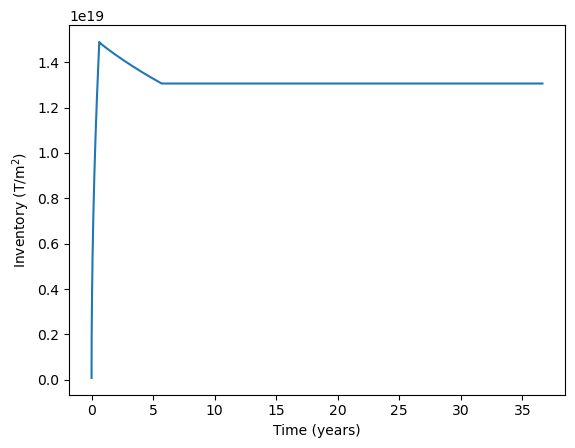

In [5]:
import matplotlib.pyplot as plt

time = np.array(total_H.t)

solute = np.array(total_H.data)
trapped = np.array(total_H_trapped.data)
print(solute)
retention = solute + trapped
one_year = 365 * 24 * 3600
plt.plot(time / one_year, retention)
plt.xlabel("Time (years)")
plt.ylabel("Inventory (T/m$^{2}$)")

By plotting the retention profiles, we also observe the decrease of the tritium concentration.

Text(0, 0.5, 'Retention (T m$^{-3}$)')

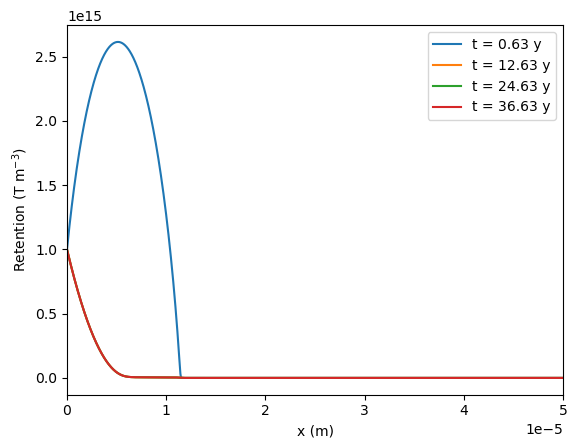

In [6]:
for time in my_model.settings.stepsize.milestones:
    name = f"t={time:.2e}s"
    idx = np.where(np.array(profile_exports[0].t) == time)[0][0]
    c_H = profile_exports[0].data[idx]
    c_H_trapped = profile_exports[1].data[idx]
    x = my_model.mesh.mesh.geometry.x[:, 0]
    plt.plot(x, c_H, label=f"t = {time/one_year:.2f} y")
    # print(c)

plt.legend()
plt.xlim(0, 5e-5)
plt.xlabel("x (m)")
plt.ylabel("Retention (T m$^{-3}$)")